# Dependencies loading

In [426]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import numpy
import numba
from catboost import CatBoostClassifier, cv, Pool
import optuna
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, 
                             roc_auc_score, roc_curve)
from sklearn.inspection import permutation_importance
import shap

import warnings
warnings.filterwarnings('ignore')  # Suppress warning

# Data loading

In [429]:
base_url = "https://raw.githubusercontent.com/filipecorreia23/Bank-Term-Deposit-Prediction/main/output"

# importing datasets
X_train = pd.read_csv(f"{base_url}/X_train_fe.csv")
X_test = pd.read_csv(f"{base_url}/X_test_fe.csv")
y_train = pd.read_csv(f"{base_url}/y_train.csv")
y_test = pd.read_csv(f"{base_url}/y_test.csv")

print(X_train.shape, X_test.shape)
print(y_train.shape,y_test.shape)

(34554, 20) (8639, 20)
(34554, 1) (8639, 1)


In [430]:
X_train

,age,job,marital,education,balance,housing,loan,contact,duration,pdays,previous,poutcome,contact_date,customer_value_score,estimated_income,balance_per_contact,age_balance_ratio,age_bin,previous_bin,last_contact_days_bin
0,55,blue-collar,married,secondary,16873,0,0,cellular,4.369448,-1,0,other,1-jun,16873,33873,16873.0,301.303571,Senior,none,no contact
1,34,technician,married,secondary,4,1,0,cellular,4.663439,263,1,failure,2-feb,8,22004,2.0,0.114286,Middle-aged,low,long ago
2,40,admin.,married,secondary,451,1,1,unknown,5.552960,-1,0,other,29-may,451,22451,451.0,11.000000,Middle-aged,none,no contact
3,29,services,single,secondary,-142,1,0,unknown,4.948760,-1,0,other,16-may,-142,16858,-142.0,-4.733333,Young,none,no contact
4,51,technician,divorced,secondary,131,1,0,cellular,5.267858,-1,0,other,18-nov,131,22131,131.0,2.519231,Senior,none,no contact
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34549,60,retired,married,secondary,2060,0,0,cellular,4.912655,95,4,failure,29-jun,10300,14060,412.0,33.770492,Senior,medium,long ago
34550,32,management,single,tertiary,0,0,0,cellular,4.060443,-1,0,other,19-nov,0,28000,0.0,0.000000,Middle-aged,none,no contact
34551,38,blue-collar,married,primary,0,0,0,unknown,5.347108,-1,0,other,13-may,0,16000,0.0,0.000000,Middle-aged,none,no contact
34552,30,admin.,single,secondary,154,1,0,cellular,3.218876,-1,0,other,21-nov,154,22154,154.0,4.967742,Young,none,no contact


# Model

In [432]:
category_cols = ['job', 'marital', 'education', 'contact', 'contact_date', 
                 'poutcome','age_bin','previous_bin','last_contact_days_bin']

# initialize the model
cat_model = CatBoostClassifier()

# fit the model
cat_model.fit(X_train, y_train,cat_features=category_cols, verbose=10)

# and make predictions
y_pred = cat_model.predict(X_test)

Learning rate set to 0.04676
0:	learn: 0.6404704	total: 13.6ms	remaining: 13.6s
10:	learn: 0.3651209	total: 154ms	remaining: 13.8s
20:	learn: 0.2612279	total: 283ms	remaining: 13.2s
30:	learn: 0.2279422	total: 400ms	remaining: 12.5s
40:	learn: 0.2135944	total: 516ms	remaining: 12.1s
50:	learn: 0.2051601	total: 635ms	remaining: 11.8s
60:	learn: 0.2008718	total: 758ms	remaining: 11.7s
70:	learn: 0.1974622	total: 880ms	remaining: 11.5s
80:	learn: 0.1954383	total: 1.01s	remaining: 11.5s
90:	learn: 0.1938059	total: 1.17s	remaining: 11.7s
100:	learn: 0.1925976	total: 1.29s	remaining: 11.5s
110:	learn: 0.1913385	total: 1.42s	remaining: 11.4s
120:	learn: 0.1905186	total: 1.54s	remaining: 11.2s
130:	learn: 0.1896212	total: 1.69s	remaining: 11.2s
140:	learn: 0.1888286	total: 1.81s	remaining: 11.1s
150:	learn: 0.1880739	total: 1.94s	remaining: 10.9s
160:	learn: 0.1874297	total: 2.1s	remaining: 11s
170:	learn: 0.1867368	total: 2.27s	remaining: 11s
180:	learn: 0.1861888	total: 2.42s	remaining: 10.9

## Model Evaluation

### Accuracy:

In [435]:
# lets start with accuracy
xgb_accuracy = accuracy_score(y_test, y_pred)
xgb_accuracy

0.9098275263340665

The model did well with 91% accuracy, which is a great start. Next, we should look at other things like precision and recall, especially for the smaller class, to make sure it handles imbalances properly.

### Classification Report:

In [438]:
# prediction probabilities
y_test_proba = cat_model.predict_proba(X_test)[:, 1]

# classification report
report = classification_report(y_test, y_pred, target_names=["No", "Yes"])
print(report)

              precision    recall  f1-score   support

          No       0.93      0.97      0.95      7635
         Yes       0.65      0.49      0.56      1004

    accuracy                           0.91      8639
   macro avg       0.79      0.73      0.75      8639
weighted avg       0.90      0.91      0.90      8639



The model performs strongly for non-subscribers (class 0), achieving high precision and recall. While it struggles with identifying subscribers (class 1), showing lower recall and F1-score, it still outperformed other models for the smaller class. Despite an overall accuracy of 91%, there’s room to further improve class 1 predictions for better balance.

### ROC AUC score:

In [441]:
auc_score = roc_auc_score(y_test, y_test_proba)
print(f"Test AUC: {auc_score:.4f}")

Test AUC: 0.9355


The Test AUC score of 0.9355 shows that the model performs better than the other models in distinguishing between classes. While the other models also performed very well, this one showed an even stronger ability to correctly rank positive and negative instances, reflecting very nice overall performance.

### Consusion Matrix:

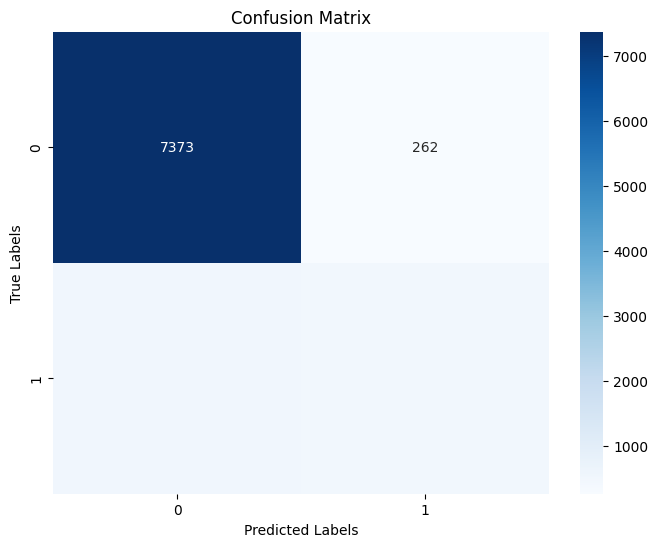

In [444]:
cm = confusion_matrix(y_test, y_pred)

# plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["0", "1"], yticklabels=["0", "1"])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

The confusion matrix shows once again that the model is great at predicting non-subscribers (class 0) but struggles to identify subscribers (class 1) accurately.

### ROC curve:

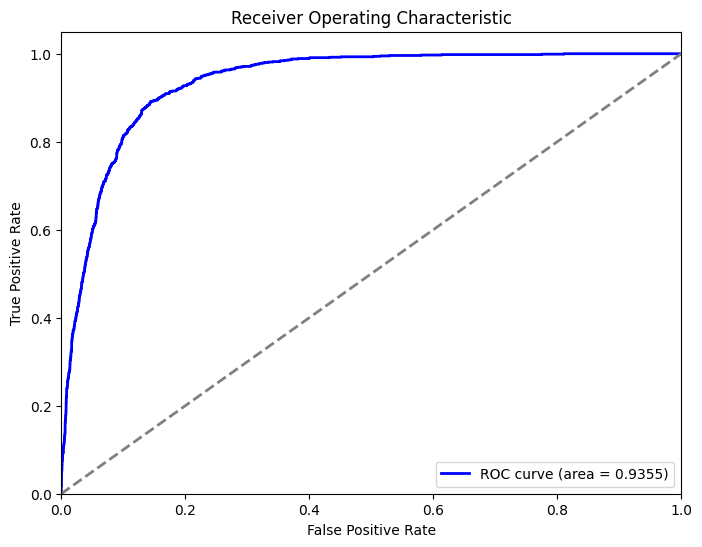

In [447]:
fpr, tpr, _ = roc_curve(y_test, y_test_proba)

# plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {auc_score:.4f})')
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

The ROC curve shows the model performs well overall, with an AUC score of 0.9355, 
outperforming its peers. However, it still struggles to fully capture subscribers 
due to the imbalance, favoring non-subscribers. We'll see if hyperparameters like 'scale_pos_weight' and 'subsample' can help balance the data and improve performance.

## Hyperparameter tunning

In [481]:
# objective function
def objective(trial):
    # defining hyperparameters to optimize
    params = {
        "iterations": trial.suggest_int("iterations", 50, 300),
        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 0.05, log=True),
        "depth": trial.suggest_int("depth", 1, 6),
        "subsample": trial.suggest_float("subsample", 0.1, 0.9),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.1, 0.9),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 500, 1500),
        "scale_pos_weight": trial.suggest_float("scale_pos_weight", 1, 4),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 50, 150),
    }

    # lets initialize the CatBoost model
    cat_model = CatBoostClassifier(**params, eval_metric="F1", custom_metric="F1")

    # and train the model with early stopping
    cat_model.fit(X_train, y_train, eval_set=(X_test, y_test), cat_features=category_cols, 
                  early_stopping_rounds=30, 
                  verbose=1)

    # return the best F1-score from the validation set
    return max(cat_model.evals_result_["validation"]["F1"])

# create an Optuna study for maximizing F1-score
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

# get the best hyperparameters
best_params = study.best_trial.params

# train the final model with the best parameters
cat_model = CatBoostClassifier(**best_params, cat_features=category_cols, eval_metric="F1", custom_metric="F1", verbose=100)
cat_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=10)

[I 2025-01-04 13:43:22,235] A new study created in memory with name: no-name-953c928a-1a1d-407c-815a-008b8841fb16


0:	learn: 0.6326729	test: 0.6314121	best: 0.6314121 (0)	total: 21.7ms	remaining: 3.99s
1:	learn: 0.6284397	test: 0.6350578	best: 0.6350578 (1)	total: 38.5ms	remaining: 3.53s
2:	learn: 0.6275695	test: 0.6315611	best: 0.6350578 (1)	total: 46.5ms	remaining: 2.82s
3:	learn: 0.6500856	test: 0.6524113	best: 0.6524113 (3)	total: 53.7ms	remaining: 2.43s
4:	learn: 0.6411338	test: 0.6392673	best: 0.6524113 (3)	total: 60.8ms	remaining: 2.19s
5:	learn: 0.6411583	test: 0.6400513	best: 0.6524113 (3)	total: 66.8ms	remaining: 1.99s
6:	learn: 0.6378049	test: 0.6303274	best: 0.6524113 (3)	total: 73.1ms	remaining: 1.86s
7:	learn: 0.6375760	test: 0.6297807	best: 0.6524113 (3)	total: 78.5ms	remaining: 1.74s
8:	learn: 0.6384971	test: 0.6306029	best: 0.6524113 (3)	total: 83.4ms	remaining: 1.63s
9:	learn: 0.6386562	test: 0.6333171	best: 0.6524113 (3)	total: 88.7ms	remaining: 1.55s
10:	learn: 0.6371138	test: 0.6304656	best: 0.6524113 (3)	total: 94ms	remaining: 1.49s
11:	learn: 0.6343615	test: 0.6260817	best: 0

[I 2025-01-04 13:43:22,544] Trial 0 finished with value: 0.6524113266787165 and parameters: {'iterations': 185, 'learning_rate': 0.000752729182574598, 'depth': 4, 'subsample': 0.22027758945903875, 'colsample_bylevel': 0.7261847128994405, 'min_data_in_leaf': 1037, 'scale_pos_weight': 2.5341902662341496, 'l2_leaf_reg': 57.245472366504444}. Best is trial 0 with value: 0.6524113266787165.


33:	learn: 0.6350288	test: 0.6222316	best: 0.6524113 (3)	total: 222ms	remaining: 985ms
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6524113267
bestIteration = 3

Shrink model to first 4 iterations.
0:	learn: 0.6570283	test: 0.6393874	best: 0.6393874 (0)	total: 8.7ms	remaining: 948ms
1:	learn: 0.6665006	test: 0.6549047	best: 0.6549047 (1)	total: 16.1ms	remaining: 868ms
2:	learn: 0.6998484	test: 0.6925294	best: 0.6925294 (2)	total: 23.3ms	remaining: 829ms
3:	learn: 0.6899739	test: 0.6836375	best: 0.6925294 (2)	total: 29.1ms	remaining: 772ms
4:	learn: 0.7002886	test: 0.6943452	best: 0.6943452 (4)	total: 35ms	remaining: 735ms
5:	learn: 0.7006303	test: 0.6928670	best: 0.6943452 (4)	total: 41.2ms	remaining: 714ms
6:	learn: 0.7006303	test: 0.6927642	best: 0.6943452 (4)	total: 47.1ms	remaining: 693ms
7:	learn: 0.6912161	test: 0.6855739	best: 0.6943452 (4)	total: 53.7ms	remaining: 685ms
8:	learn: 0.6924969	test: 0.6852262	best: 0.6943452 (4)	total: 60ms	remaining: 674ms
9

[I 2025-01-04 13:43:22,805] Trial 1 finished with value: 0.694345204639799 and parameters: {'iterations': 110, 'learning_rate': 0.0024699310342683823, 'depth': 5, 'subsample': 0.15616665252265147, 'colsample_bylevel': 0.7251620841000975, 'min_data_in_leaf': 1287, 'scale_pos_weight': 3.5375464384446955, 'l2_leaf_reg': 127.80288224294864}. Best is trial 1 with value: 0.694345204639799.


24:	learn: 0.6870410	test: 0.6911554	best: 0.6943452 (4)	total: 159ms	remaining: 539ms
25:	learn: 0.6883698	test: 0.6903241	best: 0.6943452 (4)	total: 164ms	remaining: 529ms
26:	learn: 0.6880993	test: 0.6903241	best: 0.6943452 (4)	total: 169ms	remaining: 520ms
27:	learn: 0.6870225	test: 0.6898056	best: 0.6943452 (4)	total: 174ms	remaining: 510ms
28:	learn: 0.6866345	test: 0.6900129	best: 0.6943452 (4)	total: 180ms	remaining: 503ms
29:	learn: 0.6860395	test: 0.6901166	best: 0.6943452 (4)	total: 186ms	remaining: 495ms
30:	learn: 0.6853664	test: 0.6907089	best: 0.6943452 (4)	total: 192ms	remaining: 490ms
31:	learn: 0.6854548	test: 0.6909474	best: 0.6943452 (4)	total: 198ms	remaining: 483ms
32:	learn: 0.6856757	test: 0.6889296	best: 0.6943452 (4)	total: 206ms	remaining: 480ms
33:	learn: 0.6856926	test: 0.6890333	best: 0.6943452 (4)	total: 211ms	remaining: 472ms
34:	learn: 0.6860808	test: 0.6896100	best: 0.6943452 (4)	total: 218ms	remaining: 466ms
Stopped by overfitting detector  (30 iterat

[I 2025-01-04 13:43:23,098] Trial 2 finished with value: 0.6916010309486438 and parameters: {'iterations': 71, 'learning_rate': 0.0016027416931415571, 'depth': 5, 'subsample': 0.2931417526215732, 'colsample_bylevel': 0.696735426409061, 'min_data_in_leaf': 1396, 'scale_pos_weight': 3.5732942813866666, 'l2_leaf_reg': 125.38349340957157}. Best is trial 1 with value: 0.694345204639799.


16:	learn: 0.6843769	test: 0.6898236	best: 0.6916010 (11)	total: 108ms	remaining: 342ms
17:	learn: 0.6837174	test: 0.6880197	best: 0.6916010 (11)	total: 113ms	remaining: 334ms
18:	learn: 0.6839913	test: 0.6902117	best: 0.6916010 (11)	total: 120ms	remaining: 328ms
19:	learn: 0.6863661	test: 0.6912388	best: 0.6916010 (11)	total: 126ms	remaining: 321ms
20:	learn: 0.6846556	test: 0.6886968	best: 0.6916010 (11)	total: 132ms	remaining: 314ms
21:	learn: 0.6832941	test: 0.6860419	best: 0.6916010 (11)	total: 138ms	remaining: 307ms
22:	learn: 0.6822443	test: 0.6878441	best: 0.6916010 (11)	total: 143ms	remaining: 299ms
23:	learn: 0.6824702	test: 0.6864156	best: 0.6916010 (11)	total: 149ms	remaining: 291ms
24:	learn: 0.6845932	test: 0.6887980	best: 0.6916010 (11)	total: 156ms	remaining: 286ms
25:	learn: 0.6843693	test: 0.6915182	best: 0.6916010 (11)	total: 162ms	remaining: 280ms
26:	learn: 0.6834004	test: 0.6891283	best: 0.6916010 (11)	total: 168ms	remaining: 274ms
27:	learn: 0.6836582	test: 0.686

[I 2025-01-04 13:43:23,300] Trial 3 finished with value: 0.6608645195921522 and parameters: {'iterations': 88, 'learning_rate': 0.011475910246124595, 'depth': 3, 'subsample': 0.2831459825463277, 'colsample_bylevel': 0.8544203782896501, 'min_data_in_leaf': 1462, 'scale_pos_weight': 3.156713064792792, 'l2_leaf_reg': 92.15742325685758}. Best is trial 1 with value: 0.694345204639799.


2:	learn: 0.6607481	test: 0.6554704	best: 0.6608645 (1)	total: 16.9ms	remaining: 478ms
3:	learn: 0.6637695	test: 0.6591608	best: 0.6608645 (1)	total: 22.6ms	remaining: 475ms
4:	learn: 0.6627235	test: 0.6592077	best: 0.6608645 (1)	total: 27.9ms	remaining: 462ms
5:	learn: 0.6600930	test: 0.6569514	best: 0.6608645 (1)	total: 33.7ms	remaining: 461ms
6:	learn: 0.6599813	test: 0.6575562	best: 0.6608645 (1)	total: 39.3ms	remaining: 455ms
7:	learn: 0.6583937	test: 0.6563110	best: 0.6608645 (1)	total: 44.1ms	remaining: 441ms
8:	learn: 0.6605790	test: 0.6580282	best: 0.6608645 (1)	total: 49ms	remaining: 430ms
9:	learn: 0.6606354	test: 0.6580282	best: 0.6608645 (1)	total: 53.6ms	remaining: 418ms
10:	learn: 0.6612035	test: 0.6599615	best: 0.6608645 (1)	total: 58.2ms	remaining: 407ms
11:	learn: 0.6604549	test: 0.6580282	best: 0.6608645 (1)	total: 63.3ms	remaining: 401ms
12:	learn: 0.6605790	test: 0.6580282	best: 0.6608645 (1)	total: 68.8ms	remaining: 397ms
13:	learn: 0.6605226	test: 0.6580282	best:

[I 2025-01-04 13:43:23,484] Trial 4 finished with value: 0.3382644310451733 and parameters: {'iterations': 182, 'learning_rate': 0.0008559450769564552, 'depth': 3, 'subsample': 0.20875602894094003, 'colsample_bylevel': 0.23097993147543827, 'min_data_in_leaf': 611, 'scale_pos_weight': 1.5303377341088398, 'l2_leaf_reg': 88.10995109726561}. Best is trial 1 with value: 0.694345204639799.


2:	learn: 0.2357017	test: 0.2511482	best: 0.3382644 (0)	total: 16.4ms	remaining: 977ms
3:	learn: 0.2135871	test: 0.2352208	best: 0.3382644 (0)	total: 22.6ms	remaining: 1s
4:	learn: 0.1691882	test: 0.1919232	best: 0.3382644 (0)	total: 27.6ms	remaining: 976ms
5:	learn: 0.0633504	test: 0.0800060	best: 0.3382644 (0)	total: 32.7ms	remaining: 960ms
6:	learn: 0.0605866	test: 0.0597149	best: 0.3382644 (0)	total: 38.2ms	remaining: 955ms
7:	learn: 0.0550618	test: 0.0503895	best: 0.3382644 (0)	total: 44.5ms	remaining: 967ms
8:	learn: 0.0550618	test: 0.0503895	best: 0.3382644 (0)	total: 48.7ms	remaining: 936ms
9:	learn: 0.0693189	test: 0.0634452	best: 0.3382644 (0)	total: 53.3ms	remaining: 917ms
10:	learn: 0.0711409	test: 0.0652641	best: 0.3382644 (0)	total: 58.3ms	remaining: 906ms
11:	learn: 0.0752060	test: 0.0671192	best: 0.3382644 (0)	total: 62.9ms	remaining: 891ms
12:	learn: 0.0619650	test: 0.0559701	best: 0.3382644 (0)	total: 67ms	remaining: 872ms
13:	learn: 0.0461256	test: 0.0484985	best: 0.

[I 2025-01-04 13:43:23,654] Trial 5 finished with value: 0.3026828991894738 and parameters: {'iterations': 236, 'learning_rate': 0.00010078082818488893, 'depth': 1, 'subsample': 0.822211882330598, 'colsample_bylevel': 0.2617534192281908, 'min_data_in_leaf': 533, 'scale_pos_weight': 3.454004431305905, 'l2_leaf_reg': 101.76845743853927}. Best is trial 1 with value: 0.694345204639799.


8:	learn: 0.3010711	test: 0.3026829	best: 0.3026829 (0)	total: 38.3ms	remaining: 966ms
9:	learn: 0.3007221	test: 0.3026829	best: 0.3026829 (0)	total: 43ms	remaining: 972ms
10:	learn: 0.3007221	test: 0.3026829	best: 0.3026829 (0)	total: 47.6ms	remaining: 973ms
11:	learn: 0.3011069	test: 0.3026829	best: 0.3026829 (0)	total: 52.2ms	remaining: 973ms
12:	learn: 0.3011069	test: 0.3026829	best: 0.3026829 (0)	total: 56.7ms	remaining: 972ms
13:	learn: 0.2909916	test: 0.2945470	best: 0.3026829 (0)	total: 60.8ms	remaining: 964ms
14:	learn: 0.2505680	test: 0.2526896	best: 0.3026829 (0)	total: 66.1ms	remaining: 974ms
15:	learn: 0.1924531	test: 0.2021557	best: 0.3026829 (0)	total: 70.2ms	remaining: 965ms
16:	learn: 0.2808052	test: 0.2863141	best: 0.3026829 (0)	total: 75.5ms	remaining: 972ms
17:	learn: 0.2636325	test: 0.2671524	best: 0.3026829 (0)	total: 79.6ms	remaining: 964ms
18:	learn: 0.2636325	test: 0.2671524	best: 0.3026829 (0)	total: 85ms	remaining: 971ms
19:	learn: 0.1916494	test: 0.2021557	b

[I 2025-01-04 13:43:23,824] Trial 6 finished with value: 0.5453285460558479 and parameters: {'iterations': 139, 'learning_rate': 0.0031596515895440905, 'depth': 1, 'subsample': 0.8257267212123253, 'colsample_bylevel': 0.7233053961351922, 'min_data_in_leaf': 913, 'scale_pos_weight': 2.2942877878900934, 'l2_leaf_reg': 87.53357899192002}. Best is trial 1 with value: 0.694345204639799.


16:	learn: 0.4955952	test: 0.4807713	best: 0.5453285 (0)	total: 72.2ms	remaining: 518ms
17:	learn: 0.4955952	test: 0.4807713	best: 0.5453285 (0)	total: 76.9ms	remaining: 517ms
18:	learn: 0.4955952	test: 0.4807713	best: 0.5453285 (0)	total: 81.3ms	remaining: 513ms
19:	learn: 0.0726306	test: 0.0746283	best: 0.5453285 (0)	total: 85.6ms	remaining: 509ms
20:	learn: 0.0794802	test: 0.0764051	best: 0.5453285 (0)	total: 90.4ms	remaining: 508ms
21:	learn: 0.0794802	test: 0.0764051	best: 0.5453285 (0)	total: 94.7ms	remaining: 504ms
22:	learn: 0.4990114	test: 0.4814628	best: 0.5453285 (0)	total: 98.6ms	remaining: 497ms
23:	learn: 0.4990114	test: 0.4814628	best: 0.5453285 (0)	total: 103ms	remaining: 491ms
24:	learn: 0.4990114	test: 0.4814628	best: 0.5453285 (0)	total: 106ms	remaining: 485ms
25:	learn: 0.4976266	test: 0.4806395	best: 0.5453285 (0)	total: 111ms	remaining: 484ms
26:	learn: 0.4955952	test: 0.4807713	best: 0.5453285 (0)	total: 115ms	remaining: 479ms
27:	learn: 0.4976266	test: 0.4806395

[I 2025-01-04 13:43:24,073] Trial 7 finished with value: 0.6791208320440605 and parameters: {'iterations': 90, 'learning_rate': 0.0003530583873384437, 'depth': 5, 'subsample': 0.23848863619164337, 'colsample_bylevel': 0.8707387138496329, 'min_data_in_leaf': 655, 'scale_pos_weight': 3.2503192267219956, 'l2_leaf_reg': 125.85961555219737}. Best is trial 1 with value: 0.694345204639799.


16:	learn: 0.6737620	test: 0.6734974	best: 0.6791208 (4)	total: 104ms	remaining: 448ms
17:	learn: 0.6737457	test: 0.6740832	best: 0.6791208 (4)	total: 110ms	remaining: 439ms
18:	learn: 0.6736914	test: 0.6747767	best: 0.6791208 (4)	total: 116ms	remaining: 433ms
19:	learn: 0.6739843	test: 0.6761617	best: 0.6791208 (4)	total: 121ms	remaining: 425ms
20:	learn: 0.6737999	test: 0.6741917	best: 0.6791208 (4)	total: 128ms	remaining: 421ms
21:	learn: 0.6740064	test: 0.6743003	best: 0.6791208 (4)	total: 133ms	remaining: 412ms
22:	learn: 0.6743856	test: 0.6740832	best: 0.6791208 (4)	total: 140ms	remaining: 409ms
23:	learn: 0.6738650	test: 0.6738662	best: 0.6791208 (4)	total: 146ms	remaining: 401ms
24:	learn: 0.6735177	test: 0.6746682	best: 0.6791208 (4)	total: 151ms	remaining: 393ms
25:	learn: 0.6737784	test: 0.6733889	best: 0.6791208 (4)	total: 157ms	remaining: 386ms
26:	learn: 0.6745459	test: 0.6742579	best: 0.6791208 (4)	total: 163ms	remaining: 380ms
27:	learn: 0.6743387	test: 0.6746263	best: 

[I 2025-01-04 13:43:24,406] Trial 8 finished with value: 0.5645494532370378 and parameters: {'iterations': 64, 'learning_rate': 0.019306398355272474, 'depth': 4, 'subsample': 0.5201900549006865, 'colsample_bylevel': 0.26602706406370713, 'min_data_in_leaf': 1387, 'scale_pos_weight': 2.274222360290135, 'l2_leaf_reg': 84.8133017859071}. Best is trial 1 with value: 0.694345204639799.


48:	learn: 0.5531774	test: 0.5242545	best: 0.5645495 (23)	total: 266ms	remaining: 81.3ms
49:	learn: 0.5591204	test: 0.5330081	best: 0.5645495 (23)	total: 271ms	remaining: 75.9ms
50:	learn: 0.5527490	test: 0.5263428	best: 0.5645495 (23)	total: 278ms	remaining: 70.9ms
51:	learn: 0.5470776	test: 0.5186407	best: 0.5645495 (23)	total: 282ms	remaining: 65.2ms
52:	learn: 0.5397312	test: 0.5088257	best: 0.5645495 (23)	total: 288ms	remaining: 59.9ms
53:	learn: 0.5474286	test: 0.5230054	best: 0.5645495 (23)	total: 293ms	remaining: 54.3ms
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5645494532
bestIteration = 23

Shrink model to first 24 iterations.
0:	learn: 0.5195200	test: 0.5037936	best: 0.5037936 (0)	total: 17.5ms	remaining: 3.52s
1:	learn: 0.5102237	test: 0.4950597	best: 0.5037936 (0)	total: 27.2ms	remaining: 2.72s
2:	learn: 0.4457437	test: 0.4323304	best: 0.5037936 (0)	total: 40.1ms	remaining: 2.66s
3:	learn: 0.4857266	test: 0.4688126	best: 0.5037936 (0)	total: 54.3ms

[I 2025-01-04 13:43:24,825] Trial 9 finished with value: 0.5037935530112332 and parameters: {'iterations': 202, 'learning_rate': 0.0012922568519932473, 'depth': 6, 'subsample': 0.8860729306183884, 'colsample_bylevel': 0.6694048701640767, 'min_data_in_leaf': 1488, 'scale_pos_weight': 1.4454817157405817, 'l2_leaf_reg': 112.57182822643513}. Best is trial 1 with value: 0.694345204639799.


27:	learn: 0.5234113	test: 0.5009198	best: 0.5037936 (0)	total: 342ms	remaining: 2.12s
28:	learn: 0.5230128	test: 0.4992934	best: 0.5037936 (0)	total: 355ms	remaining: 2.12s
29:	learn: 0.5228585	test: 0.5013446	best: 0.5037936 (0)	total: 368ms	remaining: 2.11s
30:	learn: 0.5227904	test: 0.5004255	best: 0.5037936 (0)	total: 380ms	remaining: 2.1s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.503793553
bestIteration = 0

Shrink model to first 1 iterations.
0:	learn: 0.6730854	test: 0.6519754	best: 0.6519754 (0)	total: 7.66ms	remaining: 988ms
1:	learn: 0.7123784	test: 0.7101289	best: 0.7101289 (1)	total: 14.9ms	remaining: 954ms
2:	learn: 0.7043669	test: 0.7029736	best: 0.7101289 (1)	total: 21.3ms	remaining: 904ms
3:	learn: 0.7019789	test: 0.6959363	best: 0.7101289 (1)	total: 29.1ms	remaining: 915ms
4:	learn: 0.7028326	test: 0.7000158	best: 0.7101289 (1)	total: 34.8ms	remaining: 871ms
5:	learn: 0.7044874	test: 0.7038326	best: 0.7101289 (1)	total: 41.3ms	remaining: 855m

[I 2025-01-04 13:43:25,090] Trial 10 finished with value: 0.7101289388990549 and parameters: {'iterations': 130, 'learning_rate': 0.0060499356480250835, 'depth': 6, 'subsample': 0.4807213975554734, 'colsample_bylevel': 0.4635227207438773, 'min_data_in_leaf': 1140, 'scale_pos_weight': 3.859306523668101, 'l2_leaf_reg': 137.24819204502182}. Best is trial 10 with value: 0.7101289388990549.


16:	learn: 0.7044525	test: 0.6958850	best: 0.7101289 (1)	total: 113ms	remaining: 750ms
17:	learn: 0.7067198	test: 0.6974362	best: 0.7101289 (1)	total: 120ms	remaining: 746ms
18:	learn: 0.7047637	test: 0.6940460	best: 0.7101289 (1)	total: 126ms	remaining: 736ms
19:	learn: 0.7057729	test: 0.6972447	best: 0.7101289 (1)	total: 132ms	remaining: 726ms
20:	learn: 0.7060944	test: 0.6974561	best: 0.7101289 (1)	total: 139ms	remaining: 719ms
21:	learn: 0.7029869	test: 0.6952431	best: 0.7101289 (1)	total: 145ms	remaining: 712ms
22:	learn: 0.7038660	test: 0.6953389	best: 0.7101289 (1)	total: 152ms	remaining: 707ms
23:	learn: 0.7060925	test: 0.6969917	best: 0.7101289 (1)	total: 159ms	remaining: 701ms
24:	learn: 0.7048709	test: 0.6937783	best: 0.7101289 (1)	total: 166ms	remaining: 696ms
25:	learn: 0.7042676	test: 0.6944515	best: 0.7101289 (1)	total: 173ms	remaining: 691ms
26:	learn: 0.7044253	test: 0.6962545	best: 0.7101289 (1)	total: 180ms	remaining: 685ms
27:	learn: 0.7022659	test: 0.6961582	best: 

[I 2025-01-04 13:43:26,054] Trial 11 finished with value: 0.7581199546816032 and parameters: {'iterations': 137, 'learning_rate': 0.005444981990156976, 'depth': 6, 'subsample': 0.48175625079887174, 'colsample_bylevel': 0.4657791942196066, 'min_data_in_leaf': 1175, 'scale_pos_weight': 3.7120425834597413, 'l2_leaf_reg': 147.437829453085}. Best is trial 11 with value: 0.7581199546816032.


129:	learn: 0.7658989	test: 0.7546273	best: 0.7554848 (124)	total: 856ms	remaining: 46.1ms
130:	learn: 0.7658471	test: 0.7561095	best: 0.7561095 (130)	total: 863ms	remaining: 39.5ms
131:	learn: 0.7661595	test: 0.7564330	best: 0.7564330 (131)	total: 869ms	remaining: 32.9ms
132:	learn: 0.7668345	test: 0.7563288	best: 0.7564330 (131)	total: 875ms	remaining: 26.3ms
133:	learn: 0.7668345	test: 0.7567455	best: 0.7567455 (133)	total: 882ms	remaining: 19.8ms
134:	learn: 0.7667308	test: 0.7573809	best: 0.7573809 (134)	total: 890ms	remaining: 13.2ms
135:	learn: 0.7674828	test: 0.7570682	best: 0.7573809 (134)	total: 896ms	remaining: 6.59ms
136:	learn: 0.7668352	test: 0.7581200	best: 0.7581200 (136)	total: 902ms	remaining: 0us

bestTest = 0.7581199547
bestIteration = 136

0:	learn: 0.6871412	test: 0.6707214	best: 0.6707214 (0)	total: 11.9ms	remaining: 3.5s
1:	learn: 0.7236256	test: 0.7228505	best: 0.7228505 (1)	total: 22.8ms	remaining: 3.32s
2:	learn: 0.7688239	test: 0.7688129	best: 0.7688129 (2)	

[I 2025-01-04 13:43:26,595] Trial 12 finished with value: 0.7841076433814911 and parameters: {'iterations': 294, 'learning_rate': 0.007470113879670955, 'depth': 6, 'subsample': 0.517688617658759, 'colsample_bylevel': 0.4454572827169482, 'min_data_in_leaf': 1131, 'scale_pos_weight': 3.9675790260889414, 'l2_leaf_reg': 148.1517420665899}. Best is trial 12 with value: 0.7841076433814911.


31:	learn: 0.7813796	test: 0.7785304	best: 0.7841076 (18)	total: 310ms	remaining: 2.53s
32:	learn: 0.7791251	test: 0.7772303	best: 0.7841076 (18)	total: 322ms	remaining: 2.55s
33:	learn: 0.7786306	test: 0.7771094	best: 0.7841076 (18)	total: 333ms	remaining: 2.54s
34:	learn: 0.7797978	test: 0.7774248	best: 0.7841076 (18)	total: 343ms	remaining: 2.53s
35:	learn: 0.7810041	test: 0.7794584	best: 0.7841076 (18)	total: 350ms	remaining: 2.51s
36:	learn: 0.7806170	test: 0.7786592	best: 0.7841076 (18)	total: 360ms	remaining: 2.5s
37:	learn: 0.7807280	test: 0.7790695	best: 0.7841076 (18)	total: 372ms	remaining: 2.5s
38:	learn: 0.7809837	test: 0.7792848	best: 0.7841076 (18)	total: 383ms	remaining: 2.5s
39:	learn: 0.7806027	test: 0.7771567	best: 0.7841076 (18)	total: 394ms	remaining: 2.5s
40:	learn: 0.7813719	test: 0.7768416	best: 0.7841076 (18)	total: 405ms	remaining: 2.5s
41:	learn: 0.7806943	test: 0.7776654	best: 0.7841076 (18)	total: 414ms	remaining: 2.48s
42:	learn: 0.7810814	test: 0.7772538	

[I 2025-01-04 13:43:27,133] Trial 13 finished with value: 0.7826645074061154 and parameters: {'iterations': 287, 'learning_rate': 0.008396411378338018, 'depth': 6, 'subsample': 0.5634117121723641, 'colsample_bylevel': 0.4376238739986433, 'min_data_in_leaf': 866, 'scale_pos_weight': 3.998399200888821, 'l2_leaf_reg': 148.76349196744954}. Best is trial 12 with value: 0.7841076433814911.


40:	learn: 0.7805538	test: 0.7736246	best: 0.7826645 (14)	total: 428ms	remaining: 2.57s
41:	learn: 0.7801199	test: 0.7733448	best: 0.7826645 (14)	total: 437ms	remaining: 2.55s
42:	learn: 0.7811354	test: 0.7731873	best: 0.7826645 (14)	total: 450ms	remaining: 2.56s
43:	learn: 0.7810357	test: 0.7727811	best: 0.7826645 (14)	total: 471ms	remaining: 2.6s
44:	learn: 0.7814662	test: 0.7714653	best: 0.7826645 (14)	total: 482ms	remaining: 2.59s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.7826645074
bestIteration = 14

Shrink model to first 15 iterations.
0:	learn: 0.6466564	test: 0.6255488	best: 0.6255488 (0)	total: 12.3ms	remaining: 3.65s
1:	learn: 0.6501272	test: 0.6324735	best: 0.6324735 (1)	total: 22.5ms	remaining: 3.31s
2:	learn: 0.6593157	test: 0.6573035	best: 0.6573035 (2)	total: 32.2ms	remaining: 3.16s
3:	learn: 0.6611560	test: 0.6582707	best: 0.6582707 (3)	total: 43.3ms	remaining: 3.17s
4:	learn: 0.6579719	test: 0.6574245	best: 0.6582707 (3)	total: 52.3ms	remaini

[I 2025-01-04 13:43:30,047] Trial 14 finished with value: 0.7637199412337297 and parameters: {'iterations': 297, 'learning_rate': 0.02886554646760264, 'depth': 6, 'subsample': 0.6292968656645462, 'colsample_bylevel': 0.37364665181093604, 'min_data_in_leaf': 829, 'scale_pos_weight': 2.9414292291608324, 'l2_leaf_reg': 149.94043408040454}. Best is trial 12 with value: 0.7841076433814911.


262:	learn: 0.7802519	test: 0.7618200	best: 0.7637199 (237)	total: 2.76s	remaining: 357ms
263:	learn: 0.7802191	test: 0.7613263	best: 0.7637199 (237)	total: 2.77s	remaining: 347ms
264:	learn: 0.7804029	test: 0.7614569	best: 0.7637199 (237)	total: 2.79s	remaining: 336ms
265:	learn: 0.7804029	test: 0.7625741	best: 0.7637199 (237)	total: 2.79s	remaining: 326ms
266:	learn: 0.7808689	test: 0.7625741	best: 0.7637199 (237)	total: 2.81s	remaining: 315ms
267:	learn: 0.7809017	test: 0.7625741	best: 0.7637199 (237)	total: 2.82s	remaining: 305ms
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.7637199412
bestIteration = 237

Shrink model to first 238 iterations.
0:	learn: 0.5461502	test: 0.5324921	best: 0.5324921 (0)	total: 4.88ms	remaining: 1.45s
1:	learn: 0.4327701	test: 0.4118227	best: 0.5324921 (0)	total: 9.28ms	remaining: 1.37s
2:	learn: 0.4174891	test: 0.3746465	best: 0.5324921 (0)	total: 13.7ms	remaining: 1.35s
3:	learn: 0.3796969	test: 0.3418302	best: 0.5324921 (0)	total

[I 2025-01-04 13:43:30,243] Trial 15 finished with value: 0.532492075546768 and parameters: {'iterations': 297, 'learning_rate': 0.03877022664049722, 'depth': 2, 'subsample': 0.6617041440097552, 'colsample_bylevel': 0.11613867989265436, 'min_data_in_leaf': 779, 'scale_pos_weight': 3.9510799229740177, 'l2_leaf_reg': 65.91075965552885}. Best is trial 12 with value: 0.7841076433814911.


16:	learn: 0.4467718	test: 0.4241286	best: 0.5324921 (0)	total: 80ms	remaining: 1.32s
17:	learn: 0.4383312	test: 0.4157849	best: 0.5324921 (0)	total: 84ms	remaining: 1.3s
18:	learn: 0.4252275	test: 0.4087465	best: 0.5324921 (0)	total: 88.2ms	remaining: 1.29s
19:	learn: 0.4182264	test: 0.4004084	best: 0.5324921 (0)	total: 92.6ms	remaining: 1.28s
20:	learn: 0.4341846	test: 0.4062281	best: 0.5324921 (0)	total: 97ms	remaining: 1.27s
21:	learn: 0.4401331	test: 0.4141045	best: 0.5324921 (0)	total: 103ms	remaining: 1.28s
22:	learn: 0.4582222	test: 0.4276374	best: 0.5324921 (0)	total: 107ms	remaining: 1.27s
23:	learn: 0.4568285	test: 0.4291366	best: 0.5324921 (0)	total: 112ms	remaining: 1.27s
24:	learn: 0.4691874	test: 0.4375707	best: 0.5324921 (0)	total: 116ms	remaining: 1.26s
25:	learn: 0.4697397	test: 0.4412045	best: 0.5324921 (0)	total: 121ms	remaining: 1.26s
26:	learn: 0.4679705	test: 0.4416961	best: 0.5324921 (0)	total: 125ms	remaining: 1.25s
27:	learn: 0.4660575	test: 0.4395552	best: 0.

[I 2025-01-04 13:43:32,528] Trial 16 finished with value: 0.4867111938749056 and parameters: {'iterations': 261, 'learning_rate': 0.011532734689779698, 'depth': 5, 'subsample': 0.3654623321578273, 'colsample_bylevel': 0.5345008443060453, 'min_data_in_leaf': 1009, 'scale_pos_weight': 1.004915552678711, 'l2_leaf_reg': 136.4392538067452}. Best is trial 12 with value: 0.7841076433814911.


253:	learn: 0.5070479	test: 0.4801521	best: 0.4811376 (252)	total: 2.14s	remaining: 59ms
254:	learn: 0.5079794	test: 0.4801521	best: 0.4811376 (252)	total: 2.15s	remaining: 50.6ms
255:	learn: 0.5091503	test: 0.4811376	best: 0.4811376 (252)	total: 2.16s	remaining: 42.2ms
256:	learn: 0.5100805	test: 0.4818112	best: 0.4818112 (256)	total: 2.17s	remaining: 33.8ms
257:	learn: 0.5111735	test: 0.4818112	best: 0.4818112 (256)	total: 2.18s	remaining: 25.4ms
258:	learn: 0.5110141	test: 0.4857337	best: 0.4857337 (258)	total: 2.19s	remaining: 16.9ms
259:	learn: 0.5096133	test: 0.4857337	best: 0.4857337 (258)	total: 2.2s	remaining: 8.46ms
260:	learn: 0.5094543	test: 0.4867112	best: 0.4867112 (260)	total: 2.21s	remaining: 0us

bestTest = 0.4867111939
bestIteration = 260

0:	learn: 0.6323380	test: 0.6173807	best: 0.6173807 (0)	total: 9.97ms	remaining: 2.54s
1:	learn: 0.6256003	test: 0.6170590	best: 0.6173807 (0)	total: 18.4ms	remaining: 2.33s
2:	learn: 0.6132668	test: 0.6079610	best: 0.6173807 (0)	to

[I 2025-01-04 13:43:34,002] Trial 17 finished with value: 0.7323698754545099 and parameters: {'iterations': 256, 'learning_rate': 0.009623811425927843, 'depth': 4, 'subsample': 0.6401644140524222, 'colsample_bylevel': 0.5648134036860888, 'min_data_in_leaf': 1132, 'scale_pos_weight': 2.7489730404967583, 'l2_leaf_reg': 113.43254286843818}. Best is trial 12 with value: 0.7841076433814911.


166:	learn: 0.7321443	test: 0.7281430	best: 0.7323699 (147)	total: 1.29s	remaining: 687ms
167:	learn: 0.7324276	test: 0.7293251	best: 0.7323699 (147)	total: 1.3s	remaining: 680ms
168:	learn: 0.7331385	test: 0.7285281	best: 0.7323699 (147)	total: 1.31s	remaining: 673ms
169:	learn: 0.7334978	test: 0.7291875	best: 0.7323699 (147)	total: 1.32s	remaining: 666ms
170:	learn: 0.7337631	test: 0.7282531	best: 0.7323699 (147)	total: 1.32s	remaining: 659ms
171:	learn: 0.7337376	test: 0.7283906	best: 0.7323699 (147)	total: 1.34s	remaining: 653ms
172:	learn: 0.7345498	test: 0.7277305	best: 0.7323699 (147)	total: 1.35s	remaining: 646ms
173:	learn: 0.7342683	test: 0.7277305	best: 0.7323699 (147)	total: 1.36s	remaining: 642ms
174:	learn: 0.7346527	test: 0.7278680	best: 0.7323699 (147)	total: 1.37s	remaining: 636ms
175:	learn: 0.7344813	test: 0.7277305	best: 0.7323699 (147)	total: 1.38s	remaining: 629ms
176:	learn: 0.7346436	test: 0.7269325	best: 0.7323699 (147)	total: 1.39s	remaining: 622ms
177:	learn:

[I 2025-01-04 13:43:34,827] Trial 18 finished with value: 0.7730829566850353 and parameters: {'iterations': 220, 'learning_rate': 0.00455105478656573, 'depth': 6, 'subsample': 0.4064109088713238, 'colsample_bylevel': 0.37067272126509765, 'min_data_in_leaf': 889, 'scale_pos_weight': 3.972247421116607, 'l2_leaf_reg': 141.01634632123393}. Best is trial 12 with value: 0.7841076433814911.


68:	learn: 0.7803323	test: 0.7711030	best: 0.7730830 (50)	total: 642ms	remaining: 1.4s
69:	learn: 0.7804092	test: 0.7708156	best: 0.7730830 (50)	total: 654ms	remaining: 1.4s
70:	learn: 0.7803852	test: 0.7709114	best: 0.7730830 (50)	total: 665ms	remaining: 1.4s
71:	learn: 0.7800144	test: 0.7714865	best: 0.7730830 (50)	total: 673ms	remaining: 1.38s
72:	learn: 0.7798945	test: 0.7716784	best: 0.7730830 (50)	total: 683ms	remaining: 1.38s
73:	learn: 0.7798259	test: 0.7713278	best: 0.7730830 (50)	total: 692ms	remaining: 1.37s
74:	learn: 0.7795034	test: 0.7708153	best: 0.7730830 (50)	total: 701ms	remaining: 1.35s
75:	learn: 0.7792608	test: 0.7708794	best: 0.7730830 (50)	total: 711ms	remaining: 1.35s
76:	learn: 0.7797759	test: 0.7710719	best: 0.7730830 (50)	total: 721ms	remaining: 1.34s
77:	learn: 0.7804645	test: 0.7728690	best: 0.7730830 (50)	total: 731ms	remaining: 1.33s
78:	learn: 0.7807680	test: 0.7722903	best: 0.7730830 (50)	total: 741ms	remaining: 1.32s
79:	learn: 0.7806718	test: 0.771585

[I 2025-01-04 13:43:36,815] Trial 19 finished with value: 0.6924511211818872 and parameters: {'iterations': 270, 'learning_rate': 0.049801073491716905, 'depth': 5, 'subsample': 0.5742618139511715, 'colsample_bylevel': 0.3966222643739715, 'min_data_in_leaf': 711, 'scale_pos_weight': 1.9482256233626316, 'l2_leaf_reg': 113.74098217520527}. Best is trial 12 with value: 0.7841076433814911.


203:	learn: 0.7162808	test: 0.6902209	best: 0.6924511 (177)	total: 1.87s	remaining: 605ms
204:	learn: 0.7163278	test: 0.6902209	best: 0.6924511 (177)	total: 1.88s	remaining: 596ms
205:	learn: 0.7167033	test: 0.6902209	best: 0.6924511 (177)	total: 1.89s	remaining: 588ms
206:	learn: 0.7167033	test: 0.6902209	best: 0.6924511 (177)	total: 1.9s	remaining: 578ms
207:	learn: 0.7165391	test: 0.6915892	best: 0.6924511 (177)	total: 1.91s	remaining: 569ms
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6924511212
bestIteration = 177

Shrink model to first 178 iterations.
0:	learn: 0.6671012	test: 0.6617974	best: 0.6617974 (0)	total: 7.3ms	remaining: 2.01s
1:	learn: 0.6666373	test: 0.6617465	best: 0.6617974 (0)	total: 12.7ms	remaining: 1.75s
2:	learn: 0.6678188	test: 0.6609150	best: 0.6617974 (0)	total: 17.8ms	remaining: 1.62s
3:	learn: 0.5985844	test: 0.5913815	best: 0.6617974 (0)	total: 23.3ms	remaining: 1.59s
4:	learn: 0.6620651	test: 0.6641753	best: 0.6641753 (4)	total: 29.

[I 2025-01-04 13:43:37,095] Trial 20 finished with value: 0.6646540327535262 and parameters: {'iterations': 276, 'learning_rate': 0.017211751767175983, 'depth': 2, 'subsample': 0.7236888573940957, 'colsample_bylevel': 0.6021550890089737, 'min_data_in_leaf': 955, 'scale_pos_weight': 3.1763680640030114, 'l2_leaf_reg': 72.08232620746313}. Best is trial 12 with value: 0.7841076433814911.


16:	learn: 0.6615866	test: 0.6630544	best: 0.6646540 (6)	total: 106ms	remaining: 1.62s
17:	learn: 0.6559367	test: 0.6497073	best: 0.6646540 (6)	total: 112ms	remaining: 1.6s
18:	learn: 0.6551474	test: 0.6498645	best: 0.6646540 (6)	total: 118ms	remaining: 1.6s
19:	learn: 0.6551474	test: 0.6498645	best: 0.6646540 (6)	total: 125ms	remaining: 1.6s
20:	learn: 0.6535423	test: 0.6438843	best: 0.6646540 (6)	total: 131ms	remaining: 1.59s
21:	learn: 0.6534691	test: 0.6458515	best: 0.6646540 (6)	total: 137ms	remaining: 1.58s
22:	learn: 0.6567387	test: 0.6496368	best: 0.6646540 (6)	total: 143ms	remaining: 1.58s
23:	learn: 0.6303899	test: 0.6101138	best: 0.6646540 (6)	total: 148ms	remaining: 1.56s
24:	learn: 0.6573206	test: 0.6500262	best: 0.6646540 (6)	total: 154ms	remaining: 1.54s
25:	learn: 0.6325026	test: 0.6135061	best: 0.6646540 (6)	total: 159ms	remaining: 1.53s
26:	learn: 0.6531320	test: 0.6455108	best: 0.6646540 (6)	total: 165ms	remaining: 1.52s
27:	learn: 0.6131912	test: 0.5909998	best: 0.6

[I 2025-01-04 13:43:37,786] Trial 21 finished with value: 0.7714322618321806 and parameters: {'iterations': 224, 'learning_rate': 0.004459878336063263, 'depth': 6, 'subsample': 0.3867684720534623, 'colsample_bylevel': 0.35800961651697893, 'min_data_in_leaf': 893, 'scale_pos_weight': 3.965525464373282, 'l2_leaf_reg': 137.19125894607026}. Best is trial 12 with value: 0.7841076433814911.


46:	learn: 0.7801930	test: 0.7689797	best: 0.7714323 (35)	total: 450ms	remaining: 1.69s
47:	learn: 0.7800067	test: 0.7687573	best: 0.7714323 (35)	total: 460ms	remaining: 1.69s
48:	learn: 0.7799777	test: 0.7685957	best: 0.7714323 (35)	total: 469ms	remaining: 1.67s
49:	learn: 0.7809478	test: 0.7683111	best: 0.7714323 (35)	total: 478ms	remaining: 1.66s
50:	learn: 0.7811422	test: 0.7692636	best: 0.7714323 (35)	total: 485ms	remaining: 1.65s
51:	learn: 0.7814395	test: 0.7698002	best: 0.7714323 (35)	total: 494ms	remaining: 1.63s
52:	learn: 0.7815504	test: 0.7690704	best: 0.7714323 (35)	total: 504ms	remaining: 1.63s
53:	learn: 0.7813740	test: 0.7684671	best: 0.7714323 (35)	total: 513ms	remaining: 1.61s
54:	learn: 0.7819985	test: 0.7692932	best: 0.7714323 (35)	total: 522ms	remaining: 1.6s
55:	learn: 0.7821661	test: 0.7692932	best: 0.7714323 (35)	total: 533ms	remaining: 1.6s
56:	learn: 0.7823858	test: 0.7691033	best: 0.7714323 (35)	total: 541ms	remaining: 1.59s
57:	learn: 0.7819900	test: 0.76859

[I 2025-01-04 13:43:38,642] Trial 22 finished with value: 0.7637767386764139 and parameters: {'iterations': 230, 'learning_rate': 0.007266242497402928, 'depth': 6, 'subsample': 0.4108364919937705, 'colsample_bylevel': 0.4314977010748087, 'min_data_in_leaf': 1061, 'scale_pos_weight': 3.6634856121529835, 'l2_leaf_reg': 143.7819186597174}. Best is trial 12 with value: 0.7841076433814911.


59:	learn: 0.7672687	test: 0.7613115	best: 0.7637767 (47)	total: 617ms	remaining: 1.75s
60:	learn: 0.7672053	test: 0.7616243	best: 0.7637767 (47)	total: 627ms	remaining: 1.74s
61:	learn: 0.7683023	test: 0.7607941	best: 0.7637767 (47)	total: 638ms	remaining: 1.73s
62:	learn: 0.7687620	test: 0.7618330	best: 0.7637767 (47)	total: 650ms	remaining: 1.72s
63:	learn: 0.7690682	test: 0.7601745	best: 0.7637767 (47)	total: 661ms	remaining: 1.71s
64:	learn: 0.7686088	test: 0.7601745	best: 0.7637767 (47)	total: 672ms	remaining: 1.71s
65:	learn: 0.7689412	test: 0.7610063	best: 0.7637767 (47)	total: 681ms	remaining: 1.69s
66:	learn: 0.7691501	test: 0.7604876	best: 0.7637767 (47)	total: 692ms	remaining: 1.68s
67:	learn: 0.7692771	test: 0.7599683	best: 0.7637767 (47)	total: 702ms	remaining: 1.67s
68:	learn: 0.7700799	test: 0.7602816	best: 0.7637767 (47)	total: 712ms	remaining: 1.66s
69:	learn: 0.7694600	test: 0.7600727	best: 0.7637767 (47)	total: 720ms	remaining: 1.65s
70:	learn: 0.7689708	test: 0.760

[I 2025-01-04 13:43:40,463] Trial 23 finished with value: 0.7513155337257341 and parameters: {'iterations': 208, 'learning_rate': 0.003455204322379886, 'depth': 5, 'subsample': 0.5507714470400072, 'colsample_bylevel': 0.32416250304915833, 'min_data_in_leaf': 1225, 'scale_pos_weight': 3.397965364691185, 'l2_leaf_reg': 141.1812299350241}. Best is trial 12 with value: 0.7841076433814911.


194:	learn: 0.7592933	test: 0.7499527	best: 0.7510996 (184)	total: 1.63s	remaining: 108ms
195:	learn: 0.7594632	test: 0.7513155	best: 0.7513155 (195)	total: 1.63s	remaining: 100ms
196:	learn: 0.7592933	test: 0.7505791	best: 0.7513155 (195)	total: 1.64s	remaining: 91.8ms
197:	learn: 0.7595467	test: 0.7512048	best: 0.7513155 (195)	total: 1.66s	remaining: 83.6ms
198:	learn: 0.7597972	test: 0.7509834	best: 0.7513155 (195)	total: 1.66s	remaining: 75.3ms
199:	learn: 0.7598529	test: 0.7507622	best: 0.7513155 (195)	total: 1.67s	remaining: 66.9ms
200:	learn: 0.7600226	test: 0.7508728	best: 0.7513155 (195)	total: 1.68s	remaining: 58.5ms
201:	learn: 0.7599669	test: 0.7507622	best: 0.7513155 (195)	total: 1.69s	remaining: 50.1ms
202:	learn: 0.7601189	test: 0.7504684	best: 0.7513155 (195)	total: 1.7s	remaining: 41.8ms
203:	learn: 0.7604556	test: 0.7503956	best: 0.7513155 (195)	total: 1.7s	remaining: 33.4ms
204:	learn: 0.7600910	test: 0.7503956	best: 0.7513155 (195)	total: 1.71s	remaining: 25ms
205:	

[I 2025-01-04 13:43:40,800] Trial 24 finished with value: 0.7511493782387627 and parameters: {'iterations': 286, 'learning_rate': 0.014817190276407289, 'depth': 6, 'subsample': 0.4393146003692741, 'colsample_bylevel': 0.15647698064897442, 'min_data_in_leaf': 814, 'scale_pos_weight': 3.954484868931666, 'l2_leaf_reg': 130.5475333498063}. Best is trial 12 with value: 0.7841076433814911.


27:	learn: 0.7176983	test: 0.6895482	best: 0.7511494 (2)	total: 240ms	remaining: 2.21s
28:	learn: 0.7222057	test: 0.6917695	best: 0.7511494 (2)	total: 248ms	remaining: 2.19s
29:	learn: 0.7211055	test: 0.6908336	best: 0.7511494 (2)	total: 256ms	remaining: 2.19s
30:	learn: 0.7184691	test: 0.6885608	best: 0.7511494 (2)	total: 265ms	remaining: 2.18s
31:	learn: 0.7141682	test: 0.6851324	best: 0.7511494 (2)	total: 272ms	remaining: 2.16s
32:	learn: 0.7197038	test: 0.6901441	best: 0.7511494 (2)	total: 280ms	remaining: 2.15s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.7511493782
bestIteration = 2

Shrink model to first 3 iterations.
0:	learn: 0.6868698	test: 0.6642462	best: 0.6642462 (0)	total: 14ms	remaining: 3.43s
1:	learn: 0.6965219	test: 0.6924983	best: 0.6924983 (1)	total: 25.3ms	remaining: 3.08s
2:	learn: 0.7149402	test: 0.7129341	best: 0.7129341 (2)	total: 37ms	remaining: 2.99s
3:	learn: 0.7052505	test: 0.7027831	best: 0.7129341 (2)	total: 47.7ms	remaining: 2.89s


[I 2025-01-04 13:43:43,923] Trial 25 finished with value: 0.7985251125988172 and parameters: {'iterations': 246, 'learning_rate': 0.025049536593170333, 'depth': 6, 'subsample': 0.71271718744258, 'colsample_bylevel': 0.5153350588469403, 'min_data_in_leaf': 883, 'scale_pos_weight': 3.7593418870918245, 'l2_leaf_reg': 149.86530120823616}. Best is trial 25 with value: 0.7985251125988172.


243:	learn: 0.8092309	test: 0.7984198	best: 0.7985251 (236)	total: 3s	remaining: 24.6ms
244:	learn: 0.8092572	test: 0.7979289	best: 0.7985251 (236)	total: 3.02s	remaining: 12.3ms
245:	learn: 0.8092309	test: 0.7979289	best: 0.7985251 (236)	total: 3.02s	remaining: 0us

bestTest = 0.7985251126
bestIteration = 236

Shrink model to first 237 iterations.
0:	learn: 0.5951440	test: 0.5931916	best: 0.5931916 (0)	total: 11.9ms	remaining: 2.93s
1:	learn: 0.6513846	test: 0.6531000	best: 0.6531000 (1)	total: 22.9ms	remaining: 2.82s
2:	learn: 0.6612713	test: 0.6537510	best: 0.6537510 (2)	total: 33.1ms	remaining: 2.7s
3:	learn: 0.6647287	test: 0.6621030	best: 0.6621030 (3)	total: 41.1ms	remaining: 2.51s
4:	learn: 0.6658569	test: 0.6612785	best: 0.6621030 (3)	total: 52.4ms	remaining: 2.55s
5:	learn: 0.6568212	test: 0.6540465	best: 0.6621030 (3)	total: 63.6ms	remaining: 2.56s
6:	learn: 0.6599586	test: 0.6569409	best: 0.6621030 (3)	total: 73.7ms	remaining: 2.54s
7:	learn: 0.6572283	test: 0.6566336	best:

[I 2025-01-04 13:43:46,345] Trial 26 finished with value: 0.7604680846173204 and parameters: {'iterations': 248, 'learning_rate': 0.023796056167392086, 'depth': 5, 'subsample': 0.7259274770821592, 'colsample_bylevel': 0.515506883274273, 'min_data_in_leaf': 742, 'scale_pos_weight': 2.973847165705001, 'l2_leaf_reg': 149.3250341085903}. Best is trial 25 with value: 0.7985251125988172.


224:	learn: 0.7697057	test: 0.7598187	best: 0.7604681 (211)	total: 2.16s	remaining: 221ms
225:	learn: 0.7696412	test: 0.7596889	best: 0.7604681 (211)	total: 2.17s	remaining: 211ms
226:	learn: 0.7693665	test: 0.7595592	best: 0.7604681 (211)	total: 2.19s	remaining: 202ms
227:	learn: 0.7696734	test: 0.7595592	best: 0.7604681 (211)	total: 2.19s	remaining: 193ms
228:	learn: 0.7701658	test: 0.7596889	best: 0.7604681 (211)	total: 2.21s	remaining: 183ms
229:	learn: 0.7698591	test: 0.7596889	best: 0.7604681 (211)	total: 2.22s	remaining: 173ms
230:	learn: 0.7697057	test: 0.7596889	best: 0.7604681 (211)	total: 2.23s	remaining: 164ms
231:	learn: 0.7699560	test: 0.7594296	best: 0.7604681 (211)	total: 2.24s	remaining: 154ms
232:	learn: 0.7698026	test: 0.7595592	best: 0.7604681 (211)	total: 2.25s	remaining: 145ms
233:	learn: 0.7705370	test: 0.7601887	best: 0.7604681 (211)	total: 2.26s	remaining: 135ms
234:	learn: 0.7705933	test: 0.7601887	best: 0.7604681 (211)	total: 2.27s	remaining: 125ms
235:	learn

[I 2025-01-04 13:43:49,057] Trial 27 finished with value: 0.7985933836808877 and parameters: {'iterations': 279, 'learning_rate': 0.03089266684338473, 'depth': 4, 'subsample': 0.708402056793346, 'colsample_bylevel': 0.6210225498914252, 'min_data_in_leaf': 1089, 'scale_pos_weight': 3.7286624389233305, 'l2_leaf_reg': 121.01873629990152}. Best is trial 27 with value: 0.7985933836808877.


263:	learn: 0.8025025	test: 0.7958867	best: 0.7959928 (261)	total: 2.47s	remaining: 140ms
264:	learn: 0.8027435	test: 0.7965907	best: 0.7965907 (264)	total: 2.49s	remaining: 131ms
265:	learn: 0.8025702	test: 0.7965907	best: 0.7965907 (264)	total: 2.5s	remaining: 122ms
266:	learn: 0.8025966	test: 0.7965907	best: 0.7965907 (264)	total: 2.51s	remaining: 113ms
267:	learn: 0.8027550	test: 0.7971880	best: 0.7971880 (267)	total: 2.52s	remaining: 103ms
268:	learn: 0.8027286	test: 0.7985934	best: 0.7985934 (268)	total: 2.53s	remaining: 94ms
269:	learn: 0.8027286	test: 0.7977848	best: 0.7985934 (268)	total: 2.54s	remaining: 84.5ms
270:	learn: 0.8025817	test: 0.7978910	best: 0.7985934 (268)	total: 2.54s	remaining: 75ms
271:	learn: 0.8026081	test: 0.7981034	best: 0.7985934 (268)	total: 2.55s	remaining: 65.6ms
272:	learn: 0.8033424	test: 0.7981034	best: 0.7985934 (268)	total: 2.56s	remaining: 56.3ms
273:	learn: 0.8031692	test: 0.7976128	best: 0.7985934 (268)	total: 2.57s	remaining: 46.9ms
274:	lear

[I 2025-01-04 13:43:50,071] Trial 28 finished with value: 0.7764234824111962 and parameters: {'iterations': 249, 'learning_rate': 0.03148033894320984, 'depth': 4, 'subsample': 0.7134265431071867, 'colsample_bylevel': 0.6065044574091769, 'min_data_in_leaf': 1274, 'scale_pos_weight': 3.7081590597131475, 'l2_leaf_reg': 120.02042822049486}. Best is trial 27 with value: 0.7985933836808877.


89:	learn: 0.7851793	test: 0.7755027	best: 0.7764235 (73)	total: 818ms	remaining: 1.45s
90:	learn: 0.7855271	test: 0.7753968	best: 0.7764235 (73)	total: 827ms	remaining: 1.44s
91:	learn: 0.7849949	test: 0.7759105	best: 0.7764235 (73)	total: 837ms	remaining: 1.43s
92:	learn: 0.7851266	test: 0.7761222	best: 0.7764235 (73)	total: 844ms	remaining: 1.42s
93:	learn: 0.7851460	test: 0.7764235	best: 0.7764235 (73)	total: 854ms	remaining: 1.41s
94:	learn: 0.7857571	test: 0.7752910	best: 0.7764235 (73)	total: 861ms	remaining: 1.4s
95:	learn: 0.7857571	test: 0.7753968	best: 0.7764235 (73)	total: 869ms	remaining: 1.38s
96:	learn: 0.7864544	test: 0.7747767	best: 0.7764235 (73)	total: 876ms	remaining: 1.37s
97:	learn: 0.7861980	test: 0.7745652	best: 0.7764235 (73)	total: 885ms	remaining: 1.36s
98:	learn: 0.7868766	test: 0.7743676	best: 0.7764235 (73)	total: 893ms	remaining: 1.35s
99:	learn: 0.7865292	test: 0.7737461	best: 0.7764235 (73)	total: 901ms	remaining: 1.34s
100:	learn: 0.7872124	test: 0.774

[I 2025-01-04 13:43:50,787] Trial 29 finished with value: 0.7300823878142019 and parameters: {'iterations': 154, 'learning_rate': 0.04556319625734153, 'depth': 3, 'subsample': 0.7836378954237566, 'colsample_bylevel': 0.6242181552569315, 'min_data_in_leaf': 1068, 'scale_pos_weight': 2.7341873195092776, 'l2_leaf_reg': 132.60055636233352}. Best is trial 27 with value: 0.7985933836808877.


108:	learn: 0.7402011	test: 0.7276451	best: 0.7300824 (81)	total: 634ms	remaining: 262ms
109:	learn: 0.7407535	test: 0.7275064	best: 0.7300824 (81)	total: 641ms	remaining: 257ms
110:	learn: 0.7400746	test: 0.7275064	best: 0.7300824 (81)	total: 648ms	remaining: 251ms
111:	learn: 0.7406271	test: 0.7276451	best: 0.7300824 (81)	total: 654ms	remaining: 245ms
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.7300823878
bestIteration = 81

Shrink model to first 82 iterations.
0:	learn: 0.6534142	test: 0.6359718	best: 0.6359718 (0)	total: 11.5ms	remaining: 3.14s
1:	learn: 0.6517047	test: 0.6351767	best: 0.6359718 (0)	total: 21.8ms	remaining: 2.96s
2:	learn: 0.6506451	test: 0.6363303	best: 0.6363303 (2)	total: 31.5ms	remaining: 2.84s
3:	learn: 0.6656593	test: 0.6605154	best: 0.6605154 (3)	total: 41.3ms	remaining: 2.79s
4:	learn: 0.6661942	test: 0.6567934	best: 0.6605154 (3)	total: 50.8ms	remaining: 2.73s
5:	learn: 0.6827563	test: 0.6815532	best: 0.6815532 (5)	total: 61.8ms	rem

[I 2025-01-04 13:43:52,426] Trial 30 finished with value: 0.7715705419990884 and parameters: {'iterations': 274, 'learning_rate': 0.021351700276098243, 'depth': 4, 'subsample': 0.8965190450227696, 'colsample_bylevel': 0.7963685091823838, 'min_data_in_leaf': 981, 'scale_pos_weight': 3.369223872394838, 'l2_leaf_reg': 106.67800026137125}. Best is trial 27 with value: 0.7985933836808877.


152:	learn: 0.7731340	test: 0.7702042	best: 0.7715705 (122)	total: 1.57s	remaining: 1.24s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.771570542
bestIteration = 122

Shrink model to first 123 iterations.
0:	learn: 0.6670584	test: 0.6550620	best: 0.6550620 (0)	total: 14.6ms	remaining: 4.15s
1:	learn: 0.6890892	test: 0.6792391	best: 0.6792391 (1)	total: 25.9ms	remaining: 3.68s
2:	learn: 0.6988864	test: 0.6901594	best: 0.6901594 (2)	total: 36.1ms	remaining: 3.41s
3:	learn: 0.6956664	test: 0.6872288	best: 0.6901594 (2)	total: 50.5ms	remaining: 3.56s
4:	learn: 0.6940222	test: 0.6898109	best: 0.6901594 (2)	total: 63.6ms	remaining: 3.57s
5:	learn: 0.6954467	test: 0.6938404	best: 0.6938404 (5)	total: 76ms	remaining: 3.54s
6:	learn: 0.6962080	test: 0.6937393	best: 0.6938404 (5)	total: 85.7ms	remaining: 3.42s
7:	learn: 0.6959250	test: 0.6962384	best: 0.6962384 (7)	total: 97.9ms	remaining: 3.4s
8:	learn: 0.6977415	test: 0.6953294	best: 0.6962384 (7)	total: 109ms	remaining: 

[I 2025-01-04 13:43:55,689] Trial 31 finished with value: 0.7908163544357156 and parameters: {'iterations': 286, 'learning_rate': 0.00936028225663461, 'depth': 6, 'subsample': 0.5966521716819332, 'colsample_bylevel': 0.4687842641881146, 'min_data_in_leaf': 1087, 'scale_pos_weight': 3.719923973657465, 'l2_leaf_reg': 50.93938848157066}. Best is trial 27 with value: 0.7985933836808877.


271:	learn: 0.7910012	test: 0.7898942	best: 0.7903920 (267)	total: 2.99s	remaining: 154ms
272:	learn: 0.7909127	test: 0.7903920	best: 0.7903920 (267)	total: 3s	remaining: 143ms
273:	learn: 0.7912112	test: 0.7902860	best: 0.7903920 (267)	total: 3.02s	remaining: 132ms
274:	learn: 0.7912638	test: 0.7900002	best: 0.7903920 (267)	total: 3.03s	remaining: 121ms
275:	learn: 0.7913163	test: 0.7900002	best: 0.7903920 (267)	total: 3.04s	remaining: 110ms
276:	learn: 0.7914393	test: 0.7901063	best: 0.7903920 (267)	total: 3.05s	remaining: 99.1ms
277:	learn: 0.7913867	test: 0.7908164	best: 0.7908164 (277)	total: 3.06s	remaining: 88.1ms
278:	learn: 0.7915359	test: 0.7902124	best: 0.7908164 (277)	total: 3.07s	remaining: 77.1ms
279:	learn: 0.7918080	test: 0.7902124	best: 0.7908164 (277)	total: 3.08s	remaining: 66.1ms
280:	learn: 0.7918080	test: 0.7902124	best: 0.7908164 (277)	total: 3.1s	remaining: 55.1ms
281:	learn: 0.7917554	test: 0.7901063	best: 0.7908164 (277)	total: 3.1s	remaining: 44.1ms
282:	lear

[I 2025-01-04 13:43:58,026] Trial 32 finished with value: 0.789652413244441 and parameters: {'iterations': 299, 'learning_rate': 0.014225780356156298, 'depth': 5, 'subsample': 0.6091608100923114, 'colsample_bylevel': 0.5074094502291867, 'min_data_in_leaf': 1082, 'scale_pos_weight': 3.7485851564652277, 'l2_leaf_reg': 50.98243842317111}. Best is trial 27 with value: 0.7985933836808877.


0:	learn: 0.6761265	test: 0.6635439	best: 0.6635439 (0)	total: 12ms	remaining: 3.2s
1:	learn: 0.6990655	test: 0.6937252	best: 0.6937252 (1)	total: 23.1ms	remaining: 3.07s
2:	learn: 0.6990218	test: 0.7059320	best: 0.7059320 (2)	total: 32.4ms	remaining: 2.86s
3:	learn: 0.6948027	test: 0.6960536	best: 0.7059320 (2)	total: 41.9ms	remaining: 2.76s
4:	learn: 0.6945559	test: 0.6928904	best: 0.7059320 (2)	total: 50.1ms	remaining: 2.64s
5:	learn: 0.6937498	test: 0.6948649	best: 0.7059320 (2)	total: 58.5ms	remaining: 2.55s
6:	learn: 0.6978483	test: 0.6952639	best: 0.7059320 (2)	total: 67.8ms	remaining: 2.53s
7:	learn: 0.6981558	test: 0.6967352	best: 0.7059320 (2)	total: 77.1ms	remaining: 2.5s
8:	learn: 0.6950493	test: 0.6947702	best: 0.7059320 (2)	total: 86.1ms	remaining: 2.48s
9:	learn: 0.6948519	test: 0.6939801	best: 0.7059320 (2)	total: 95.1ms	remaining: 2.45s
10:	learn: 0.6967579	test: 0.6987273	best: 0.7059320 (2)	total: 105ms	remaining: 2.46s
11:	learn: 0.6957455	test: 0.6977492	best: 0.70

[I 2025-01-04 13:44:00,885] Trial 33 finished with value: 0.7901547512115633 and parameters: {'iterations': 268, 'learning_rate': 0.014537006908772658, 'depth': 5, 'subsample': 0.6776341435506849, 'colsample_bylevel': 0.5582771380153446, 'min_data_in_leaf': 1048, 'scale_pos_weight': 3.730394052926504, 'l2_leaf_reg': 52.55475742452779}. Best is trial 27 with value: 0.7985933836808877.


257:	learn: 0.7974689	test: 0.7900488	best: 0.7900488 (256)	total: 2.67s	remaining: 104ms
258:	learn: 0.7978020	test: 0.7901548	best: 0.7901548 (258)	total: 2.68s	remaining: 93.1ms
259:	learn: 0.7977328	test: 0.7901548	best: 0.7901548 (258)	total: 2.69s	remaining: 82.9ms
260:	learn: 0.7981515	test: 0.7894435	best: 0.7901548 (258)	total: 2.7s	remaining: 72.5ms
261:	learn: 0.7980296	test: 0.7888376	best: 0.7901548 (258)	total: 2.71s	remaining: 62.1ms
262:	learn: 0.7980296	test: 0.7882311	best: 0.7901548 (258)	total: 2.72s	remaining: 51.8ms
263:	learn: 0.7978284	test: 0.7894435	best: 0.7901548 (258)	total: 2.73s	remaining: 41.4ms
264:	learn: 0.7981251	test: 0.7894435	best: 0.7901548 (258)	total: 2.74s	remaining: 31ms
265:	learn: 0.7978284	test: 0.7893377	best: 0.7901548 (258)	total: 2.75s	remaining: 20.7ms
266:	learn: 0.7979767	test: 0.7894435	best: 0.7901548 (258)	total: 2.76s	remaining: 10.3ms
267:	learn: 0.7979240	test: 0.7894435	best: 0.7901548 (258)	total: 2.77s	remaining: 0us

bestT

[I 2025-01-04 13:44:03,422] Trial 34 finished with value: 0.789861995261684 and parameters: {'iterations': 242, 'learning_rate': 0.02806835176594084, 'depth': 5, 'subsample': 0.677114530690085, 'colsample_bylevel': 0.670886129734283, 'min_data_in_leaf': 1011, 'scale_pos_weight': 3.548606276344527, 'l2_leaf_reg': 61.32942849532411}. Best is trial 27 with value: 0.7985933836808877.


227:	learn: 0.8009103	test: 0.7875601	best: 0.7877815 (223)	total: 2.31s	remaining: 142ms
228:	learn: 0.8009103	test: 0.7875601	best: 0.7877815 (223)	total: 2.32s	remaining: 132ms
229:	learn: 0.8009657	test: 0.7875601	best: 0.7877815 (223)	total: 2.33s	remaining: 122ms
230:	learn: 0.8010575	test: 0.7874495	best: 0.7877815 (223)	total: 2.34s	remaining: 112ms
231:	learn: 0.8015264	test: 0.7892598	best: 0.7892598 (231)	total: 2.35s	remaining: 101ms
232:	learn: 0.8015264	test: 0.7892598	best: 0.7892598 (231)	total: 2.36s	remaining: 91.3ms
233:	learn: 0.8015264	test: 0.7892598	best: 0.7892598 (231)	total: 2.37s	remaining: 81ms
234:	learn: 0.8014347	test: 0.7891491	best: 0.7892598 (231)	total: 2.38s	remaining: 70.9ms
235:	learn: 0.8017011	test: 0.7898620	best: 0.7898620 (235)	total: 2.39s	remaining: 60.8ms
236:	learn: 0.8019950	test: 0.7898620	best: 0.7898620 (235)	total: 2.4s	remaining: 50.6ms
237:	learn: 0.8017565	test: 0.7892598	best: 0.7898620 (235)	total: 2.41s	remaining: 40.5ms
238:	le

[I 2025-01-04 13:44:05,966] Trial 35 finished with value: 0.7563510826748222 and parameters: {'iterations': 265, 'learning_rate': 0.013317993629782976, 'depth': 5, 'subsample': 0.7682423995146132, 'colsample_bylevel': 0.5540117522805743, 'min_data_in_leaf': 1235, 'scale_pos_weight': 3.0364432927693805, 'l2_leaf_reg': 74.78530695860742}. Best is trial 27 with value: 0.7985933836808877.


0:	learn: 0.6563229	test: 0.6389885	best: 0.6389885 (0)	total: 7.28ms	remaining: 1.42s
1:	learn: 0.6840517	test: 0.6776655	best: 0.6776655 (1)	total: 13.5ms	remaining: 1.31s
2:	learn: 0.6838851	test: 0.6776386	best: 0.6776655 (1)	total: 23.5ms	remaining: 1.51s
3:	learn: 0.6849368	test: 0.6814335	best: 0.6814335 (3)	total: 31.9ms	remaining: 1.53s
4:	learn: 0.6873344	test: 0.6807151	best: 0.6814335 (3)	total: 38.2ms	remaining: 1.46s
5:	learn: 0.6871609	test: 0.6842548	best: 0.6842548 (5)	total: 45.5ms	remaining: 1.44s
6:	learn: 0.6860269	test: 0.6829088	best: 0.6842548 (5)	total: 52.5ms	remaining: 1.42s
7:	learn: 0.6877625	test: 0.6878824	best: 0.6878824 (7)	total: 58.9ms	remaining: 1.38s
8:	learn: 0.6854923	test: 0.6854398	best: 0.6878824 (7)	total: 65.1ms	remaining: 1.35s
9:	learn: 0.6811461	test: 0.6812352	best: 0.6878824 (7)	total: 72.1ms	remaining: 1.34s
10:	learn: 0.6768700	test: 0.6790003	best: 0.6878824 (7)	total: 78.9ms	remaining: 1.33s
11:	learn: 0.6776134	test: 0.6752162	best:

[I 2025-01-04 13:44:06,933] Trial 36 finished with value: 0.7654531301213587 and parameters: {'iterations': 196, 'learning_rate': 0.034913951935121236, 'depth': 4, 'subsample': 0.6972421315735068, 'colsample_bylevel': 0.6323865403592437, 'min_data_in_leaf': 949, 'scale_pos_weight': 3.5160729747025408, 'l2_leaf_reg': 50.244067082034825}. Best is trial 27 with value: 0.7985933836808877.


132:	learn: 0.7808164	test: 0.7624963	best: 0.7654531 (115)	total: 817ms	remaining: 387ms
133:	learn: 0.7809413	test: 0.7620868	best: 0.7654531 (115)	total: 824ms	remaining: 381ms
134:	learn: 0.7812610	test: 0.7621973	best: 0.7654531 (115)	total: 830ms	remaining: 375ms
135:	learn: 0.7813023	test: 0.7627171	best: 0.7654531 (115)	total: 839ms	remaining: 370ms
136:	learn: 0.7818727	test: 0.7625287	best: 0.7654531 (115)	total: 844ms	remaining: 364ms
137:	learn: 0.7816498	test: 0.7628276	best: 0.7654531 (115)	total: 850ms	remaining: 357ms
138:	learn: 0.7812475	test: 0.7638996	best: 0.7654531 (115)	total: 856ms	remaining: 351ms
139:	learn: 0.7813167	test: 0.7641969	best: 0.7654531 (115)	total: 862ms	remaining: 345ms
140:	learn: 0.7814828	test: 0.7643075	best: 0.7654531 (115)	total: 868ms	remaining: 339ms
141:	learn: 0.7818158	test: 0.7646042	best: 0.7654531 (115)	total: 875ms	remaining: 333ms
142:	learn: 0.7817879	test: 0.7654531	best: 0.7654531 (115)	total: 880ms	remaining: 326ms
143:	learn

[I 2025-01-04 13:44:07,221] Trial 37 finished with value: 0.6731370129891121 and parameters: {'iterations': 171, 'learning_rate': 0.0019870424659474435, 'depth': 3, 'subsample': 0.5933590155912154, 'colsample_bylevel': 0.7662628069739262, 'min_data_in_leaf': 1357, 'scale_pos_weight': 3.3258551654560526, 'l2_leaf_reg': 95.54450083495342}. Best is trial 27 with value: 0.7985933836808877.


10:	learn: 0.6704175	test: 0.6724378	best: 0.6724378 (10)	total: 63ms	remaining: 917ms
11:	learn: 0.6705664	test: 0.6724378	best: 0.6724378 (10)	total: 68.7ms	remaining: 910ms
12:	learn: 0.6717977	test: 0.6731370	best: 0.6731370 (12)	total: 74.6ms	remaining: 907ms
13:	learn: 0.6705664	test: 0.6724378	best: 0.6731370 (12)	total: 80.2ms	remaining: 900ms
14:	learn: 0.6705398	test: 0.6724378	best: 0.6731370 (12)	total: 86.2ms	remaining: 897ms
15:	learn: 0.6705398	test: 0.6724378	best: 0.6731370 (12)	total: 92.6ms	remaining: 897ms
16:	learn: 0.6672201	test: 0.6677250	best: 0.6731370 (12)	total: 98.3ms	remaining: 891ms
17:	learn: 0.6671453	test: 0.6647649	best: 0.6731370 (12)	total: 103ms	remaining: 877ms
18:	learn: 0.6671756	test: 0.6658296	best: 0.6731370 (12)	total: 108ms	remaining: 867ms
19:	learn: 0.6659734	test: 0.6653318	best: 0.6731370 (12)	total: 113ms	remaining: 856ms
20:	learn: 0.6658930	test: 0.6650120	best: 0.6731370 (12)	total: 118ms	remaining: 844ms
21:	learn: 0.6662308	test: 

[I 2025-01-04 13:44:09,452] Trial 38 finished with value: 0.784435416946017 and parameters: {'iterations': 280, 'learning_rate': 0.021504236490806964, 'depth': 4, 'subsample': 0.7604138083388179, 'colsample_bylevel': 0.5736253852052215, 'min_data_in_leaf': 1088, 'scale_pos_weight': 3.573488448677803, 'l2_leaf_reg': 58.00580365410348}. Best is trial 27 with value: 0.7985933836808877.


238:	learn: 0.7929679	test: 0.7831524	best: 0.7844354 (219)	total: 2.05s	remaining: 352ms
239:	learn: 0.7933768	test: 0.7832627	best: 0.7844354 (219)	total: 2.06s	remaining: 343ms
240:	learn: 0.7933218	test: 0.7832627	best: 0.7844354 (219)	total: 2.07s	remaining: 335ms
241:	learn: 0.7934713	test: 0.7832627	best: 0.7844354 (219)	total: 2.08s	remaining: 326ms
242:	learn: 0.7934713	test: 0.7839853	best: 0.7844354 (219)	total: 2.09s	remaining: 318ms
243:	learn: 0.7934713	test: 0.7827603	best: 0.7844354 (219)	total: 2.1s	remaining: 309ms
244:	learn: 0.7934713	test: 0.7830421	best: 0.7844354 (219)	total: 2.1s	remaining: 301ms
245:	learn: 0.7932669	test: 0.7830421	best: 0.7844354 (219)	total: 2.11s	remaining: 292ms
246:	learn: 0.7930745	test: 0.7835440	best: 0.7844354 (219)	total: 2.12s	remaining: 283ms
247:	learn: 0.7934557	test: 0.7836542	best: 0.7844354 (219)	total: 2.13s	remaining: 275ms
248:	learn: 0.7935775	test: 0.7835440	best: 0.7844354 (219)	total: 2.14s	remaining: 266ms
249:	learn: 

[I 2025-01-04 13:44:09,923] Trial 39 finished with value: 0.7686972042423583 and parameters: {'iterations': 256, 'learning_rate': 0.00015777583251927422, 'depth': 5, 'subsample': 0.8213370736411607, 'colsample_bylevel': 0.48809066549607993, 'min_data_in_leaf': 1205, 'scale_pos_weight': 3.7793936186445993, 'l2_leaf_reg': 80.22263728833926}. Best is trial 27 with value: 0.7985933836808877.


26:	learn: 0.7733187	test: 0.7676539	best: 0.7686972 (13)	total: 257ms	remaining: 2.18s
27:	learn: 0.7735107	test: 0.7673656	best: 0.7686972 (13)	total: 267ms	remaining: 2.17s
28:	learn: 0.7728623	test: 0.7668856	best: 0.7686972 (13)	total: 278ms	remaining: 2.18s
29:	learn: 0.7728863	test: 0.7668930	best: 0.7686972 (13)	total: 288ms	remaining: 2.17s
30:	learn: 0.7725509	test: 0.7669004	best: 0.7686972 (13)	total: 296ms	remaining: 2.15s
31:	learn: 0.7729343	test: 0.7668930	best: 0.7686972 (13)	total: 305ms	remaining: 2.13s
32:	learn: 0.7727665	test: 0.7667014	best: 0.7686972 (13)	total: 314ms	remaining: 2.12s
33:	learn: 0.7733425	test: 0.7673724	best: 0.7686972 (13)	total: 322ms	remaining: 2.1s
34:	learn: 0.7732221	test: 0.7668930	best: 0.7686972 (13)	total: 331ms	remaining: 2.09s
35:	learn: 0.7728384	test: 0.7664142	best: 0.7686972 (13)	total: 339ms	remaining: 2.07s
36:	learn: 0.7727665	test: 0.7666134	best: 0.7686972 (13)	total: 349ms	remaining: 2.07s
37:	learn: 0.7725509	test: 0.7665

[I 2025-01-04 13:44:10,279] Trial 40 finished with value: 0.6653140383592204 and parameters: {'iterations': 217, 'learning_rate': 0.00042760039072118987, 'depth': 5, 'subsample': 0.11211197786620608, 'colsample_bylevel': 0.6677806989127282, 'min_data_in_leaf': 1312, 'scale_pos_weight': 3.1143779391133304, 'l2_leaf_reg': 65.20568180789522}. Best is trial 27 with value: 0.7985933836808877.


25:	learn: 0.6588475	test: 0.6556497	best: 0.6653140 (5)	total: 218ms	remaining: 1.6s
26:	learn: 0.6598262	test: 0.6562677	best: 0.6653140 (5)	total: 227ms	remaining: 1.59s
27:	learn: 0.6592837	test: 0.6561529	best: 0.6653140 (5)	total: 235ms	remaining: 1.58s
28:	learn: 0.6595741	test: 0.6563109	best: 0.6653140 (5)	total: 245ms	remaining: 1.59s
29:	learn: 0.6593418	test: 0.6569271	best: 0.6653140 (5)	total: 253ms	remaining: 1.58s
30:	learn: 0.6585570	test: 0.6567700	best: 0.6653140 (5)	total: 261ms	remaining: 1.57s
31:	learn: 0.6592353	test: 0.6564257	best: 0.6653140 (5)	total: 268ms	remaining: 1.55s
32:	learn: 0.6593998	test: 0.6571566	best: 0.6653140 (5)	total: 275ms	remaining: 1.53s
33:	learn: 0.6591675	test: 0.6560381	best: 0.6653140 (5)	total: 283ms	remaining: 1.52s
34:	learn: 0.6584789	test: 0.6560381	best: 0.6653140 (5)	total: 290ms	remaining: 1.5s
35:	learn: 0.6591772	test: 0.6565404	best: 0.6653140 (5)	total: 298ms	remaining: 1.5s
Stopped by overfitting detector  (30 iteration

[I 2025-01-04 13:44:12,859] Trial 41 finished with value: 0.7870876935856466 and parameters: {'iterations': 242, 'learning_rate': 0.027595055414460463, 'depth': 5, 'subsample': 0.6786825756414255, 'colsample_bylevel': 0.6948386018537676, 'min_data_in_leaf': 1006, 'scale_pos_weight': 3.544807200234934, 'l2_leaf_reg': 55.904514403515}. Best is trial 27 with value: 0.7985933836808877.


223:	learn: 0.7997037	test: 0.7852700	best: 0.7856552 (218)	total: 2.31s	remaining: 186ms
224:	learn: 0.8000259	test: 0.7848276	best: 0.7856552 (218)	total: 2.32s	remaining: 175ms
225:	learn: 0.8000259	test: 0.7848276	best: 0.7856552 (218)	total: 2.33s	remaining: 165ms
226:	learn: 0.7999894	test: 0.7850488	best: 0.7856552 (218)	total: 2.34s	remaining: 155ms
227:	learn: 0.8002007	test: 0.7867556	best: 0.7867556 (227)	total: 2.35s	remaining: 144ms
228:	learn: 0.8001730	test: 0.7867556	best: 0.7867556 (227)	total: 2.36s	remaining: 134ms
229:	learn: 0.8003479	test: 0.7868663	best: 0.7868663 (229)	total: 2.37s	remaining: 123ms
230:	learn: 0.8002925	test: 0.7868663	best: 0.7868663 (229)	total: 2.38s	remaining: 113ms
231:	learn: 0.8004032	test: 0.7870877	best: 0.7870877 (231)	total: 2.39s	remaining: 103ms
232:	learn: 0.8004032	test: 0.7870877	best: 0.7870877 (231)	total: 2.39s	remaining: 92.5ms
233:	learn: 0.8005227	test: 0.7858765	best: 0.7870877 (231)	total: 2.4s	remaining: 82.2ms
234:	lear

[I 2025-01-04 13:44:15,506] Trial 42 finished with value: 0.7896048687354518 and parameters: {'iterations': 236, 'learning_rate': 0.018894403792402353, 'depth': 5, 'subsample': 0.6468120191196156, 'colsample_bylevel': 0.7510795175679286, 'min_data_in_leaf': 1028, 'scale_pos_weight': 3.6153192528468243, 'l2_leaf_reg': 60.62999242492822}. Best is trial 27 with value: 0.7985933836808877.


228:	learn: 0.7949073	test: 0.7873600	best: 0.7896049 (211)	total: 2.48s	remaining: 75.8ms
229:	learn: 0.7947590	test: 0.7873600	best: 0.7896049 (211)	total: 2.49s	remaining: 64.9ms
230:	learn: 0.7951225	test: 0.7867554	best: 0.7896049 (211)	total: 2.5s	remaining: 54.1ms
231:	learn: 0.7952307	test: 0.7868639	best: 0.7896049 (211)	total: 2.51s	remaining: 43.3ms
232:	learn: 0.7951096	test: 0.7861502	best: 0.7896049 (211)	total: 2.52s	remaining: 32.5ms
233:	learn: 0.7952849	test: 0.7860417	best: 0.7896049 (211)	total: 2.53s	remaining: 21.7ms
234:	learn: 0.7951096	test: 0.7860417	best: 0.7896049 (211)	total: 2.55s	remaining: 10.8ms
235:	learn: 0.7951637	test: 0.7861502	best: 0.7896049 (211)	total: 2.56s	remaining: 0us

bestTest = 0.7896048687
bestIteration = 211

Shrink model to first 212 iterations.
0:	learn: 0.6617280	test: 0.6476224	best: 0.6476224 (0)	total: 14.6ms	remaining: 3.95s
1:	learn: 0.6914151	test: 0.6857722	best: 0.6857722 (1)	total: 27.8ms	remaining: 3.75s
2:	learn: 0.687408

[I 2025-01-04 13:44:18,959] Trial 43 finished with value: 0.7758855750269893 and parameters: {'iterations': 272, 'learning_rate': 0.010233024677300445, 'depth': 6, 'subsample': 0.6804342394661196, 'colsample_bylevel': 0.66349552318007, 'min_data_in_leaf': 973, 'scale_pos_weight': 3.4021211422204574, 'l2_leaf_reg': 54.87153641247317}. Best is trial 27 with value: 0.7985933836808877.


0:	learn: 0.6887568	test: 0.6834978	best: 0.6834978 (0)	total: 8.82ms	remaining: 2.13s
1:	learn: 0.6846133	test: 0.6837905	best: 0.6837905 (1)	total: 16.8ms	remaining: 2.01s
2:	learn: 0.6950441	test: 0.6893248	best: 0.6893248 (2)	total: 25.3ms	remaining: 2.01s
3:	learn: 0.6907620	test: 0.6926650	best: 0.6926650 (3)	total: 33.3ms	remaining: 1.98s
4:	learn: 0.6939243	test: 0.6938068	best: 0.6938068 (4)	total: 41.5ms	remaining: 1.97s
5:	learn: 0.6960393	test: 0.6972513	best: 0.6972513 (5)	total: 49.4ms	remaining: 1.94s
6:	learn: 0.6911224	test: 0.6906208	best: 0.6972513 (5)	total: 55.4ms	remaining: 1.86s
7:	learn: 0.6931638	test: 0.6944368	best: 0.6972513 (5)	total: 62.4ms	remaining: 1.83s
8:	learn: 0.6974672	test: 0.6966261	best: 0.6972513 (5)	total: 69ms	remaining: 1.79s
9:	learn: 0.6987867	test: 0.6988173	best: 0.6988173 (9)	total: 75.4ms	remaining: 1.75s
10:	learn: 0.6903962	test: 0.6819504	best: 0.6988173 (9)	total: 82.2ms	remaining: 1.73s
11:	learn: 0.7034330	test: 0.6923853	best: 0

[I 2025-01-04 13:44:20,807] Trial 44 finished with value: 0.7881487572935758 and parameters: {'iterations': 242, 'learning_rate': 0.03669734826913488, 'depth': 3, 'subsample': 0.8394508136452321, 'colsample_bylevel': 0.5757569525990661, 'min_data_in_leaf': 929, 'scale_pos_weight': 3.835225156773933, 'l2_leaf_reg': 63.019467886314764}. Best is trial 27 with value: 0.7985933836808877.


224:	learn: 0.7990069	test: 0.7863033	best: 0.7881488 (210)	total: 1.64s	remaining: 124ms
225:	learn: 0.7992330	test: 0.7867085	best: 0.7881488 (210)	total: 1.65s	remaining: 117ms
226:	learn: 0.7991875	test: 0.7860964	best: 0.7881488 (210)	total: 1.66s	remaining: 110ms
227:	learn: 0.7995170	test: 0.7861998	best: 0.7881488 (210)	total: 1.68s	remaining: 103ms
228:	learn: 0.7992908	test: 0.7860964	best: 0.7881488 (210)	total: 1.69s	remaining: 95.7ms
229:	learn: 0.7992846	test: 0.7860964	best: 0.7881488 (210)	total: 1.69s	remaining: 88.3ms
230:	learn: 0.7992846	test: 0.7867085	best: 0.7881488 (210)	total: 1.7s	remaining: 81ms
231:	learn: 0.7992133	test: 0.7859930	best: 0.7881488 (210)	total: 1.71s	remaining: 73.6ms
232:	learn: 0.7990646	test: 0.7860964	best: 0.7881488 (210)	total: 1.71s	remaining: 66.2ms
233:	learn: 0.7989614	test: 0.7859930	best: 0.7881488 (210)	total: 1.72s	remaining: 58.8ms
234:	learn: 0.7989674	test: 0.7854836	best: 0.7881488 (210)	total: 1.73s	remaining: 51.5ms
235:	l

[I 2025-01-04 13:44:21,191] Trial 45 finished with value: 0.7684742857349474 and parameters: {'iterations': 50, 'learning_rate': 0.026397515587319294, 'depth': 4, 'subsample': 0.7509428128241917, 'colsample_bylevel': 0.8180854518395406, 'min_data_in_leaf': 1114, 'scale_pos_weight': 3.777939278207627, 'l2_leaf_reg': 120.76604303237131}. Best is trial 27 with value: 0.7985933836808877.


32:	learn: 0.7621804	test: 0.7527556	best: 0.7527556 (32)	total: 214ms	remaining: 110ms
33:	learn: 0.7621699	test: 0.7532710	best: 0.7532710 (33)	total: 220ms	remaining: 103ms
34:	learn: 0.7631969	test: 0.7553296	best: 0.7553296 (34)	total: 227ms	remaining: 97.2ms
35:	learn: 0.7637217	test: 0.7567159	best: 0.7567159 (35)	total: 233ms	remaining: 90.8ms
36:	learn: 0.7640627	test: 0.7571499	best: 0.7571499 (36)	total: 240ms	remaining: 84.5ms
37:	learn: 0.7659364	test: 0.7599291	best: 0.7599291 (37)	total: 247ms	remaining: 78ms
38:	learn: 0.7670278	test: 0.7607722	best: 0.7607722 (38)	total: 255ms	remaining: 71.9ms
39:	learn: 0.7666429	test: 0.7634274	best: 0.7634274 (39)	total: 261ms	remaining: 65.2ms
40:	learn: 0.7673243	test: 0.7631174	best: 0.7634274 (39)	total: 267ms	remaining: 58.6ms
41:	learn: 0.7676611	test: 0.7647951	best: 0.7647951 (41)	total: 273ms	remaining: 52ms
42:	learn: 0.7690938	test: 0.7660567	best: 0.7660567 (42)	total: 279ms	remaining: 45.4ms
43:	learn: 0.7680269	test: 

[I 2025-01-04 13:44:24,888] Trial 46 finished with value: 0.7723996049660738 and parameters: {'iterations': 261, 'learning_rate': 0.016251454122979403, 'depth': 6, 'subsample': 0.6161812090820903, 'colsample_bylevel': 0.8982557435685072, 'min_data_in_leaf': 1182, 'scale_pos_weight': 3.2585189652355258, 'l2_leaf_reg': 100.04390588830296}. Best is trial 27 with value: 0.7985933836808877.


256:	learn: 0.7862771	test: 0.7715224	best: 0.7722591 (237)	total: 3.54s	remaining: 55.1ms
257:	learn: 0.7867261	test: 0.7719018	best: 0.7722591 (237)	total: 3.55s	remaining: 41.3ms
258:	learn: 0.7868756	test: 0.7710464	best: 0.7722591 (237)	total: 3.57s	remaining: 27.6ms
259:	learn: 0.7866963	test: 0.7723996	best: 0.7723996 (259)	total: 3.58s	remaining: 13.8ms
260:	learn: 0.7869657	test: 0.7722806	best: 0.7723996 (259)	total: 3.6s	remaining: 0us

bestTest = 0.772399605
bestIteration = 259

Shrink model to first 260 iterations.
0:	learn: 0.6547112	test: 0.6220562	best: 0.6220562 (0)	total: 12.6ms	remaining: 3.57s
1:	learn: 0.6960674	test: 0.6886457	best: 0.6886457 (1)	total: 27.2ms	remaining: 3.84s
2:	learn: 0.6874010	test: 0.6816884	best: 0.6886457 (1)	total: 41.1ms	remaining: 3.85s
3:	learn: 0.6879988	test: 0.6840432	best: 0.6886457 (1)	total: 54.8ms	remaining: 3.84s
4:	learn: 0.6949406	test: 0.6922912	best: 0.6922912 (4)	total: 70.2ms	remaining: 3.92s
5:	learn: 0.6984933	test: 0.697

[I 2025-01-04 13:44:26,568] Trial 47 finished with value: 0.7692693932489117 and parameters: {'iterations': 284, 'learning_rate': 0.012197166533955828, 'depth': 5, 'subsample': 0.5369354600576123, 'colsample_bylevel': 0.7140581986396256, 'min_data_in_leaf': 503, 'scale_pos_weight': 3.508622790493997, 'l2_leaf_reg': 70.50624084866641}. Best is trial 27 with value: 0.7985933836808877.


134:	learn: 0.7779129	test: 0.7680778	best: 0.7692694 (113)	total: 1.51s	remaining: 1.67s
135:	learn: 0.7776376	test: 0.7680778	best: 0.7692694 (113)	total: 1.52s	remaining: 1.65s
136:	learn: 0.7775969	test: 0.7685854	best: 0.7692694 (113)	total: 1.53s	remaining: 1.64s
137:	learn: 0.7774578	test: 0.7676794	best: 0.7692694 (113)	total: 1.54s	remaining: 1.63s
138:	learn: 0.7780081	test: 0.7684486	best: 0.7692694 (113)	total: 1.55s	remaining: 1.62s
139:	learn: 0.7777326	test: 0.7681188	best: 0.7692694 (113)	total: 1.56s	remaining: 1.6s
140:	learn: 0.7778566	test: 0.7686270	best: 0.7692694 (113)	total: 1.57s	remaining: 1.59s
141:	learn: 0.7780081	test: 0.7689569	best: 0.7692694 (113)	total: 1.58s	remaining: 1.58s
142:	learn: 0.7781596	test: 0.7690669	best: 0.7692694 (113)	total: 1.59s	remaining: 1.56s
143:	learn: 0.7782011	test: 0.7683386	best: 0.7692694 (113)	total: 1.6s	remaining: 1.55s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.7692693932
bestIteration = 113

Sh

[I 2025-01-04 13:44:27,064] Trial 48 finished with value: 0.6221684986587218 and parameters: {'iterations': 182, 'learning_rate': 0.001115953671914449, 'depth': 6, 'subsample': 0.6603278091542973, 'colsample_bylevel': 0.6552734698913247, 'min_data_in_leaf': 840, 'scale_pos_weight': 2.3731997210042954, 'l2_leaf_reg': 80.91585602413005}. Best is trial 27 with value: 0.7985933836808877.


34:	learn: 0.6282029	test: 0.6146006	best: 0.6221685 (29)	total: 256ms	remaining: 1.08s
35:	learn: 0.6302063	test: 0.6175528	best: 0.6221685 (29)	total: 264ms	remaining: 1.07s
36:	learn: 0.6302965	test: 0.6193982	best: 0.6221685 (29)	total: 272ms	remaining: 1.07s
37:	learn: 0.6276073	test: 0.6158892	best: 0.6221685 (29)	total: 280ms	remaining: 1.06s
38:	learn: 0.6290022	test: 0.6162707	best: 0.6221685 (29)	total: 287ms	remaining: 1.05s
39:	learn: 0.6317676	test: 0.6166500	best: 0.6221685 (29)	total: 295ms	remaining: 1.04s
40:	learn: 0.6311045	test: 0.6156040	best: 0.6221685 (29)	total: 302ms	remaining: 1.04s
41:	learn: 0.6313550	test: 0.6157466	best: 0.6221685 (29)	total: 309ms	remaining: 1.03s
42:	learn: 0.6308435	test: 0.6150342	best: 0.6221685 (29)	total: 316ms	remaining: 1.02s
43:	learn: 0.6309165	test: 0.6162687	best: 0.6221685 (29)	total: 323ms	remaining: 1.01s
44:	learn: 0.6308965	test: 0.6178285	best: 0.6221685 (29)	total: 330ms	remaining: 1s
45:	learn: 0.6309438	test: 0.618299

[I 2025-01-04 13:44:27,378] Trial 49 finished with value: 0.5950987856381014 and parameters: {'iterations': 104, 'learning_rate': 0.04134468115039269, 'depth': 4, 'subsample': 0.8426228463125327, 'colsample_bylevel': 0.5402170063295275, 'min_data_in_leaf': 1042, 'scale_pos_weight': 1.9193692802150928, 'l2_leaf_reg': 54.56384136271446}. Best is trial 27 with value: 0.7985933836808877.


32:	learn: 0.5815796	test: 0.5774710	best: 0.5950988 (8)	total: 210ms	remaining: 451ms
33:	learn: 0.5858189	test: 0.5822429	best: 0.5950988 (8)	total: 218ms	remaining: 448ms
34:	learn: 0.5885052	test: 0.5835810	best: 0.5950988 (8)	total: 225ms	remaining: 444ms
35:	learn: 0.5912377	test: 0.5867914	best: 0.5950988 (8)	total: 233ms	remaining: 440ms
36:	learn: 0.5942119	test: 0.5900920	best: 0.5950988 (8)	total: 238ms	remaining: 432ms
37:	learn: 0.5936046	test: 0.5896175	best: 0.5950988 (8)	total: 245ms	remaining: 426ms
38:	learn: 0.5969529	test: 0.5925277	best: 0.5950988 (8)	total: 252ms	remaining: 419ms
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5950987856
bestIteration = 8

Shrink model to first 9 iterations.
0:	learn: 0.7028914	test: 0.6949143	best: 0.6949143 (0)	total: 14.7ms	remaining: 4.24s
1:	learn: 0.6877969	test: 0.6841121	best: 0.6949143 (0)	total: 25.7ms	remaining: 3.68s
2:	learn: 0.7055627	test: 0.7008397	best: 0.7008397 (2)	total: 37.5ms	remaining: 3.

[I 2025-01-04 13:44:28,222] Trial 50 finished with value: 0.762376861102157 and parameters: {'iterations': 289, 'learning_rate': 0.00748321741393357, 'depth': 6, 'subsample': 0.8076533078759891, 'colsample_bylevel': 0.48688575933451234, 'min_data_in_leaf': 1171, 'scale_pos_weight': 3.6556303240289525, 'l2_leaf_reg': 94.4489875465421}. Best is trial 27 with value: 0.7985933836808877.


58:	learn: 0.7674290	test: 0.7583302	best: 0.7623769 (33)	total: 714ms	remaining: 2.78s
59:	learn: 0.7671385	test: 0.7588541	best: 0.7623769 (33)	total: 727ms	remaining: 2.77s
60:	learn: 0.7681703	test: 0.7595878	best: 0.7623769 (33)	total: 741ms	remaining: 2.77s
61:	learn: 0.7679627	test: 0.7594826	best: 0.7623769 (33)	total: 752ms	remaining: 2.75s
62:	learn: 0.7684234	test: 0.7593774	best: 0.7623769 (33)	total: 763ms	remaining: 2.74s
63:	learn: 0.7679819	test: 0.7605270	best: 0.7623769 (33)	total: 775ms	remaining: 2.73s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.7623768611
bestIteration = 33

Shrink model to first 34 iterations.
0:	learn: 0.6702518	test: 0.6503450	best: 0.6503450 (0)	total: 11.1ms	remaining: 3.31s
1:	learn: 0.7061719	test: 0.6985455	best: 0.6985455 (1)	total: 23.2ms	remaining: 3.45s
2:	learn: 0.6997746	test: 0.6939085	best: 0.6985455 (1)	total: 32.8ms	remaining: 3.24s
3:	learn: 0.7014301	test: 0.7000159	best: 0.7000159 (3)	total: 42.7ms	remai

[I 2025-01-04 13:44:28,826] Trial 51 finished with value: 0.7729625973557733 and parameters: {'iterations': 299, 'learning_rate': 0.015443919324373882, 'depth': 5, 'subsample': 0.6003128631124869, 'colsample_bylevel': 0.500543905798907, 'min_data_in_leaf': 1093, 'scale_pos_weight': 3.847452492001794, 'l2_leaf_reg': 50.4773420839866}. Best is trial 27 with value: 0.7985933836808877.


49:	learn: 0.7757151	test: 0.7679842	best: 0.7729626 (23)	total: 505ms	remaining: 2.52s
50:	learn: 0.7761170	test: 0.7670405	best: 0.7729626 (23)	total: 515ms	remaining: 2.5s
51:	learn: 0.7750143	test: 0.7661950	best: 0.7729626 (23)	total: 523ms	remaining: 2.48s
52:	learn: 0.7755254	test: 0.7669209	best: 0.7729626 (23)	total: 533ms	remaining: 2.47s
53:	learn: 0.7746544	test: 0.7684721	best: 0.7729626 (23)	total: 541ms	remaining: 2.45s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.7729625974
bestIteration = 23

Shrink model to first 24 iterations.
0:	learn: 0.3020656	test: 0.3031908	best: 0.3031908 (0)	total: 10.3ms	remaining: 2.88s
1:	learn: 0.5063717	test: 0.4783535	best: 0.4783535 (1)	total: 20.6ms	remaining: 2.87s
2:	learn: 0.6518040	test: 0.6336714	best: 0.6336714 (2)	total: 29.2ms	remaining: 2.7s
3:	learn: 0.6614161	test: 0.6464518	best: 0.6464518 (3)	total: 37.4ms	remaining: 2.59s
4:	learn: 0.6948115	test: 0.6929643	best: 0.6929643 (4)	total: 47ms	remaining:

[I 2025-01-04 13:44:31,213] Trial 52 finished with value: 0.7918943164504313 and parameters: {'iterations': 281, 'learning_rate': 0.02276742650394517, 'depth': 5, 'subsample': 0.6167042012005517, 'colsample_bylevel': 0.4139993112080625, 'min_data_in_leaf': 1028, 'scale_pos_weight': 3.7659293174543214, 'l2_leaf_reg': 60.22281109669178}. Best is trial 27 with value: 0.7985933836808877.


233:	learn: 0.8020325	test: 0.7900820	best: 0.7918943 (220)	total: 2.15s	remaining: 432ms
234:	learn: 0.8022587	test: 0.7900820	best: 0.7918943 (220)	total: 2.16s	remaining: 423ms
235:	learn: 0.8022062	test: 0.7900820	best: 0.7918943 (220)	total: 2.17s	remaining: 413ms
236:	learn: 0.8023799	test: 0.7906867	best: 0.7918943 (220)	total: 2.17s	remaining: 404ms
237:	learn: 0.8023799	test: 0.7905818	best: 0.7918943 (220)	total: 2.18s	remaining: 394ms
238:	learn: 0.8024224	test: 0.7891621	best: 0.7918943 (220)	total: 2.19s	remaining: 385ms
239:	learn: 0.8023962	test: 0.7890573	best: 0.7918943 (220)	total: 2.2s	remaining: 375ms
240:	learn: 0.8023962	test: 0.7890573	best: 0.7918943 (220)	total: 2.21s	remaining: 366ms
241:	learn: 0.8024486	test: 0.7889526	best: 0.7918943 (220)	total: 2.21s	remaining: 357ms
242:	learn: 0.8025011	test: 0.7891621	best: 0.7918943 (220)	total: 2.22s	remaining: 348ms
243:	learn: 0.8020587	test: 0.7889526	best: 0.7918943 (220)	total: 2.23s	remaining: 339ms
244:	learn:

[I 2025-01-04 13:44:33,706] Trial 53 finished with value: 0.7810303425123091 and parameters: {'iterations': 270, 'learning_rate': 0.024518047445143226, 'depth': 5, 'subsample': 0.7368823128860813, 'colsample_bylevel': 0.40266993502836573, 'min_data_in_leaf': 1021, 'scale_pos_weight': 3.4655194265990374, 'l2_leaf_reg': 68.06727878824545}. Best is trial 27 with value: 0.7985933836808877.


251:	learn: 0.7959455	test: 0.7794684	best: 0.7810303 (248)	total: 2.25s	remaining: 161ms
252:	learn: 0.7957122	test: 0.7794684	best: 0.7810303 (248)	total: 2.26s	remaining: 152ms
253:	learn: 0.7958109	test: 0.7801931	best: 0.7810303 (248)	total: 2.27s	remaining: 143ms
254:	learn: 0.7954577	test: 0.7809174	best: 0.7810303 (248)	total: 2.28s	remaining: 134ms
255:	learn: 0.7954011	test: 0.7798546	best: 0.7810303 (248)	total: 2.29s	remaining: 126ms
256:	learn: 0.7955495	test: 0.7798546	best: 0.7810303 (248)	total: 2.3s	remaining: 116ms
257:	learn: 0.7956978	test: 0.7798546	best: 0.7810303 (248)	total: 2.31s	remaining: 107ms
258:	learn: 0.7959309	test: 0.7805787	best: 0.7810303 (248)	total: 2.32s	remaining: 98.4ms
259:	learn: 0.7957826	test: 0.7794684	best: 0.7810303 (248)	total: 2.33s	remaining: 89.5ms
260:	learn: 0.7959592	test: 0.7794684	best: 0.7810303 (248)	total: 2.33s	remaining: 80.5ms
261:	learn: 0.7961357	test: 0.7789687	best: 0.7810303 (248)	total: 2.34s	remaining: 71.6ms
262:	le

[I 2025-01-04 13:44:33,958] Trial 54 finished with value: 0.6867994289400092 and parameters: {'iterations': 281, 'learning_rate': 0.031996419429322256, 'depth': 2, 'subsample': 0.7034662773915515, 'colsample_bylevel': 0.3205296517630302, 'min_data_in_leaf': 919, 'scale_pos_weight': 3.8669546067874525, 'l2_leaf_reg': 60.23187107246072}. Best is trial 27 with value: 0.7985933836808877.


0:	learn: 0.3018768	test: 0.3034236	best: 0.3034236 (0)	total: 6.33ms	remaining: 1.77s
1:	learn: 0.3018768	test: 0.3034236	best: 0.3034236 (0)	total: 12.3ms	remaining: 1.71s
2:	learn: 0.3018608	test: 0.3034236	best: 0.3034236 (0)	total: 17.7ms	remaining: 1.64s
3:	learn: 0.5014444	test: 0.4866061	best: 0.4866061 (3)	total: 23.3ms	remaining: 1.61s
4:	learn: 0.6338188	test: 0.6292063	best: 0.6292063 (4)	total: 27.8ms	remaining: 1.53s
5:	learn: 0.6711320	test: 0.6652980	best: 0.6652980 (5)	total: 33.1ms	remaining: 1.51s
6:	learn: 0.6865396	test: 0.6856791	best: 0.6856791 (6)	total: 37.9ms	remaining: 1.48s
7:	learn: 0.6852406	test: 0.6836975	best: 0.6856791 (6)	total: 42.5ms	remaining: 1.45s
8:	learn: 0.6888802	test: 0.6867994	best: 0.6867994 (8)	total: 48.7ms	remaining: 1.47s
9:	learn: 0.6889157	test: 0.6867272	best: 0.6867994 (8)	total: 54.3ms	remaining: 1.47s
10:	learn: 0.6566665	test: 0.6430887	best: 0.6867994 (8)	total: 59.5ms	remaining: 1.46s
11:	learn: 0.5880453	test: 0.5721757	best:

[I 2025-01-04 13:44:34,607] Trial 55 finished with value: 0.7636480617301397 and parameters: {'iterations': 254, 'learning_rate': 0.00956172628066425, 'depth': 6, 'subsample': 0.5726815638424436, 'colsample_bylevel': 0.4521636968082407, 'min_data_in_leaf': 1130, 'scale_pos_weight': 3.6485911499752497, 'l2_leaf_reg': 108.14732668697671}. Best is trial 27 with value: 0.7985933836808877.


38:	learn: 0.7674099	test: 0.7558654	best: 0.7636481 (22)	total: 426ms	remaining: 2.35s
39:	learn: 0.7671871	test: 0.7558648	best: 0.7636481 (22)	total: 438ms	remaining: 2.35s
40:	learn: 0.7675581	test: 0.7552461	best: 0.7636481 (22)	total: 450ms	remaining: 2.34s
41:	learn: 0.7673053	test: 0.7551432	best: 0.7636481 (22)	total: 461ms	remaining: 2.33s
42:	learn: 0.7674395	test: 0.7552474	best: 0.7636481 (22)	total: 473ms	remaining: 2.32s
43:	learn: 0.7675028	test: 0.7549394	best: 0.7636481 (22)	total: 482ms	remaining: 2.3s
44:	learn: 0.7693884	test: 0.7552502	best: 0.7636481 (22)	total: 493ms	remaining: 2.29s
45:	learn: 0.7684058	test: 0.7553526	best: 0.7636481 (22)	total: 504ms	remaining: 2.28s
46:	learn: 0.7679958	test: 0.7547342	best: 0.7636481 (22)	total: 515ms	remaining: 2.27s
47:	learn: 0.7680775	test: 0.7546316	best: 0.7636481 (22)	total: 527ms	remaining: 2.26s
48:	learn: 0.7690368	test: 0.7535053	best: 0.7636481 (22)	total: 539ms	remaining: 2.26s
49:	learn: 0.7683232	test: 0.7556

[I 2025-01-04 13:44:35,885] Trial 56 finished with value: 0.7542572533081265 and parameters: {'iterations': 261, 'learning_rate': 0.023022094693163218, 'depth': 4, 'subsample': 0.6358306811432126, 'colsample_bylevel': 0.5299696456464077, 'min_data_in_leaf': 986, 'scale_pos_weight': 3.241840839036206, 'l2_leaf_reg': 58.548249932273976}. Best is trial 27 with value: 0.7985933836808877.


125:	learn: 0.7671332	test: 0.7532219	best: 0.7542573 (117)	total: 1.03s	remaining: 1.1s
126:	learn: 0.7671928	test: 0.7525844	best: 0.7542573 (117)	total: 1.03s	remaining: 1.09s
127:	learn: 0.7672461	test: 0.7534594	best: 0.7542573 (117)	total: 1.04s	remaining: 1.08s
128:	learn: 0.7675440	test: 0.7530595	best: 0.7542573 (117)	total: 1.05s	remaining: 1.08s
129:	learn: 0.7679496	test: 0.7536971	best: 0.7542573 (117)	total: 1.06s	remaining: 1.07s
130:	learn: 0.7682893	test: 0.7528219	best: 0.7542573 (117)	total: 1.07s	remaining: 1.06s
131:	learn: 0.7676991	test: 0.7520650	best: 0.7542573 (117)	total: 1.08s	remaining: 1.05s
132:	learn: 0.7671741	test: 0.7521837	best: 0.7542573 (117)	total: 1.08s	remaining: 1.04s
133:	learn: 0.7675562	test: 0.7533406	best: 0.7542573 (117)	total: 1.09s	remaining: 1.04s
134:	learn: 0.7676754	test: 0.7527031	best: 0.7542573 (117)	total: 1.1s	remaining: 1.03s
135:	learn: 0.7685337	test: 0.7524212	best: 0.7542573 (117)	total: 1.11s	remaining: 1.02s
136:	learn: 

[I 2025-01-04 13:44:36,407] Trial 57 finished with value: 0.770567038427957 and parameters: {'iterations': 231, 'learning_rate': 0.005922346040154289, 'depth': 6, 'subsample': 0.6799944230730482, 'colsample_bylevel': 0.6089808075286363, 'min_data_in_leaf': 867, 'scale_pos_weight': 3.8474907175482005, 'l2_leaf_reg': 75.38671257310432}. Best is trial 27 with value: 0.7985933836808877.


38:	learn: 0.7729753	test: 0.7647920	best: 0.7705670 (11)	total: 430ms	remaining: 2.12s
39:	learn: 0.7732997	test: 0.7676816	best: 0.7705670 (11)	total: 440ms	remaining: 2.1s
40:	learn: 0.7732056	test: 0.7674887	best: 0.7705670 (11)	total: 451ms	remaining: 2.09s
41:	learn: 0.7728035	test: 0.7653904	best: 0.7705670 (11)	total: 459ms	remaining: 2.07s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.7705670384
bestIteration = 11

Shrink model to first 12 iterations.
0:	learn: 0.6364247	test: 0.6209372	best: 0.6209372 (0)	total: 9.93ms	remaining: 2.88s
1:	learn: 0.6255991	test: 0.6031759	best: 0.6209372 (0)	total: 17.9ms	remaining: 2.59s
2:	learn: 0.6256526	test: 0.6092020	best: 0.6209372 (0)	total: 26.6ms	remaining: 2.55s
3:	learn: 0.6499699	test: 0.6443196	best: 0.6443196 (3)	total: 34.8ms	remaining: 2.5s
4:	learn: 0.6396379	test: 0.6304521	best: 0.6443196 (3)	total: 44.5ms	remaining: 2.55s
5:	learn: 0.6382442	test: 0.6330074	best: 0.6443196 (3)	total: 53.3ms	remaining

[I 2025-01-04 13:44:38,809] Trial 58 finished with value: 0.7504372023355501 and parameters: {'iterations': 291, 'learning_rate': 0.01872956983277507, 'depth': 5, 'subsample': 0.5002025985109415, 'colsample_bylevel': 0.46828694550988087, 'min_data_in_leaf': 1156, 'scale_pos_weight': 2.8518392259203105, 'l2_leaf_reg': 63.94432417100187}. Best is trial 27 with value: 0.7985933836808877.


237:	learn: 0.7598825	test: 0.7499333	best: 0.7504372 (225)	total: 2.14s	remaining: 477ms
238:	learn: 0.7599160	test: 0.7497990	best: 0.7504372 (225)	total: 2.15s	remaining: 468ms
239:	learn: 0.7606057	test: 0.7499333	best: 0.7504372 (225)	total: 2.16s	remaining: 460ms
240:	learn: 0.7604383	test: 0.7496647	best: 0.7504372 (225)	total: 2.17s	remaining: 451ms
241:	learn: 0.7605052	test: 0.7501686	best: 0.7504372 (225)	total: 2.18s	remaining: 442ms
242:	learn: 0.7606824	test: 0.7501686	best: 0.7504372 (225)	total: 2.19s	remaining: 433ms
243:	learn: 0.7605604	test: 0.7501686	best: 0.7504372 (225)	total: 2.2s	remaining: 424ms
244:	learn: 0.7607494	test: 0.7500344	best: 0.7504372 (225)	total: 2.21s	remaining: 415ms
245:	learn: 0.7607159	test: 0.7495305	best: 0.7504372 (225)	total: 2.22s	remaining: 406ms
246:	learn: 0.7610484	test: 0.7504372	best: 0.7504372 (225)	total: 2.23s	remaining: 397ms
247:	learn: 0.7609264	test: 0.7501686	best: 0.7504372 (225)	total: 2.24s	remaining: 388ms
248:	learn:

[I 2025-01-04 13:44:40,114] Trial 59 finished with value: 0.7744172750863271 and parameters: {'iterations': 246, 'learning_rate': 0.002780777269454949, 'depth': 6, 'subsample': 0.7866329356411301, 'colsample_bylevel': 0.5932647076961639, 'min_data_in_leaf': 1042, 'scale_pos_weight': 3.7107344136783853, 'l2_leaf_reg': 122.64380236621197}. Best is trial 27 with value: 0.7985933836808877.


82:	learn: 0.7742292	test: 0.7719012	best: 0.7744173 (64)	total: 1s	remaining: 1.97s
83:	learn: 0.7747487	test: 0.7729043	best: 0.7744173 (64)	total: 1.02s	remaining: 1.96s
84:	learn: 0.7741111	test: 0.7722085	best: 0.7744173 (64)	total: 1.03s	remaining: 1.96s
85:	learn: 0.7738364	test: 0.7703919	best: 0.7744173 (64)	total: 1.05s	remaining: 1.95s
86:	learn: 0.7736352	test: 0.7703919	best: 0.7744173 (64)	total: 1.06s	remaining: 1.94s
87:	learn: 0.7734340	test: 0.7709980	best: 0.7744173 (64)	total: 1.08s	remaining: 1.93s
88:	learn: 0.7732583	test: 0.7734167	best: 0.7744173 (64)	total: 1.09s	remaining: 1.92s
89:	learn: 0.7736863	test: 0.7725161	best: 0.7744173 (64)	total: 1.11s	remaining: 1.92s
90:	learn: 0.7738364	test: 0.7731206	best: 0.7744173 (64)	total: 1.12s	remaining: 1.91s
91:	learn: 0.7737374	test: 0.7719111	best: 0.7744173 (64)	total: 1.13s	remaining: 1.9s
92:	learn: 0.7736608	test: 0.7718085	best: 0.7744173 (64)	total: 1.15s	remaining: 1.89s
93:	learn: 0.7740376	test: 0.7703919

[I 2025-01-04 13:44:42,071] Trial 60 finished with value: 0.7883426797957597 and parameters: {'iterations': 215, 'learning_rate': 0.04754753452373451, 'depth': 5, 'subsample': 0.46535350128560937, 'colsample_bylevel': 0.33343678012132105, 'min_data_in_leaf': 955, 'scale_pos_weight': 3.4774031264413647, 'l2_leaf_reg': 52.79146306556328}. Best is trial 27 with value: 0.7985933836808877.


212:	learn: 0.7995108	test: 0.7877401	best: 0.7883427 (210)	total: 1.85s	remaining: 17.4ms
213:	learn: 0.7995390	test: 0.7877401	best: 0.7883427 (210)	total: 1.86s	remaining: 8.67ms
214:	learn: 0.7997141	test: 0.7882300	best: 0.7883427 (210)	total: 1.86s	remaining: 0us

bestTest = 0.7883426798
bestIteration = 210

Shrink model to first 211 iterations.
0:	learn: 0.6772767	test: 0.6791360	best: 0.6791360 (0)	total: 9.97ms	remaining: 2.97s
1:	learn: 0.6890044	test: 0.6857778	best: 0.6857778 (1)	total: 20.2ms	remaining: 3s
2:	learn: 0.6915321	test: 0.6897736	best: 0.6897736 (2)	total: 29.6ms	remaining: 2.92s
3:	learn: 0.6913743	test: 0.6918356	best: 0.6918356 (3)	total: 37.7ms	remaining: 2.78s
4:	learn: 0.6887740	test: 0.6886644	best: 0.6918356 (3)	total: 46.7ms	remaining: 2.74s
5:	learn: 0.6882244	test: 0.6886644	best: 0.6918356 (3)	total: 54.4ms	remaining: 2.66s
6:	learn: 0.6910427	test: 0.6908843	best: 0.6918356 (3)	total: 62.5ms	remaining: 2.61s
7:	learn: 0.6912466	test: 0.6878481	best

[I 2025-01-04 13:44:44,224] Trial 61 finished with value: 0.7875599048989391 and parameters: {'iterations': 299, 'learning_rate': 0.013760971343037899, 'depth': 5, 'subsample': 0.6196541680056751, 'colsample_bylevel': 0.4206625097908849, 'min_data_in_leaf': 1093, 'scale_pos_weight': 3.7928936368351565, 'l2_leaf_reg': 50.01165668237544}. Best is trial 27 with value: 0.7985933836808877.


208:	learn: 0.7907908	test: 0.7865711	best: 0.7875599 (188)	total: 1.97s	remaining: 847ms
209:	learn: 0.7907650	test: 0.7864673	best: 0.7875599 (188)	total: 1.98s	remaining: 839ms
210:	learn: 0.7909404	test: 0.7867787	best: 0.7875599 (188)	total: 1.99s	remaining: 830ms
211:	learn: 0.7909146	test: 0.7873856	best: 0.7875599 (188)	total: 2s	remaining: 820ms
212:	learn: 0.7908630	test: 0.7871779	best: 0.7875599 (188)	total: 2.01s	remaining: 811ms
213:	learn: 0.7909404	test: 0.7872817	best: 0.7875599 (188)	total: 2.02s	remaining: 802ms
214:	learn: 0.7911415	test: 0.7872817	best: 0.7875599 (188)	total: 2.03s	remaining: 792ms
215:	learn: 0.7908940	test: 0.7868825	best: 0.7875599 (188)	total: 2.04s	remaining: 783ms
216:	learn: 0.7913684	test: 0.7869864	best: 0.7875599 (188)	total: 2.05s	remaining: 773ms
217:	learn: 0.7917651	test: 0.7868825	best: 0.7875599 (188)	total: 2.06s	remaining: 764ms
218:	learn: 0.7917597	test: 0.7867787	best: 0.7875599 (188)	total: 2.06s	remaining: 755ms
Stopped by ov

[I 2025-01-04 13:44:46,280] Trial 62 finished with value: 0.7842752639532257 and parameters: {'iterations': 276, 'learning_rate': 0.01127171287837035, 'depth': 5, 'subsample': 0.595648956748244, 'colsample_bylevel': 0.5194398948695247, 'min_data_in_leaf': 1066, 'scale_pos_weight': 3.724596730051451, 'l2_leaf_reg': 61.84207089731515}. Best is trial 27 with value: 0.7985933836808877.


183:	learn: 0.7865556	test: 0.7829748	best: 0.7842753 (161)	total: 1.88s	remaining: 940ms
184:	learn: 0.7864055	test: 0.7830802	best: 0.7842753 (161)	total: 1.89s	remaining: 931ms
185:	learn: 0.7865818	test: 0.7824698	best: 0.7842753 (161)	total: 1.9s	remaining: 921ms
186:	learn: 0.7866079	test: 0.7812472	best: 0.7842753 (161)	total: 1.91s	remaining: 911ms
187:	learn: 0.7872603	test: 0.7823645	best: 0.7842753 (161)	total: 1.92s	remaining: 901ms
188:	learn: 0.7872149	test: 0.7817535	best: 0.7842753 (161)	total: 1.94s	remaining: 891ms
189:	learn: 0.7874103	test: 0.7818588	best: 0.7842753 (161)	total: 1.95s	remaining: 881ms
190:	learn: 0.7874364	test: 0.7812472	best: 0.7842753 (161)	total: 1.95s	remaining: 870ms
191:	learn: 0.7873388	test: 0.7812472	best: 0.7842753 (161)	total: 1.97s	remaining: 860ms
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.784275264
bestIteration = 161

Shrink model to first 162 iterations.
0:	learn: 0.6573456	test: 0.6413963	best: 0.6413963 (0

[I 2025-01-04 13:44:48,050] Trial 63 finished with value: 0.7848611238787289 and parameters: {'iterations': 267, 'learning_rate': 0.03022047603520539, 'depth': 4, 'subsample': 0.6523122666336544, 'colsample_bylevel': 0.47634150896286515, 'min_data_in_leaf': 1104, 'scale_pos_weight': 3.5971749041649472, 'l2_leaf_reg': 53.58672246084852}. Best is trial 27 with value: 0.7985933836808877.


176:	learn: 0.7904833	test: 0.7824139	best: 0.7848611 (146)	total: 1.69s	remaining: 857ms
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.7848611239
bestIteration = 146

Shrink model to first 147 iterations.
0:	learn: 0.6845927	test: 0.6817801	best: 0.6817801 (0)	total: 14.1ms	remaining: 4.02s
1:	learn: 0.6842195	test: 0.6813202	best: 0.6817801 (0)	total: 27ms	remaining: 3.83s
2:	learn: 0.6939471	test: 0.6924109	best: 0.6924109 (2)	total: 38.5ms	remaining: 3.63s
3:	learn: 0.6984591	test: 0.7012865	best: 0.7012865 (3)	total: 51.6ms	remaining: 3.64s
4:	learn: 0.6971031	test: 0.6969962	best: 0.7012865 (3)	total: 62.5ms	remaining: 3.51s
5:	learn: 0.6926622	test: 0.6923431	best: 0.7012865 (3)	total: 74.3ms	remaining: 3.46s
6:	learn: 0.6989352	test: 0.6961527	best: 0.7012865 (3)	total: 86.1ms	remaining: 3.43s
7:	learn: 0.7043278	test: 0.7020142	best: 0.7020142 (7)	total: 99.3ms	remaining: 3.45s
8:	learn: 0.7056933	test: 0.7031265	best: 0.7031265 (8)	total: 112ms	remaining

[I 2025-01-04 13:44:50,960] Trial 64 finished with value: 0.7971804738908677 and parameters: {'iterations': 286, 'learning_rate': 0.015309039193102064, 'depth': 5, 'subsample': 0.5496654777373402, 'colsample_bylevel': 0.6386400475985023, 'min_data_in_leaf': 1014, 'scale_pos_weight': 3.8945270977320448, 'l2_leaf_reg': 57.459942411491724}. Best is trial 27 with value: 0.7985933836808877.


0:	learn: 0.6994628	test: 0.6866692	best: 0.6866692 (0)	total: 14.3ms	remaining: 4.07s
1:	learn: 0.6827623	test: 0.6844053	best: 0.6866692 (0)	total: 25.4ms	remaining: 3.61s
2:	learn: 0.6847315	test: 0.6846903	best: 0.6866692 (0)	total: 36.3ms	remaining: 3.42s
3:	learn: 0.6957838	test: 0.6917531	best: 0.6917531 (3)	total: 46.8ms	remaining: 3.3s
4:	learn: 0.7165998	test: 0.7131199	best: 0.7131199 (4)	total: 58.6ms	remaining: 3.29s
5:	learn: 0.7505880	test: 0.7426627	best: 0.7426627 (5)	total: 69ms	remaining: 3.22s
6:	learn: 0.7665509	test: 0.7576922	best: 0.7576922 (6)	total: 80.7ms	remaining: 3.21s
7:	learn: 0.7737197	test: 0.7622553	best: 0.7622553 (7)	total: 92.2ms	remaining: 3.2s
8:	learn: 0.7749143	test: 0.7647051	best: 0.7647051 (8)	total: 105ms	remaining: 3.23s
9:	learn: 0.7769675	test: 0.7644988	best: 0.7647051 (8)	total: 116ms	remaining: 3.2s
10:	learn: 0.7775422	test: 0.7680053	best: 0.7680053 (10)	total: 126ms	remaining: 3.16s
11:	learn: 0.7760658	test: 0.7657705	best: 0.7680

[I 2025-01-04 13:44:53,988] Trial 65 finished with value: 0.8016811555837712 and parameters: {'iterations': 286, 'learning_rate': 0.018705599478955694, 'depth': 6, 'subsample': 0.5317230156325228, 'colsample_bylevel': 0.6932924130232914, 'min_data_in_leaf': 791, 'scale_pos_weight': 3.946238704579411, 'l2_leaf_reg': 67.17227793046962}. Best is trial 65 with value: 0.8016811555837712.


248:	learn: 0.8128842	test: 0.7997967	best: 0.8016812 (220)	total: 2.9s	remaining: 431ms
249:	learn: 0.8128399	test: 0.8003919	best: 0.8016812 (220)	total: 2.91s	remaining: 420ms
250:	learn: 0.8128148	test: 0.7997967	best: 0.8016812 (220)	total: 2.93s	remaining: 408ms
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.8016811556
bestIteration = 220

Shrink model to first 221 iterations.
0:	learn: 0.6868701	test: 0.6814935	best: 0.6814935 (0)	total: 13.5ms	remaining: 3.9s
1:	learn: 0.7003612	test: 0.6932144	best: 0.6932144 (1)	total: 24.6ms	remaining: 3.54s
2:	learn: 0.7030730	test: 0.6945980	best: 0.6945980 (2)	total: 37.5ms	remaining: 3.59s
3:	learn: 0.7054851	test: 0.7026708	best: 0.7026708 (3)	total: 48.1ms	remaining: 3.44s
4:	learn: 0.7037654	test: 0.6992049	best: 0.7026708 (3)	total: 59.5ms	remaining: 3.39s
5:	learn: 0.7093827	test: 0.7031645	best: 0.7031645 (5)	total: 70ms	remaining: 3.31s
6:	learn: 0.7061084	test: 0.7039378	best: 0.7039378 (6)	total: 80.9ms	rema

[I 2025-01-04 13:44:57,235] Trial 66 finished with value: 0.7974819872279946 and parameters: {'iterations': 290, 'learning_rate': 0.01772513356105412, 'depth': 6, 'subsample': 0.5460288495058978, 'colsample_bylevel': 0.6360884353696453, 'min_data_in_leaf': 782, 'scale_pos_weight': 3.8919235648781956, 'l2_leaf_reg': 66.52931168785759}. Best is trial 65 with value: 0.8016811555837712.


237:	learn: 0.8095631	test: 0.7957896	best: 0.7974820 (218)	total: 3s	remaining: 656ms
238:	learn: 0.8097339	test: 0.7957896	best: 0.7974820 (218)	total: 3.01s	remaining: 643ms
239:	learn: 0.8100500	test: 0.7956879	best: 0.7974820 (218)	total: 3.03s	remaining: 631ms
240:	learn: 0.8099047	test: 0.7956879	best: 0.7974820 (218)	total: 3.05s	remaining: 620ms
241:	learn: 0.8098539	test: 0.7961849	best: 0.7974820 (218)	total: 3.06s	remaining: 607ms
242:	learn: 0.8101517	test: 0.7955863	best: 0.7974820 (218)	total: 3.08s	remaining: 595ms
243:	learn: 0.8096069	test: 0.7953830	best: 0.7974820 (218)	total: 3.09s	remaining: 582ms
244:	learn: 0.8098284	test: 0.7952815	best: 0.7974820 (218)	total: 3.1s	remaining: 569ms
245:	learn: 0.8098793	test: 0.7952815	best: 0.7974820 (218)	total: 3.11s	remaining: 556ms
246:	learn: 0.8101699	test: 0.7953830	best: 0.7974820 (218)	total: 3.12s	remaining: 543ms
247:	learn: 0.8103914	test: 0.7953830	best: 0.7974820 (218)	total: 3.13s	remaining: 530ms
248:	learn: 0.

[I 2025-01-04 13:45:00,990] Trial 67 finished with value: 0.8025277292321041 and parameters: {'iterations': 289, 'learning_rate': 0.01877102853123596, 'depth': 6, 'subsample': 0.5289722127854556, 'colsample_bylevel': 0.6868570131460392, 'min_data_in_leaf': 680, 'scale_pos_weight': 3.8813479437784375, 'l2_leaf_reg': 68.06871508837912}. Best is trial 67 with value: 0.8025277292321041.


277:	learn: 0.8114972	test: 0.8016282	best: 0.8016282 (277)	total: 3.52s	remaining: 139ms
278:	learn: 0.8114972	test: 0.8016282	best: 0.8016282 (277)	total: 3.53s	remaining: 126ms
279:	learn: 0.8115483	test: 0.8015261	best: 0.8016282 (277)	total: 3.54s	remaining: 114ms
280:	learn: 0.8114717	test: 0.8010350	best: 0.8016282 (277)	total: 3.55s	remaining: 101ms
281:	learn: 0.8115658	test: 0.8018327	best: 0.8018327 (281)	total: 3.56s	remaining: 88.4ms
282:	learn: 0.8117191	test: 0.8019350	best: 0.8019350 (282)	total: 3.57s	remaining: 75.8ms
283:	learn: 0.8116680	test: 0.8019350	best: 0.8019350 (282)	total: 3.58s	remaining: 63.1ms
284:	learn: 0.8118213	test: 0.8022419	best: 0.8022419 (284)	total: 3.6s	remaining: 50.5ms
285:	learn: 0.8117957	test: 0.8020372	best: 0.8022419 (284)	total: 3.6s	remaining: 37.8ms
286:	learn: 0.8118213	test: 0.8020372	best: 0.8022419 (284)	total: 3.62s	remaining: 25.2ms
287:	learn: 0.8119409	test: 0.8025277	best: 0.8025277 (287)	total: 3.63s	remaining: 12.6ms
288:	

[I 2025-01-04 13:45:04,243] Trial 68 finished with value: 0.8078479025509945 and parameters: {'iterations': 281, 'learning_rate': 0.020223356518802076, 'depth': 6, 'subsample': 0.5249168870328043, 'colsample_bylevel': 0.7059470879351657, 'min_data_in_leaf': 652, 'scale_pos_weight': 3.99635813257573, 'l2_leaf_reg': 89.13840576534353}. Best is trial 68 with value: 0.8078479025509945.


275:	learn: 0.8139004	test: 0.8064665	best: 0.8078479 (259)	total: 3.1s	remaining: 56.2ms
276:	learn: 0.8139004	test: 0.8065665	best: 0.8078479 (259)	total: 3.11s	remaining: 44.9ms
277:	learn: 0.8136111	test: 0.8071575	best: 0.8078479 (259)	total: 3.12s	remaining: 33.7ms
278:	learn: 0.8137353	test: 0.8068575	best: 0.8078479 (259)	total: 3.14s	remaining: 22.5ms
279:	learn: 0.8137353	test: 0.8068575	best: 0.8078479 (259)	total: 3.15s	remaining: 11.2ms
280:	learn: 0.8137601	test: 0.8060668	best: 0.8078479 (259)	total: 3.16s	remaining: 0us

bestTest = 0.8078479026
bestIteration = 259

Shrink model to first 260 iterations.
0:	learn: 0.6712190	test: 0.6516184	best: 0.6516184 (0)	total: 13.1ms	remaining: 3.79s
1:	learn: 0.6837801	test: 0.6656127	best: 0.6656127 (1)	total: 25.6ms	remaining: 3.69s
2:	learn: 0.7069944	test: 0.7061155	best: 0.7061155 (2)	total: 36.6ms	remaining: 3.5s
3:	learn: 0.7022058	test: 0.6978086	best: 0.7061155 (2)	total: 47.3ms	remaining: 3.38s
4:	learn: 0.7056693	test: 0

[I 2025-01-04 13:45:06,485] Trial 69 finished with value: 0.7963384330609207 and parameters: {'iterations': 290, 'learning_rate': 0.0172171293263655, 'depth': 6, 'subsample': 0.3365248001241354, 'colsample_bylevel': 0.749830459317985, 'min_data_in_leaf': 587, 'scale_pos_weight': 3.9133316220532817, 'l2_leaf_reg': 84.09036508817732}. Best is trial 68 with value: 0.8078479025509945.


195:	learn: 0.8028202	test: 0.7952403	best: 0.7963384 (167)	total: 2.12s	remaining: 1.02s
196:	learn: 0.8031179	test: 0.7950379	best: 0.7963384 (167)	total: 2.14s	remaining: 1.01s
197:	learn: 0.8029208	test: 0.7950379	best: 0.7963384 (167)	total: 2.15s	remaining: 1s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.7963384331
bestIteration = 167

Shrink model to first 168 iterations.
0:	learn: 0.7115514	test: 0.6768789	best: 0.6768789 (0)	total: 12.9ms	remaining: 3.72s
1:	learn: 0.6941391	test: 0.6905088	best: 0.6905088 (1)	total: 22.7ms	remaining: 3.26s
2:	learn: 0.7442314	test: 0.7309432	best: 0.7309432 (2)	total: 35.1ms	remaining: 3.36s
3:	learn: 0.7620020	test: 0.7544133	best: 0.7544133 (3)	total: 47.5ms	remaining: 3.4s
4:	learn: 0.7686376	test: 0.7530179	best: 0.7544133 (3)	total: 57.2ms	remaining: 3.26s
5:	learn: 0.7721019	test: 0.7630395	best: 0.7630395 (5)	total: 67.7ms	remaining: 3.2s
6:	learn: 0.7752028	test: 0.7674809	best: 0.7674809 (6)	total: 79.5ms	remai

[I 2025-01-04 13:45:08,554] Trial 70 finished with value: 0.800187409945533 and parameters: {'iterations': 290, 'learning_rate': 0.03958847960897858, 'depth': 6, 'subsample': 0.5224488486587038, 'colsample_bylevel': 0.7030063251987373, 'min_data_in_leaf': 648, 'scale_pos_weight': 3.9058525172197394, 'l2_leaf_reg': 89.14187695394347}. Best is trial 68 with value: 0.8078479025509945.


172:	learn: 0.8138019	test: 0.7996786	best: 0.8001874 (144)	total: 1.96s	remaining: 1.32s
173:	learn: 0.8138019	test: 0.7990821	best: 0.8001874 (144)	total: 1.97s	remaining: 1.31s
174:	learn: 0.8138957	test: 0.7992855	best: 0.8001874 (144)	total: 1.99s	remaining: 1.3s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.8001874099
bestIteration = 144

Shrink model to first 145 iterations.
0:	learn: 0.7149723	test: 0.7069990	best: 0.7069990 (0)	total: 13.4ms	remaining: 3.88s
1:	learn: 0.7116720	test: 0.7121869	best: 0.7121869 (1)	total: 24.9ms	remaining: 3.6s
2:	learn: 0.7091943	test: 0.7119526	best: 0.7121869 (1)	total: 34.4ms	remaining: 3.3s
3:	learn: 0.7137148	test: 0.7166317	best: 0.7166317 (3)	total: 45.2ms	remaining: 3.24s
4:	learn: 0.7106597	test: 0.7187883	best: 0.7187883 (4)	total: 54.7ms	remaining: 3.13s
5:	learn: 0.7102918	test: 0.7197101	best: 0.7197101 (5)	total: 65ms	remaining: 3.09s
6:	learn: 0.7233916	test: 0.7244848	best: 0.7244848 (6)	total: 76.5ms	remai

[I 2025-01-04 13:45:11,048] Trial 71 finished with value: 0.808575227458695 and parameters: {'iterations': 291, 'learning_rate': 0.037566925082712976, 'depth': 6, 'subsample': 0.5124806200027111, 'colsample_bylevel': 0.6408993607894218, 'min_data_in_leaf': 678, 'scale_pos_weight': 3.954917171319215, 'l2_leaf_reg': 87.8883468123403}. Best is trial 71 with value: 0.808575227458695.


211:	learn: 0.8163846	test: 0.8067074	best: 0.8085752 (183)	total: 2.37s	remaining: 885ms
212:	learn: 0.8167916	test: 0.8072969	best: 0.8085752 (183)	total: 2.39s	remaining: 874ms
213:	learn: 0.8162220	test: 0.8072969	best: 0.8085752 (183)	total: 2.4s	remaining: 864ms
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.8085752275
bestIteration = 183

Shrink model to first 184 iterations.
0:	learn: 0.7142044	test: 0.6793181	best: 0.6793181 (0)	total: 13ms	remaining: 3.79s
1:	learn: 0.6961082	test: 0.6922059	best: 0.6922059 (1)	total: 22.2ms	remaining: 3.23s
2:	learn: 0.7458732	test: 0.7339722	best: 0.7339722 (2)	total: 33.8ms	remaining: 3.27s
3:	learn: 0.7648563	test: 0.7551209	best: 0.7551209 (3)	total: 45.4ms	remaining: 3.28s
4:	learn: 0.7707289	test: 0.7560546	best: 0.7560546 (4)	total: 54.8ms	remaining: 3.15s
5:	learn: 0.7720790	test: 0.7653113	best: 0.7653113 (5)	total: 66.1ms	remaining: 3.16s
6:	learn: 0.7715127	test: 0.7670115	best: 0.7670115 (6)	total: 77.2ms	rem

[I 2025-01-04 13:45:14,133] Trial 72 finished with value: 0.8106697331820975 and parameters: {'iterations': 293, 'learning_rate': 0.03835864770070602, 'depth': 6, 'subsample': 0.4550070130774894, 'colsample_bylevel': 0.7043911852983912, 'min_data_in_leaf': 672, 'scale_pos_weight': 3.99529614966517, 'l2_leaf_reg': 92.66355782263705}. Best is trial 72 with value: 0.8106697331820975.


274:	learn: 0.8196970	test: 0.8092940	best: 0.8106697 (245)	total: 2.98s	remaining: 195ms
275:	learn: 0.8196970	test: 0.8092940	best: 0.8106697 (245)	total: 2.99s	remaining: 184ms
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.8106697332
bestIteration = 245

Shrink model to first 246 iterations.
0:	learn: 0.6880768	test: 0.6695300	best: 0.6695300 (0)	total: 12.4ms	remaining: 3.43s
1:	learn: 0.7031089	test: 0.6916476	best: 0.6916476 (1)	total: 23.7ms	remaining: 3.26s
2:	learn: 0.7044152	test: 0.6951843	best: 0.6951843 (2)	total: 35.7ms	remaining: 3.27s
3:	learn: 0.7350155	test: 0.7216174	best: 0.7216174 (3)	total: 47.8ms	remaining: 3.27s
4:	learn: 0.7675791	test: 0.7546952	best: 0.7546952 (4)	total: 59.1ms	remaining: 3.22s
5:	learn: 0.7707541	test: 0.7576014	best: 0.7576014 (5)	total: 72.4ms	remaining: 3.28s
6:	learn: 0.7719103	test: 0.7602822	best: 0.7602822 (6)	total: 83.6ms	remaining: 3.24s
7:	learn: 0.7729036	test: 0.7642869	best: 0.7642869 (7)	total: 92.7ms	rem

[I 2025-01-04 13:45:17,290] Trial 73 finished with value: 0.8126736489730539 and parameters: {'iterations': 278, 'learning_rate': 0.038482037606624664, 'depth': 6, 'subsample': 0.44650429396965374, 'colsample_bylevel': 0.6968512679431961, 'min_data_in_leaf': 656, 'scale_pos_weight': 3.9825032560204288, 'l2_leaf_reg': 88.54540384172779}. Best is trial 73 with value: 0.8126736489730539.


274:	learn: 0.8189991	test: 0.8115851	best: 0.8126736 (266)	total: 3.01s	remaining: 32.8ms
275:	learn: 0.8190992	test: 0.8105125	best: 0.8126736 (266)	total: 3.02s	remaining: 21.9ms
276:	learn: 0.8190806	test: 0.8105125	best: 0.8126736 (266)	total: 3.04s	remaining: 11ms
277:	learn: 0.8190806	test: 0.8105125	best: 0.8126736 (266)	total: 3.05s	remaining: 0us

bestTest = 0.812673649
bestIteration = 266

Shrink model to first 267 iterations.
0:	learn: 0.7127573	test: 0.6779876	best: 0.6779876 (0)	total: 20.2ms	remaining: 5.93s
1:	learn: 0.7017492	test: 0.6961870	best: 0.6961870 (1)	total: 68.7ms	remaining: 10.1s
2:	learn: 0.7224468	test: 0.7126132	best: 0.7126132 (2)	total: 86.3ms	remaining: 8.4s
3:	learn: 0.7566861	test: 0.7535156	best: 0.7535156 (3)	total: 103ms	remaining: 7.48s
4:	learn: 0.7638957	test: 0.7603801	best: 0.7603801 (4)	total: 118ms	remaining: 6.82s
5:	learn: 0.7694064	test: 0.7669263	best: 0.7669263 (5)	total: 129ms	remaining: 6.19s
6:	learn: 0.7686790	test: 0.7671250	best

[I 2025-01-04 13:45:21,094] Trial 74 finished with value: 0.8137147800517263 and parameters: {'iterations': 295, 'learning_rate': 0.035619529028683705, 'depth': 6, 'subsample': 0.4505426137927444, 'colsample_bylevel': 0.7091503031363193, 'min_data_in_leaf': 677, 'scale_pos_weight': 3.9460876229746096, 'l2_leaf_reg': 89.44110544664967}. Best is trial 74 with value: 0.8137147800517263.


285:	learn: 0.8200565	test: 0.8137148	best: 0.8137148 (284)	total: 3.59s	remaining: 113ms
286:	learn: 0.8200565	test: 0.8137148	best: 0.8137148 (284)	total: 3.6s	remaining: 100ms
287:	learn: 0.8200565	test: 0.8137148	best: 0.8137148 (284)	total: 3.6s	remaining: 87.6ms
288:	learn: 0.8200565	test: 0.8137148	best: 0.8137148 (284)	total: 3.62s	remaining: 75.1ms
289:	learn: 0.8202332	test: 0.8126517	best: 0.8137148 (284)	total: 3.63s	remaining: 62.5ms
290:	learn: 0.8201827	test: 0.8121698	best: 0.8137148 (284)	total: 3.64s	remaining: 50ms
291:	learn: 0.8202502	test: 0.8120687	best: 0.8137148 (284)	total: 3.65s	remaining: 37.6ms
292:	learn: 0.8202502	test: 0.8120687	best: 0.8137148 (284)	total: 3.66s	remaining: 25ms
293:	learn: 0.8202332	test: 0.8126517	best: 0.8137148 (284)	total: 3.68s	remaining: 12.5ms
294:	learn: 0.8201998	test: 0.8131330	best: 0.8137148 (284)	total: 3.69s	remaining: 0us

bestTest = 0.8137147801
bestIteration = 284

Shrink model to first 285 iterations.
0:	learn: 0.69954

[I 2025-01-04 13:45:23,864] Trial 75 finished with value: 0.8083633594635536 and parameters: {'iterations': 294, 'learning_rate': 0.040275661756941104, 'depth': 6, 'subsample': 0.45046840006381084, 'colsample_bylevel': 0.6937169066671096, 'min_data_in_leaf': 672, 'scale_pos_weight': 3.9503763686746467, 'l2_leaf_reg': 89.34121318694785}. Best is trial 74 with value: 0.8137147800517263.


220:	learn: 0.8179948	test: 0.8081793	best: 0.8083634 (204)	total: 2.5s	remaining: 826ms
221:	learn: 0.8180558	test: 0.8077757	best: 0.8083634 (204)	total: 2.52s	remaining: 816ms
222:	learn: 0.8181315	test: 0.8073892	best: 0.8083634 (204)	total: 2.53s	remaining: 805ms
223:	learn: 0.8180379	test: 0.8070867	best: 0.8083634 (204)	total: 2.54s	remaining: 794ms
224:	learn: 0.8181567	test: 0.8075741	best: 0.8083634 (204)	total: 2.55s	remaining: 782ms
225:	learn: 0.8181567	test: 0.8075741	best: 0.8083634 (204)	total: 2.56s	remaining: 770ms
226:	learn: 0.8183008	test: 0.8075741	best: 0.8083634 (204)	total: 2.57s	remaining: 758ms
227:	learn: 0.8182755	test: 0.8075741	best: 0.8083634 (204)	total: 2.58s	remaining: 747ms
228:	learn: 0.8182755	test: 0.8075741	best: 0.8083634 (204)	total: 2.59s	remaining: 736ms
229:	learn: 0.8181063	test: 0.8077757	best: 0.8083634 (204)	total: 2.6s	remaining: 724ms
230:	learn: 0.8181063	test: 0.8077757	best: 0.8083634 (204)	total: 2.62s	remaining: 713ms
231:	learn: 

[I 2025-01-04 13:45:27,219] Trial 76 finished with value: 0.8143469393900336 and parameters: {'iterations': 299, 'learning_rate': 0.04792955007883286, 'depth': 6, 'subsample': 0.4550353438546677, 'colsample_bylevel': 0.8018963354449961, 'min_data_in_leaf': 695, 'scale_pos_weight': 3.99668396273838, 'l2_leaf_reg': 90.69390097136034}. Best is trial 76 with value: 0.8143469393900336.


262:	learn: 0.8211439	test: 0.8142464	best: 0.8143469 (243)	total: 3.11s	remaining: 425ms
263:	learn: 0.8211689	test: 0.8142464	best: 0.8143469 (243)	total: 3.12s	remaining: 414ms
264:	learn: 0.8211439	test: 0.8142464	best: 0.8143469 (243)	total: 3.13s	remaining: 402ms
265:	learn: 0.8210439	test: 0.8143469	best: 0.8143469 (243)	total: 3.15s	remaining: 390ms
266:	learn: 0.8210689	test: 0.8143469	best: 0.8143469 (243)	total: 3.16s	remaining: 379ms
267:	learn: 0.8212124	test: 0.8135604	best: 0.8143469 (243)	total: 3.17s	remaining: 367ms
268:	learn: 0.8212124	test: 0.8135604	best: 0.8143469 (243)	total: 3.19s	remaining: 355ms
269:	learn: 0.8212124	test: 0.8135604	best: 0.8143469 (243)	total: 3.2s	remaining: 344ms
270:	learn: 0.8212124	test: 0.8135604	best: 0.8143469 (243)	total: 3.21s	remaining: 332ms
271:	learn: 0.8213559	test: 0.8136610	best: 0.8143469 (243)	total: 3.22s	remaining: 320ms
272:	learn: 0.8213559	test: 0.8136610	best: 0.8143469 (243)	total: 3.24s	remaining: 308ms
273:	learn:

[I 2025-01-04 13:45:29,356] Trial 77 finished with value: 0.8107329428737278 and parameters: {'iterations': 299, 'learning_rate': 0.04895950027988192, 'depth': 6, 'subsample': 0.4513374078724008, 'colsample_bylevel': 0.8041270431353604, 'min_data_in_leaf': 693, 'scale_pos_weight': 3.9759964585203607, 'l2_leaf_reg': 90.89594642180631}. Best is trial 76 with value: 0.8143469393900336.


151:	learn: 0.8158029	test: 0.8089899	best: 0.8107329 (135)	total: 1.89s	remaining: 1.83s
152:	learn: 0.8158029	test: 0.8090902	best: 0.8107329 (135)	total: 1.9s	remaining: 1.82s
153:	learn: 0.8156893	test: 0.8087032	best: 0.8107329 (135)	total: 1.92s	remaining: 1.8s
154:	learn: 0.8156586	test: 0.8078137	best: 0.8107329 (135)	total: 1.93s	remaining: 1.79s
155:	learn: 0.8157836	test: 0.8079140	best: 0.8107329 (135)	total: 1.94s	remaining: 1.78s
156:	learn: 0.8161029	test: 0.8079140	best: 0.8107329 (135)	total: 1.95s	remaining: 1.77s
157:	learn: 0.8160029	test: 0.8078137	best: 0.8107329 (135)	total: 1.96s	remaining: 1.75s
158:	learn: 0.8161913	test: 0.8092760	best: 0.8107329 (135)	total: 1.98s	remaining: 1.74s
159:	learn: 0.8162913	test: 0.8093763	best: 0.8107329 (135)	total: 1.98s	remaining: 1.72s
160:	learn: 0.8161471	test: 0.8093763	best: 0.8107329 (135)	total: 1.99s	remaining: 1.7s
161:	learn: 0.8161721	test: 0.8094767	best: 0.8107329 (135)	total: 2s	remaining: 1.69s
162:	learn: 0.81

[I 2025-01-04 13:45:30,674] Trial 78 finished with value: 0.7979986956908446 and parameters: {'iterations': 299, 'learning_rate': 0.039277999400303104, 'depth': 6, 'subsample': 0.44291488279900926, 'colsample_bylevel': 0.8360725455896172, 'min_data_in_leaf': 576, 'scale_pos_weight': 3.97973224608038, 'l2_leaf_reg': 90.55580269031506}. Best is trial 76 with value: 0.8143469393900336.


0:	learn: 0.6987454	test: 0.6855820	best: 0.6855820 (0)	total: 13.5ms	remaining: 3.95s
1:	learn: 0.7064324	test: 0.7008071	best: 0.7008071 (1)	total: 25.5ms	remaining: 3.73s
2:	learn: 0.7459397	test: 0.7347627	best: 0.7347627 (2)	total: 37.9ms	remaining: 3.68s
3:	learn: 0.7516602	test: 0.7383604	best: 0.7383604 (3)	total: 49.9ms	remaining: 3.62s
4:	learn: 0.7584319	test: 0.7502072	best: 0.7502072 (4)	total: 64.9ms	remaining: 3.75s
5:	learn: 0.7684797	test: 0.7601335	best: 0.7601335 (5)	total: 78.2ms	remaining: 3.75s
6:	learn: 0.7704502	test: 0.7627726	best: 0.7627726 (6)	total: 90.5ms	remaining: 3.71s
7:	learn: 0.7723723	test: 0.7664583	best: 0.7664583 (7)	total: 104ms	remaining: 3.73s
8:	learn: 0.7740493	test: 0.7711164	best: 0.7711164 (8)	total: 115ms	remaining: 3.65s
9:	learn: 0.7790755	test: 0.7749001	best: 0.7749001 (9)	total: 127ms	remaining: 3.6s
10:	learn: 0.7790738	test: 0.7710271	best: 0.7749001 (9)	total: 139ms	remaining: 3.58s
11:	learn: 0.7797747	test: 0.7716477	best: 0.77

[I 2025-01-04 13:45:32,331] Trial 79 finished with value: 0.803907975826383 and parameters: {'iterations': 294, 'learning_rate': 0.04911119954745381, 'depth': 6, 'subsample': 0.424497298416386, 'colsample_bylevel': 0.7817990216831207, 'min_data_in_leaf': 727, 'scale_pos_weight': 3.991926185835071, 'l2_leaf_reg': 86.34699243311974}. Best is trial 76 with value: 0.8143469393900336.


118:	learn: 0.8137371	test: 0.8034032	best: 0.8039080 (100)	total: 1.45s	remaining: 2.13s
119:	learn: 0.8139270	test: 0.8034032	best: 0.8039080 (100)	total: 1.46s	remaining: 2.12s
120:	learn: 0.8139767	test: 0.8034032	best: 0.8039080 (100)	total: 1.47s	remaining: 2.1s
121:	learn: 0.8142954	test: 0.8030096	best: 0.8039080 (100)	total: 1.48s	remaining: 2.09s
122:	learn: 0.8142954	test: 0.8030096	best: 0.8039080 (100)	total: 1.49s	remaining: 2.07s
123:	learn: 0.8142254	test: 0.8032090	best: 0.8039080 (100)	total: 1.5s	remaining: 2.06s
124:	learn: 0.8143700	test: 0.8032090	best: 0.8039080 (100)	total: 1.52s	remaining: 2.05s
125:	learn: 0.8147136	test: 0.8033088	best: 0.8039080 (100)	total: 1.53s	remaining: 2.04s
126:	learn: 0.8143545	test: 0.8032090	best: 0.8039080 (100)	total: 1.54s	remaining: 2.02s
127:	learn: 0.8145240	test: 0.8032090	best: 0.8039080 (100)	total: 1.55s	remaining: 2s
128:	learn: 0.8146686	test: 0.8032090	best: 0.8039080 (100)	total: 1.56s	remaining: 1.99s
129:	learn: 0.8

[I 2025-01-04 13:45:33,758] Trial 80 finished with value: 0.7975260900717444 and parameters: {'iterations': 277, 'learning_rate': 0.03508892651351772, 'depth': 6, 'subsample': 0.37817727015324343, 'colsample_bylevel': 0.7337137486980518, 'min_data_in_leaf': 629, 'scale_pos_weight': 3.9954861509875976, 'l2_leaf_reg': 96.15466268597689}. Best is trial 76 with value: 0.8143469393900336.


106:	learn: 0.8084042	test: 0.7967315	best: 0.7975261 (84)	total: 1.25s	remaining: 1.98s
107:	learn: 0.8080143	test: 0.7967315	best: 0.7975261 (84)	total: 1.26s	remaining: 1.98s
108:	learn: 0.8080637	test: 0.7966291	best: 0.7975261 (84)	total: 1.27s	remaining: 1.97s
109:	learn: 0.8079922	test: 0.7973255	best: 0.7975261 (84)	total: 1.29s	remaining: 1.95s
110:	learn: 0.8078687	test: 0.7972264	best: 0.7975261 (84)	total: 1.3s	remaining: 1.94s
111:	learn: 0.8078713	test: 0.7963282	best: 0.7975261 (84)	total: 1.31s	remaining: 1.94s
112:	learn: 0.8082093	test: 0.7966291	best: 0.7975261 (84)	total: 1.32s	remaining: 1.92s
113:	learn: 0.8086238	test: 0.7963282	best: 0.7975261 (84)	total: 1.34s	remaining: 1.91s
114:	learn: 0.8087940	test: 0.7963282	best: 0.7975261 (84)	total: 1.35s	remaining: 1.9s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.7975260901
bestIteration = 84

Shrink model to first 85 iterations.
0:	learn: 0.6997044	test: 0.6916535	best: 0.6916535 (0)	total: 14

[I 2025-01-04 13:45:37,380] Trial 81 finished with value: 0.8134218794719081 and parameters: {'iterations': 299, 'learning_rate': 0.0490282277834684, 'depth': 6, 'subsample': 0.42310902491981983, 'colsample_bylevel': 0.7922369439324027, 'min_data_in_leaf': 719, 'scale_pos_weight': 3.9892318977620467, 'l2_leaf_reg': 87.14012146812632}. Best is trial 76 with value: 0.8143469393900336.


0:	learn: 0.2466074	test: 0.2534136	best: 0.2534136 (0)	total: 13.1ms	remaining: 3.91s
1:	learn: 0.3491198	test: 0.3046484	best: 0.3046484 (1)	total: 25.4ms	remaining: 3.78s
2:	learn: 0.3475069	test: 0.3115126	best: 0.3115126 (2)	total: 38.4ms	remaining: 3.8s
3:	learn: 0.3265354	test: 0.3014080	best: 0.3115126 (2)	total: 51ms	remaining: 3.77s
4:	learn: 0.3383864	test: 0.3195208	best: 0.3195208 (4)	total: 58.2ms	remaining: 3.44s
5:	learn: 0.3425134	test: 0.3218996	best: 0.3218996 (5)	total: 70.3ms	remaining: 3.44s
6:	learn: 0.3419660	test: 0.3218996	best: 0.3218996 (5)	total: 78.3ms	remaining: 3.28s
7:	learn: 0.3190286	test: 0.3005479	best: 0.3218996 (5)	total: 89.6ms	remaining: 3.27s
8:	learn: 0.3200931	test: 0.3005479	best: 0.3218996 (5)	total: 101ms	remaining: 3.27s
9:	learn: 0.3106641	test: 0.3003276	best: 0.3218996 (5)	total: 110ms	remaining: 3.18s
10:	learn: 0.3310932	test: 0.3130228	best: 0.3218996 (5)	total: 121ms	remaining: 3.18s
11:	learn: 0.3263176	test: 0.3092331	best: 0.321

[I 2025-01-04 13:45:39,359] Trial 82 finished with value: 0.554059118331145 and parameters: {'iterations': 300, 'learning_rate': 0.04291029681686553, 'depth': 6, 'subsample': 0.4756281734590448, 'colsample_bylevel': 0.803258097481222, 'min_data_in_leaf': 686, 'scale_pos_weight': 1.0452163281611555, 'l2_leaf_reg': 93.32552905911265}. Best is trial 76 with value: 0.8143469393900336.


167:	learn: 0.5886345	test: 0.5481443	best: 0.5540591 (141)	total: 1.85s	remaining: 1.46s
168:	learn: 0.5888353	test: 0.5481443	best: 0.5540591 (141)	total: 1.87s	remaining: 1.45s
169:	learn: 0.5891168	test: 0.5484509	best: 0.5540591 (141)	total: 1.88s	remaining: 1.44s
170:	learn: 0.5891969	test: 0.5484509	best: 0.5540591 (141)	total: 1.89s	remaining: 1.42s
171:	learn: 0.5888361	test: 0.5487579	best: 0.5540591 (141)	total: 1.9s	remaining: 1.41s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5540591183
bestIteration = 141

Shrink model to first 142 iterations.
0:	learn: 0.6670484	test: 0.6421361	best: 0.6421361 (0)	total: 12.1ms	remaining: 3.3s
1:	learn: 0.6697075	test: 0.6513087	best: 0.6513087 (1)	total: 24ms	remaining: 3.27s
2:	learn: 0.7508238	test: 0.7414563	best: 0.7414563 (2)	total: 34.6ms	remaining: 3.14s
3:	learn: 0.7504612	test: 0.7428554	best: 0.7428554 (3)	total: 43.7ms	remaining: 2.96s
4:	learn: 0.7574697	test: 0.7456926	best: 0.7456926 (4)	total: 55.2m

[I 2025-01-04 13:45:42,287] Trial 83 finished with value: 0.811014047530844 and parameters: {'iterations': 275, 'learning_rate': 0.049598766454644776, 'depth': 6, 'subsample': 0.3394516358510373, 'colsample_bylevel': 0.8406058261985819, 'min_data_in_leaf': 748, 'scale_pos_weight': 3.8340681616335313, 'l2_leaf_reg': 83.13232642634925}. Best is trial 76 with value: 0.8143469393900336.


259:	learn: 0.8179626	test: 0.8090433	best: 0.8110140 (232)	total: 2.8s	remaining: 161ms
260:	learn: 0.8176629	test: 0.8101144	best: 0.8110140 (232)	total: 2.81s	remaining: 151ms
261:	learn: 0.8176889	test: 0.8103229	best: 0.8110140 (232)	total: 2.82s	remaining: 140ms
262:	learn: 0.8175190	test: 0.8103229	best: 0.8110140 (232)	total: 2.83s	remaining: 129ms
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.8110140475
bestIteration = 232

Shrink model to first 233 iterations.
0:	learn: 0.6672376	test: 0.6423089	best: 0.6423089 (0)	total: 12.8ms	remaining: 3.53s
1:	learn: 0.6979608	test: 0.6891996	best: 0.6891996 (1)	total: 24.2ms	remaining: 3.32s
2:	learn: 0.7009221	test: 0.6973178	best: 0.6973178 (2)	total: 32.6ms	remaining: 2.98s
3:	learn: 0.7525826	test: 0.7462198	best: 0.7462198 (3)	total: 44.4ms	remaining: 3.03s
4:	learn: 0.7448835	test: 0.7365422	best: 0.7462198 (3)	total: 53.6ms	remaining: 2.92s
5:	learn: 0.7563019	test: 0.7467909	best: 0.7467909 (5)	total: 63.5m

[I 2025-01-04 13:45:45,470] Trial 84 finished with value: 0.8082285378504445 and parameters: {'iterations': 277, 'learning_rate': 0.03419800927818555, 'depth': 6, 'subsample': 0.33714600924854105, 'colsample_bylevel': 0.8540411919954366, 'min_data_in_leaf': 695, 'scale_pos_weight': 3.8431083393556498, 'l2_leaf_reg': 82.24830144856946}. Best is trial 76 with value: 0.8143469393900336.


267:	learn: 0.8142295	test: 0.8075382	best: 0.8076416 (248)	total: 2.99s	remaining: 100ms
268:	learn: 0.8143481	test: 0.8074347	best: 0.8076416 (248)	total: 3s	remaining: 89.2ms
269:	learn: 0.8143223	test: 0.8074347	best: 0.8076416 (248)	total: 3.01s	remaining: 78ms
270:	learn: 0.8145337	test: 0.8075382	best: 0.8076416 (248)	total: 3.02s	remaining: 66.9ms
271:	learn: 0.8143893	test: 0.8075382	best: 0.8076416 (248)	total: 3.03s	remaining: 55.8ms
272:	learn: 0.8147039	test: 0.8075382	best: 0.8076416 (248)	total: 3.04s	remaining: 44.6ms
273:	learn: 0.8145853	test: 0.8076416	best: 0.8076416 (248)	total: 3.06s	remaining: 33.5ms
274:	learn: 0.8146628	test: 0.8076416	best: 0.8076416 (248)	total: 3.07s	remaining: 22.3ms
275:	learn: 0.8146628	test: 0.8082285	best: 0.8082285 (275)	total: 3.08s	remaining: 11.1ms
276:	learn: 0.8147813	test: 0.8082285	best: 0.8082285 (275)	total: 3.09s	remaining: 0us

bestTest = 0.8082285379
bestIteration = 275

Shrink model to first 276 iterations.
0:	learn: 0.698

[I 2025-01-04 13:45:47,525] Trial 85 finished with value: 0.8018748046844411 and parameters: {'iterations': 293, 'learning_rate': 0.04999977073058715, 'depth': 6, 'subsample': 0.49644423329754245, 'colsample_bylevel': 0.8834571415898615, 'min_data_in_leaf': 753, 'scale_pos_weight': 3.8135506719953978, 'l2_leaf_reg': 77.74977434979718}. Best is trial 76 with value: 0.8143469393900336.


162:	learn: 0.8130781	test: 0.8010754	best: 0.8018748 (141)	total: 1.87s	remaining: 1.49s
163:	learn: 0.8128811	test: 0.8010754	best: 0.8018748 (141)	total: 1.88s	remaining: 1.48s
164:	learn: 0.8129592	test: 0.8003793	best: 0.8018748 (141)	total: 1.9s	remaining: 1.47s
165:	learn: 0.8131856	test: 0.8008679	best: 0.8018748 (141)	total: 1.91s	remaining: 1.46s
166:	learn: 0.8129740	test: 0.8009716	best: 0.8018748 (141)	total: 1.92s	remaining: 1.45s
167:	learn: 0.8129740	test: 0.8009716	best: 0.8018748 (141)	total: 1.93s	remaining: 1.43s
168:	learn: 0.8127101	test: 0.8007643	best: 0.8018748 (141)	total: 1.94s	remaining: 1.42s
169:	learn: 0.8127101	test: 0.8007643	best: 0.8018748 (141)	total: 1.95s	remaining: 1.41s
170:	learn: 0.8128291	test: 0.8005570	best: 0.8018748 (141)	total: 1.96s	remaining: 1.4s
171:	learn: 0.8128811	test: 0.8004534	best: 0.8018748 (141)	total: 1.97s	remaining: 1.39s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.8018748047
bestIteration = 141

Sh

[I 2025-01-04 13:45:50,477] Trial 86 finished with value: 0.8098556751083752 and parameters: {'iterations': 270, 'learning_rate': 0.042274109626207416, 'depth': 6, 'subsample': 0.4460478433472826, 'colsample_bylevel': 0.7759884222525303, 'min_data_in_leaf': 594, 'scale_pos_weight': 3.9131532837839025, 'l2_leaf_reg': 97.53177805630557}. Best is trial 76 with value: 0.8143469393900336.


222:	learn: 0.8177990	test: 0.8076105	best: 0.8098557 (206)	total: 2.69s	remaining: 568ms
223:	learn: 0.8177990	test: 0.8076105	best: 0.8098557 (206)	total: 2.7s	remaining: 555ms
224:	learn: 0.8177990	test: 0.8076105	best: 0.8098557 (206)	total: 2.71s	remaining: 542ms
225:	learn: 0.8177990	test: 0.8076105	best: 0.8098557 (206)	total: 2.72s	remaining: 529ms
226:	learn: 0.8180186	test: 0.8077123	best: 0.8098557 (206)	total: 2.73s	remaining: 518ms
227:	learn: 0.8179766	test: 0.8080178	best: 0.8098557 (206)	total: 2.74s	remaining: 506ms
228:	learn: 0.8179259	test: 0.8081196	best: 0.8098557 (206)	total: 2.75s	remaining: 493ms
229:	learn: 0.8180782	test: 0.8087074	best: 0.8098557 (206)	total: 2.77s	remaining: 481ms
230:	learn: 0.8180782	test: 0.8088093	best: 0.8098557 (206)	total: 2.78s	remaining: 469ms
231:	learn: 0.8181036	test: 0.8088093	best: 0.8098557 (206)	total: 2.79s	remaining: 456ms
232:	learn: 0.8183995	test: 0.8087074	best: 0.8098557 (206)	total: 2.8s	remaining: 444ms
233:	learn: 

[I 2025-01-04 13:45:51,850] Trial 87 finished with value: 0.7881368733112826 and parameters: {'iterations': 273, 'learning_rate': 0.030893200730281623, 'depth': 6, 'subsample': 0.26992675316130155, 'colsample_bylevel': 0.776936058008111, 'min_data_in_leaf': 599, 'scale_pos_weight': 3.6569573649075555, 'l2_leaf_reg': 102.2121585987786}. Best is trial 76 with value: 0.8143469393900336.


116:	learn: 0.7987008	test: 0.7872086	best: 0.7881369 (90)	total: 1.25s	remaining: 1.67s
117:	learn: 0.7988218	test: 0.7866025	best: 0.7881369 (90)	total: 1.26s	remaining: 1.66s
118:	learn: 0.7990907	test: 0.7862802	best: 0.7881369 (90)	total: 1.27s	remaining: 1.65s
119:	learn: 0.7988890	test: 0.7868862	best: 0.7881369 (90)	total: 1.28s	remaining: 1.63s
120:	learn: 0.7991041	test: 0.7863876	best: 0.7881369 (90)	total: 1.29s	remaining: 1.63s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.7881368733
bestIteration = 90

Shrink model to first 91 iterations.
0:	learn: 0.5671334	test: 0.5349949	best: 0.5349949 (0)	total: 12.6ms	remaining: 3.29s
1:	learn: 0.6076319	test: 0.5983301	best: 0.5983301 (1)	total: 24.9ms	remaining: 3.25s
2:	learn: 0.6051156	test: 0.5965570	best: 0.5983301 (1)	total: 35.8ms	remaining: 3.1s
3:	learn: 0.5830792	test: 0.5581026	best: 0.5983301 (1)	total: 47.2ms	remaining: 3.06s
4:	learn: 0.6063634	test: 0.5974245	best: 0.5983301 (1)	total: 58.6ms	re

[I 2025-01-04 13:45:52,809] Trial 88 finished with value: 0.6924092136039435 and parameters: {'iterations': 263, 'learning_rate': 0.041045953627306286, 'depth': 6, 'subsample': 0.41668667707032586, 'colsample_bylevel': 0.8262906277345156, 'min_data_in_leaf': 547, 'scale_pos_weight': 2.0211521653816797, 'l2_leaf_reg': 97.39027138928387}. Best is trial 76 with value: 0.8143469393900336.


64:	learn: 0.6977297	test: 0.6905408	best: 0.6924092 (49)	total: 719ms	remaining: 2.19s
65:	learn: 0.6984203	test: 0.6880885	best: 0.6924092 (49)	total: 732ms	remaining: 2.19s
66:	learn: 0.6991793	test: 0.6872096	best: 0.6924092 (49)	total: 743ms	remaining: 2.17s
67:	learn: 0.6992588	test: 0.6861731	best: 0.6924092 (49)	total: 752ms	remaining: 2.16s
68:	learn: 0.6992931	test: 0.6868481	best: 0.6924092 (49)	total: 764ms	remaining: 2.15s
69:	learn: 0.6993724	test: 0.6868481	best: 0.6924092 (49)	total: 774ms	remaining: 2.13s
70:	learn: 0.6994750	test: 0.6871845	best: 0.6924092 (49)	total: 785ms	remaining: 2.12s
71:	learn: 0.7000059	test: 0.6887582	best: 0.6924092 (49)	total: 798ms	remaining: 2.12s
72:	learn: 0.7007951	test: 0.6894536	best: 0.6924092 (49)	total: 810ms	remaining: 2.11s
73:	learn: 0.7009642	test: 0.6873651	best: 0.6924092 (49)	total: 820ms	remaining: 2.1s
74:	learn: 0.7013925	test: 0.6892727	best: 0.6924092 (49)	total: 831ms	remaining: 2.08s
75:	learn: 0.7012571	test: 0.6901

[I 2025-01-04 13:45:53,011] Trial 89 finished with value: 0.5592337941643499 and parameters: {'iterations': 270, 'learning_rate': 0.034651317050041625, 'depth': 1, 'subsample': 0.398662636685471, 'colsample_bylevel': 0.727059164361245, 'min_data_in_leaf': 627, 'scale_pos_weight': 2.559176161812575, 'l2_leaf_reg': 92.16523368426283}. Best is trial 76 with value: 0.8143469393900336.


0:	learn: 0.5679512	test: 0.5592338	best: 0.5592338 (0)	total: 4.89ms	remaining: 1.31s
1:	learn: 0.1160566	test: 0.1121641	best: 0.5592338 (0)	total: 9.78ms	remaining: 1.31s
2:	learn: 0.1160566	test: 0.1121641	best: 0.5592338 (0)	total: 13.5ms	remaining: 1.2s
3:	learn: 0.1160566	test: 0.1121641	best: 0.5592338 (0)	total: 17.1ms	remaining: 1.14s
4:	learn: 0.5329348	test: 0.5211070	best: 0.5592338 (0)	total: 21.9ms	remaining: 1.16s
5:	learn: 0.5329348	test: 0.5211070	best: 0.5592338 (0)	total: 26.6ms	remaining: 1.17s
6:	learn: 0.0952983	test: 0.0945262	best: 0.5592338 (0)	total: 31.6ms	remaining: 1.19s
7:	learn: 0.5380428	test: 0.5251185	best: 0.5592338 (0)	total: 35.6ms	remaining: 1.16s
8:	learn: 0.5380428	test: 0.5251185	best: 0.5592338 (0)	total: 40ms	remaining: 1.16s
9:	learn: 0.4800752	test: 0.4765416	best: 0.5592338 (0)	total: 44.1ms	remaining: 1.15s
10:	learn: 0.4832943	test: 0.4774383	best: 0.5592338 (0)	total: 48.5ms	remaining: 1.14s
11:	learn: 0.4800752	test: 0.4765416	best: 0.

[I 2025-01-04 13:45:54,415] Trial 90 finished with value: 0.7956288255017646 and parameters: {'iterations': 255, 'learning_rate': 0.04439941876144382, 'depth': 6, 'subsample': 0.3494225683775593, 'colsample_bylevel': 0.8558063841607308, 'min_data_in_leaf': 717, 'scale_pos_weight': 3.8072385252482617, 'l2_leaf_reg': 86.63035332759681}. Best is trial 76 with value: 0.8143469393900336.


105:	learn: 0.8077088	test: 0.7946900	best: 0.7956288 (82)	total: 1.25s	remaining: 1.75s
106:	learn: 0.8079065	test: 0.7945858	best: 0.7956288 (82)	total: 1.26s	remaining: 1.74s
107:	learn: 0.8075888	test: 0.7941922	best: 0.7956288 (82)	total: 1.27s	remaining: 1.73s
108:	learn: 0.8079226	test: 0.7947942	best: 0.7956288 (82)	total: 1.29s	remaining: 1.73s
109:	learn: 0.8080943	test: 0.7948984	best: 0.7956288 (82)	total: 1.3s	remaining: 1.71s
110:	learn: 0.8078706	test: 0.7945858	best: 0.7956288 (82)	total: 1.3s	remaining: 1.69s
111:	learn: 0.8079905	test: 0.7944816	best: 0.7956288 (82)	total: 1.31s	remaining: 1.68s
112:	learn: 0.8086093	test: 0.7946900	best: 0.7956288 (82)	total: 1.33s	remaining: 1.67s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.7956288255
bestIteration = 82

Shrink model to first 83 iterations.
0:	learn: 0.7153570	test: 0.7005922	best: 0.7005922 (0)	total: 13.3ms	remaining: 3.92s
1:	learn: 0.6821013	test: 0.6644742	best: 0.7005922 (0)	total: 25.2

[I 2025-01-04 13:45:57,398] Trial 91 finished with value: 0.802498699976067 and parameters: {'iterations': 296, 'learning_rate': 0.027404895766322917, 'depth': 6, 'subsample': 0.45342438114074174, 'colsample_bylevel': 0.7510834130251884, 'min_data_in_leaf': 751, 'scale_pos_weight': 3.9098747357007113, 'l2_leaf_reg': 84.04875528060725}. Best is trial 76 with value: 0.8143469393900336.


232:	learn: 0.8138301	test: 0.8024987	best: 0.8024987 (214)	total: 2.74s	remaining: 742ms
233:	learn: 0.8137794	test: 0.8019067	best: 0.8024987 (214)	total: 2.76s	remaining: 730ms
234:	learn: 0.8138555	test: 0.8019067	best: 0.8024987 (214)	total: 2.77s	remaining: 719ms
235:	learn: 0.8137109	test: 0.8018053	best: 0.8024987 (214)	total: 2.79s	remaining: 708ms
236:	learn: 0.8138301	test: 0.8018053	best: 0.8024987 (214)	total: 2.8s	remaining: 697ms
237:	learn: 0.8138301	test: 0.8018053	best: 0.8024987 (214)	total: 2.8s	remaining: 683ms
238:	learn: 0.8138301	test: 0.8017039	best: 0.8024987 (214)	total: 2.81s	remaining: 671ms
239:	learn: 0.8137617	test: 0.8018053	best: 0.8024987 (214)	total: 2.83s	remaining: 660ms
240:	learn: 0.8139316	test: 0.8018053	best: 0.8024987 (214)	total: 2.84s	remaining: 648ms
241:	learn: 0.8139824	test: 0.8018053	best: 0.8024987 (214)	total: 2.85s	remaining: 637ms
242:	learn: 0.8140585	test: 0.8019067	best: 0.8024987 (214)	total: 2.86s	remaining: 624ms
243:	learn: 

[I 2025-01-04 13:45:59,430] Trial 92 finished with value: 0.8017713282469664 and parameters: {'iterations': 284, 'learning_rate': 0.03839926896746203, 'depth': 6, 'subsample': 0.4968721892643256, 'colsample_bylevel': 0.7990819638370324, 'min_data_in_leaf': 674, 'scale_pos_weight': 3.9220199193846437, 'l2_leaf_reg': 103.2292431895093}. Best is trial 76 with value: 0.8143469393900336.


142:	learn: 0.8115908	test: 0.8001798	best: 0.8017713 (118)	total: 1.86s	remaining: 1.83s
143:	learn: 0.8119571	test: 0.8002808	best: 0.8017713 (118)	total: 1.87s	remaining: 1.82s
144:	learn: 0.8119318	test: 0.8000788	best: 0.8017713 (118)	total: 1.89s	remaining: 1.81s
145:	learn: 0.8119891	test: 0.8007736	best: 0.8017713 (118)	total: 1.9s	remaining: 1.8s
146:	learn: 0.8118625	test: 0.8008747	best: 0.8017713 (118)	total: 1.91s	remaining: 1.78s
147:	learn: 0.8119131	test: 0.8005716	best: 0.8017713 (118)	total: 1.93s	remaining: 1.77s
148:	learn: 0.8120331	test: 0.8005716	best: 0.8017713 (118)	total: 1.94s	remaining: 1.75s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.8017713282
bestIteration = 118

Shrink model to first 119 iterations.
0:	learn: 0.7468991	test: 0.7417532	best: 0.7417532 (0)	total: 15.6ms	remaining: 4.59s
1:	learn: 0.7648583	test: 0.7702841	best: 0.7702841 (1)	total: 28.5ms	remaining: 4.18s
2:	learn: 0.7797482	test: 0.7815313	best: 0.7815313 (2)	tota

[I 2025-01-04 13:46:02,758] Trial 93 finished with value: 0.810112656323975 and parameters: {'iterations': 295, 'learning_rate': 0.045428029404474574, 'depth': 6, 'subsample': 0.43296329281228135, 'colsample_bylevel': 0.7691446884019794, 'min_data_in_leaf': 623, 'scale_pos_weight': 3.993166800230557, 'l2_leaf_reg': 98.6236981604395}. Best is trial 76 with value: 0.8143469393900336.


248:	learn: 0.8207816	test: 0.8090266	best: 0.8101127 (221)	total: 3.17s	remaining: 586ms
249:	learn: 0.8209249	test: 0.8090266	best: 0.8101127 (221)	total: 3.19s	remaining: 574ms
250:	learn: 0.8209249	test: 0.8090266	best: 0.8101127 (221)	total: 3.21s	remaining: 562ms
251:	learn: 0.8209249	test: 0.8090266	best: 0.8101127 (221)	total: 3.21s	remaining: 548ms
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.8101126563
bestIteration = 221

Shrink model to first 222 iterations.
0:	learn: 0.7470069	test: 0.7418534	best: 0.7418534 (0)	total: 11.9ms	remaining: 3.57s
1:	learn: 0.7572031	test: 0.7523570	best: 0.7523570 (1)	total: 22.3ms	remaining: 3.32s
2:	learn: 0.7732431	test: 0.7763553	best: 0.7763553 (2)	total: 33.7ms	remaining: 3.33s
3:	learn: 0.7739429	test: 0.7726035	best: 0.7763553 (2)	total: 41.3ms	remaining: 3.05s
4:	learn: 0.7806411	test: 0.7832064	best: 0.7832064 (4)	total: 50.4ms	remaining: 2.97s
5:	learn: 0.7825831	test: 0.7854638	best: 0.7854638 (5)	total: 61ms

[I 2025-01-04 13:46:05,165] Trial 94 finished with value: 0.8091353281693757 and parameters: {'iterations': 300, 'learning_rate': 0.04481417531984174, 'depth': 6, 'subsample': 0.3005370077295781, 'colsample_bylevel': 0.7740887812397125, 'min_data_in_leaf': 562, 'scale_pos_weight': 3.9967691383401154, 'l2_leaf_reg': 99.2028637799905}. Best is trial 76 with value: 0.8143469393900336.


185:	learn: 0.8183435	test: 0.8079562	best: 0.8091353 (169)	total: 2.16s	remaining: 1.32s
186:	learn: 0.8184125	test: 0.8067747	best: 0.8091353 (169)	total: 2.17s	remaining: 1.31s
187:	learn: 0.8185810	test: 0.8072657	best: 0.8091353 (169)	total: 2.18s	remaining: 1.3s
188:	learn: 0.8184872	test: 0.8066747	best: 0.8091353 (169)	total: 2.2s	remaining: 1.29s
189:	learn: 0.8185868	test: 0.8067747	best: 0.8091353 (169)	total: 2.21s	remaining: 1.28s
190:	learn: 0.8184929	test: 0.8067747	best: 0.8091353 (169)	total: 2.22s	remaining: 1.27s
191:	learn: 0.8184431	test: 0.8067747	best: 0.8091353 (169)	total: 2.23s	remaining: 1.25s
192:	learn: 0.8185370	test: 0.8076660	best: 0.8091353 (169)	total: 2.24s	remaining: 1.24s
193:	learn: 0.8187055	test: 0.8081564	best: 0.8091353 (169)	total: 2.24s	remaining: 1.23s
194:	learn: 0.8186557	test: 0.8076660	best: 0.8091353 (169)	total: 2.26s	remaining: 1.21s
195:	learn: 0.8186557	test: 0.8076660	best: 0.8091353 (169)	total: 2.26s	remaining: 1.2s
196:	learn: 0

[I 2025-01-04 13:46:06,289] Trial 95 finished with value: 0.793088162988485 and parameters: {'iterations': 167, 'learning_rate': 0.04882344546291896, 'depth': 6, 'subsample': 0.3081604771359662, 'colsample_bylevel': 0.8140264062625339, 'min_data_in_leaf': 537, 'scale_pos_weight': 3.821006331139162, 'l2_leaf_reg': 99.51214315264394}. Best is trial 76 with value: 0.8143469393900336.


142:	learn: 0.8039555	test: 0.7923614	best: 0.7930882 (114)	total: 1.03s	remaining: 172ms
143:	learn: 0.8038860	test: 0.7921540	best: 0.7930882 (114)	total: 1.04s	remaining: 166ms
144:	learn: 0.8041108	test: 0.7923614	best: 0.7930882 (114)	total: 1.04s	remaining: 159ms
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.793088163
bestIteration = 114

Shrink model to first 115 iterations.
0:	learn: 0.7034232	test: 0.6996516	best: 0.6996516 (0)	total: 13.2ms	remaining: 3.93s
1:	learn: 0.6994041	test: 0.6993585	best: 0.6996516 (0)	total: 24.1ms	remaining: 3.58s
2:	learn: 0.7151210	test: 0.7086225	best: 0.7086225 (2)	total: 37.3ms	remaining: 3.69s
3:	learn: 0.7555837	test: 0.7465205	best: 0.7465205 (3)	total: 50.1ms	remaining: 3.71s
4:	learn: 0.7626966	test: 0.7500634	best: 0.7500634 (4)	total: 60.5ms	remaining: 3.57s
5:	learn: 0.7657479	test: 0.7626362	best: 0.7626362 (5)	total: 70.9ms	remaining: 3.47s
6:	learn: 0.7675319	test: 0.7638832	best: 0.7638832 (6)	total: 83.5ms	r

[I 2025-01-04 13:46:09,764] Trial 96 finished with value: 0.7991949689798346 and parameters: {'iterations': 300, 'learning_rate': 0.026888779587794915, 'depth': 6, 'subsample': 0.23515054664561896, 'colsample_bylevel': 0.7674105228665181, 'min_data_in_leaf': 564, 'scale_pos_weight': 3.697270246468126, 'l2_leaf_reg': 97.96137624141811}. Best is trial 76 with value: 0.8143469393900336.


283:	learn: 0.8099327	test: 0.7983861	best: 0.7983861 (280)	total: 3.21s	remaining: 181ms
284:	learn: 0.8099594	test: 0.7983861	best: 0.7983861 (280)	total: 3.21s	remaining: 169ms
285:	learn: 0.8099594	test: 0.7983861	best: 0.7983861 (280)	total: 3.22s	remaining: 158ms
286:	learn: 0.8098677	test: 0.7977907	best: 0.7983861 (280)	total: 3.23s	remaining: 146ms
287:	learn: 0.8098410	test: 0.7976838	best: 0.7983861 (280)	total: 3.25s	remaining: 135ms
288:	learn: 0.8097493	test: 0.7983861	best: 0.7983861 (280)	total: 3.26s	remaining: 124ms
289:	learn: 0.8097493	test: 0.7983861	best: 0.7983861 (280)	total: 3.27s	remaining: 113ms
290:	learn: 0.8098944	test: 0.7982792	best: 0.7983861 (280)	total: 3.28s	remaining: 101ms
291:	learn: 0.8099211	test: 0.7991950	best: 0.7991950 (291)	total: 3.29s	remaining: 90.2ms
292:	learn: 0.8101578	test: 0.7986001	best: 0.7991950 (291)	total: 3.3s	remaining: 78.9ms
293:	learn: 0.8102113	test: 0.7986001	best: 0.7991950 (291)	total: 3.31s	remaining: 67.6ms
294:	lea

[I 2025-01-04 13:46:12,917] Trial 97 finished with value: 0.8064297372178711 and parameters: {'iterations': 282, 'learning_rate': 0.031179831704854485, 'depth': 6, 'subsample': 0.37585884082771415, 'colsample_bylevel': 0.8415339373714764, 'min_data_in_leaf': 616, 'scale_pos_weight': 3.7814006521576733, 'l2_leaf_reg': 106.53348965940388}. Best is trial 76 with value: 0.8143469393900336.


265:	learn: 0.8122769	test: 0.8055248	best: 0.8057352 (262)	total: 2.88s	remaining: 174ms
266:	learn: 0.8125002	test: 0.8054197	best: 0.8057352 (262)	total: 2.9s	remaining: 163ms
267:	learn: 0.8125525	test: 0.8056300	best: 0.8057352 (262)	total: 2.91s	remaining: 152ms
268:	learn: 0.8124602	test: 0.8055248	best: 0.8057352 (262)	total: 2.92s	remaining: 141ms
269:	learn: 0.8125787	test: 0.8057352	best: 0.8057352 (262)	total: 2.94s	remaining: 131ms
270:	learn: 0.8126573	test: 0.8057352	best: 0.8057352 (262)	total: 2.94s	remaining: 120ms
271:	learn: 0.8126311	test: 0.8057352	best: 0.8057352 (262)	total: 2.95s	remaining: 109ms
272:	learn: 0.8126311	test: 0.8057352	best: 0.8057352 (262)	total: 2.96s	remaining: 97.6ms
273:	learn: 0.8126573	test: 0.8064297	best: 0.8064297 (273)	total: 2.97s	remaining: 86.7ms
274:	learn: 0.8128282	test: 0.8060509	best: 0.8064297 (273)	total: 2.98s	remaining: 75.9ms
275:	learn: 0.8128282	test: 0.8060509	best: 0.8064297 (273)	total: 2.99s	remaining: 65.1ms
276:	le

[I 2025-01-04 13:46:13,759] Trial 98 finished with value: 0.7915514854280671 and parameters: {'iterations': 119, 'learning_rate': 0.044062494169215705, 'depth': 6, 'subsample': 0.17776225646235044, 'colsample_bylevel': 0.7833757851861175, 'min_data_in_leaf': 636, 'scale_pos_weight': 3.8738556883716893, 'l2_leaf_reg': 91.62516842672787}. Best is trial 76 with value: 0.8143469393900336.


93:	learn: 0.7982957	test: 0.7886066	best: 0.7892213 (73)	total: 618ms	remaining: 164ms
94:	learn: 0.7991900	test: 0.7885042	best: 0.7892213 (73)	total: 624ms	remaining: 158ms
95:	learn: 0.7991855	test: 0.7888114	best: 0.7892213 (73)	total: 630ms	remaining: 151ms
96:	learn: 0.7993336	test: 0.7885042	best: 0.7892213 (73)	total: 638ms	remaining: 145ms
97:	learn: 0.7993336	test: 0.7882018	best: 0.7892213 (73)	total: 644ms	remaining: 138ms
98:	learn: 0.7995327	test: 0.7889138	best: 0.7892213 (73)	total: 651ms	remaining: 131ms
99:	learn: 0.8001043	test: 0.7898305	best: 0.7898305 (99)	total: 658ms	remaining: 125ms
100:	learn: 0.8004002	test: 0.7897279	best: 0.7898305 (99)	total: 665ms	remaining: 118ms
101:	learn: 0.8010988	test: 0.7896254	best: 0.7898305 (99)	total: 672ms	remaining: 112ms
102:	learn: 0.8008745	test: 0.7895229	best: 0.7898305 (99)	total: 678ms	remaining: 105ms
103:	learn: 0.8008745	test: 0.7895229	best: 0.7898305 (99)	total: 682ms	remaining: 98.4ms
104:	learn: 0.8007521	test:

[I 2025-01-04 13:46:15,929] Trial 99 finished with value: 0.8084032233517723 and parameters: {'iterations': 295, 'learning_rate': 0.03512744929341936, 'depth': 6, 'subsample': 0.43495923330612274, 'colsample_bylevel': 0.7325647013734622, 'min_data_in_leaf': 518, 'scale_pos_weight': 3.995737308217496, 'l2_leaf_reg': 103.67568937105474}. Best is trial 76 with value: 0.8143469393900336.


186:	learn: 0.8159939	test: 0.8083922	best: 0.8084032 (156)	total: 2.09s	remaining: 1.21s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.8084032234
bestIteration = 156

Shrink model to first 157 iterations.
0:	learn: 0.6937894	test: 0.6876642	best: 0.6876642 (0)	total: 14.7ms	remaining: 4.38s
10:	learn: 0.7673805	test: 0.7639198	best: 0.7639198 (10)	total: 146ms	remaining: 3.82s
20:	learn: 0.7873096	test: 0.7802236	best: 0.7802236 (20)	total: 274ms	remaining: 3.63s
30:	learn: 0.7950609	test: 0.7895374	best: 0.7898581 (29)	total: 386ms	remaining: 3.34s
40:	learn: 0.7973071	test: 0.7941253	best: 0.7957349 (38)	total: 500ms	remaining: 3.15s
50:	learn: 0.8004738	test: 0.7969409	best: 0.7969409 (50)	total: 610ms	remaining: 2.97s
60:	learn: 0.8030802	test: 0.7960424	best: 0.7969409 (50)	total: 725ms	remaining: 2.83s
70:	learn: 0.8065649	test: 0.7967385	best: 0.7969409 (50)	total: 835ms	remaining: 2.68s
80:	learn: 0.8096542	test: 0.7999337	best: 0.7999337 (79)	total: 944m

In [482]:
print("Best Parameters:")
for key, value in study.best_trial.params.items():
    print(f"{key}: {value}")

Best Parameters:
iterations: 299
learning_rate: 0.04792955007883286
depth: 6
subsample: 0.4550353438546677
colsample_bylevel: 0.8018963354449961
min_data_in_leaf: 695
scale_pos_weight: 3.99668396273838
l2_leaf_reg: 90.69390097136034


 ### Learning Curve:

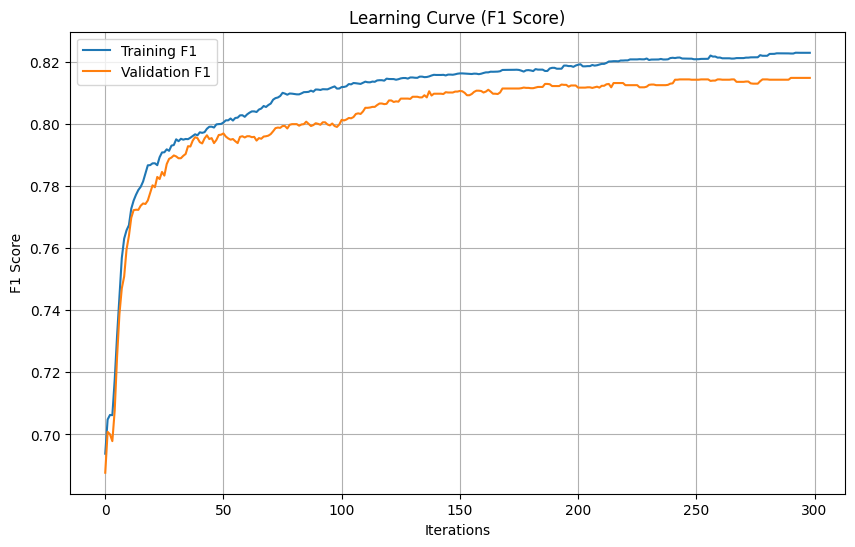

In [485]:
train_scores = cat_model.evals_result_["learn"]["F1"]
validation_scores = cat_model.evals_result_["validation"]["F1"]

# plot learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_scores, label="Training F1")
plt.plot(validation_scores, label="Validation F1")
plt.xlabel("Iterations")
plt.ylabel("F1 Score")
plt.title("Learning Curve (F1 Score)")
plt.legend()
plt.grid(True)
plt.show()

It generalized reasonably well!!

## Model Evaluation

### Classification report:

In [495]:
cat_preds = cat_model.predict(X_test)

from sklearn.metrics import f1_score
report = classification_report(y_test, cat_preds, target_names=["No", "Yes"])
print(report)

              precision    recall  f1-score   support

          No       0.97      0.90      0.93      7635
         Yes       0.51      0.82      0.63      1004

    accuracy                           0.89      8639
   macro avg       0.74      0.86      0.78      8639
weighted avg       0.92      0.89      0.90      8639



The improvements in F1-score were not outstanding but still notable. Overall accuracy dropped slightly, but the change is not significant. Recall for true positives—our primary objective—improved significantly, demonstrating better identification of potential subscribers. Precision, which measures how many predicted subscribers are actually correct, declined. However, we are prioritizing recall, which measures how many actual subscribers were successfully identified, to ensure we capture as many potential subscribers as possible. **It's okay to do some wrong calls!!**

### ROC curve:

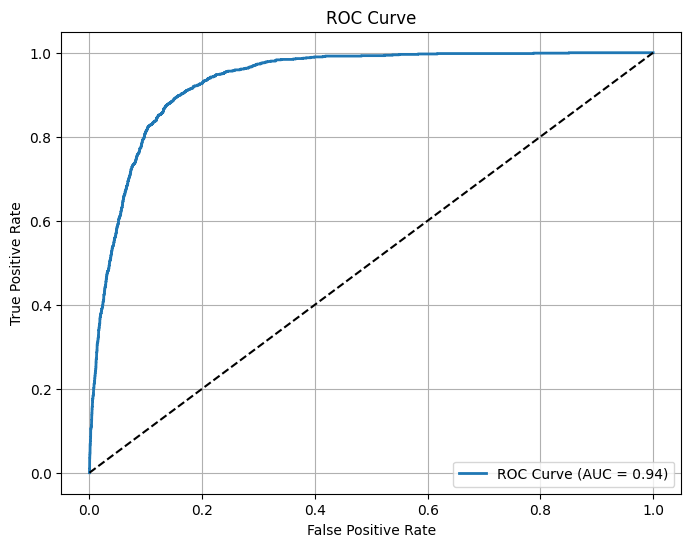

In [499]:
# prediction probabilities
cat_probs = cat_model.predict_proba(X_test)[:, 1]

# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, cat_probs)

# ROC AUC score
auc_score = roc_auc_score(y_test, cat_probs)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.2f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

The AUC score is basically the same.

### Confusion Matrix

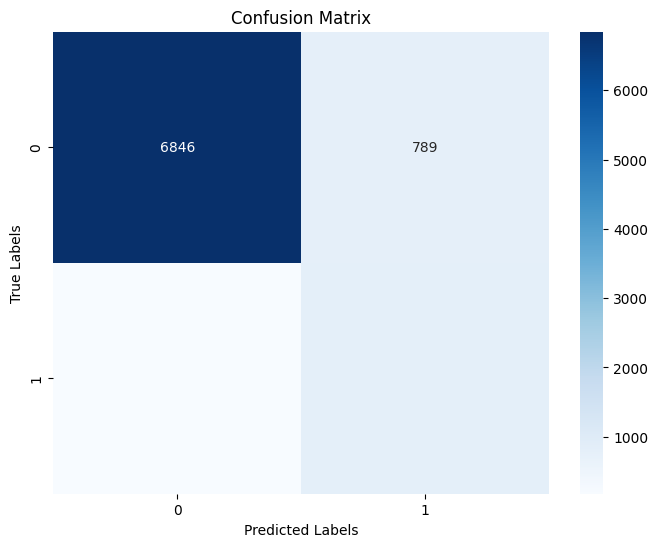

In [503]:
# make predictions
y_pred = cat_model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

# plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["0", "1"], yticklabels=["0", "1"])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

After hyperparameter tuning, the matrix shows an increase in identified subscribers, though some misclassifications remain.

## Feature selection:

Understanding what drives our model is essential. We use **two powerful methods**: **Permutation Importance**, which quickly highlights key features by measuring how performance drops when we shuffle them, and **SHAP Violin Plots**, which reveal not only which features matter but also how they influence predictions—whether positively or negatively. Together, these methods provide a clear and well-rounded view of our model’s decision-making process, helping us understand both *what* drives the model and *how* it makes its predictions.

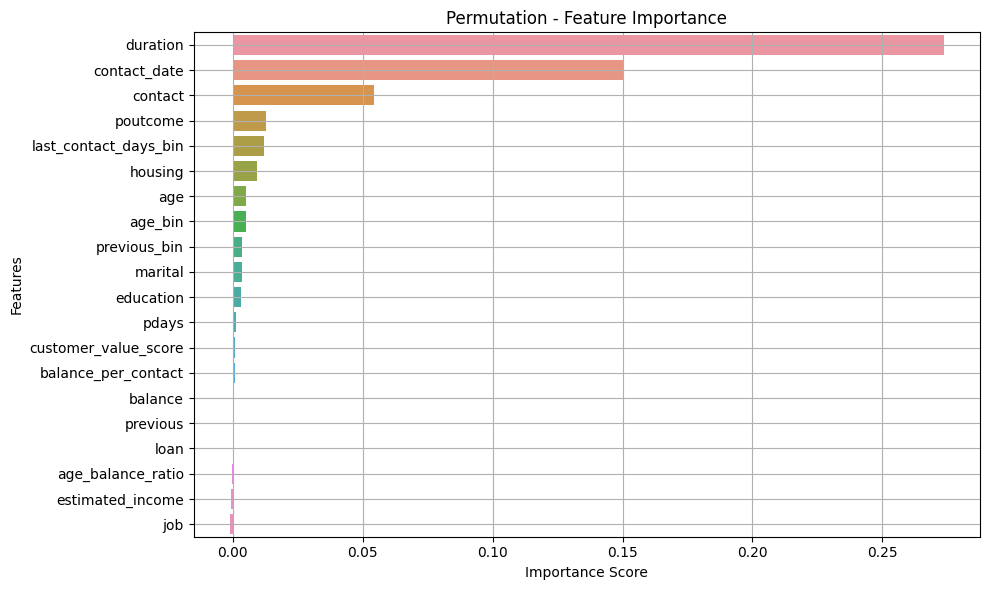

In [508]:
# permutation importance
perm_importance = permutation_importance(cat_model, X_test, y_test, scoring="f1", 
                                         n_repeats=10, random_state=42)

# to conver into df
perm_feature_scores = pd.DataFrame({
    "Feature": X_test.columns,
    "Importance": perm_importance.importances_mean
    }).sort_values(by="Importance", ascending=False)

# plot permutation importance
plt.figure(figsize=(10, 6))
sns.barplot(x=perm_feature_scores["Importance"], y=perm_feature_scores["Feature"])
plt.title("Permutation - Feature Importance")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.grid(True)
plt.tight_layout()
plt.show()

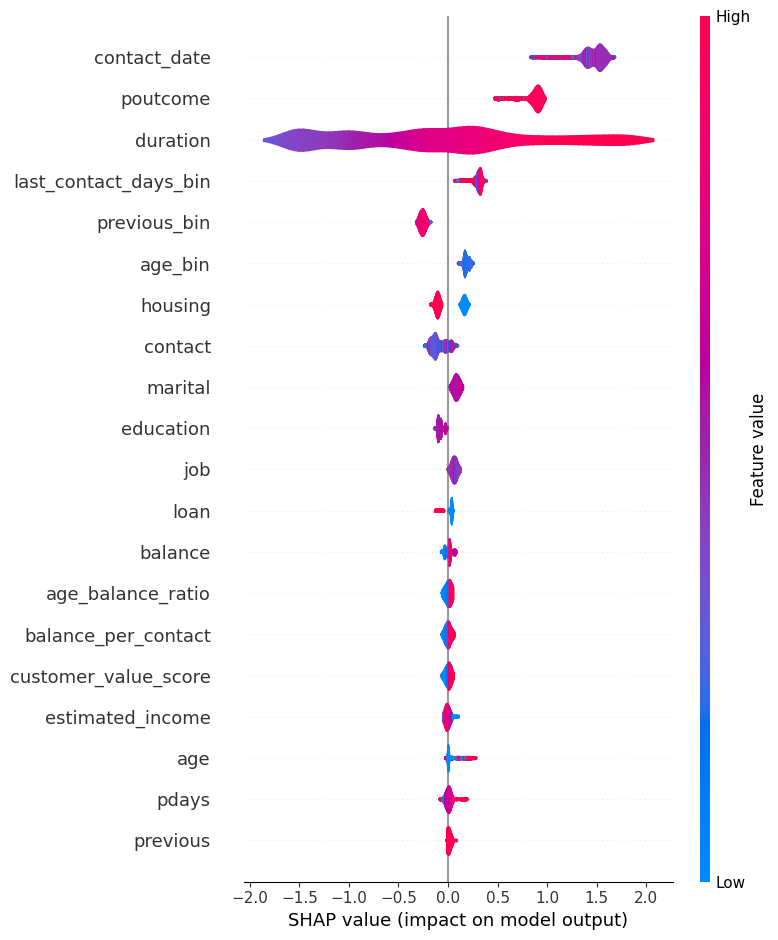

In [510]:
# to ensure that categorical features are encoded
X_test_encoded = X_test.copy()
for col in category_cols:
    X_test_encoded[col] = X_test_encoded[col].astype('category').cat.codes

# initialize SHAP explainer
explainer = shap.TreeExplainer(cat_model)

# calculate SHAP values
shap_values = explainer.shap_values(X_test_encoded)

# plot (violin plot)
shap.summary_plot(shap_values, X_test_encoded, plot_type="violin")

The analysis highlights "Duration" and "Contact_date" as the most impactful features, with "Poutcome" and "Contact" following after. SHAP shows that high "Duration" strongly boosts predictions, while "Contact_date" has mixed effects. On the other hand, features like "Previous" and "Age" contribute very little. We'll focus on the top features from SHAP and permutation importance, drop the less important ones, and retrain the model to improve performance and efficiency.

### We'll keep features with importance scores above 5% of the maximum, focusing on the most impactful ones:

In [514]:
perm_importance = pd.DataFrame({
    'feature': X_test.columns, 
    'perm_importance': perm_importance.importances_mean
})

# set threshold to 5% of the maximum importance
perm_threshold = 0.05 * perm_importance['perm_importance'].max()  # Keep features contributing >5%
perm_features = perm_importance[perm_importance['perm_importance'] > perm_threshold]['feature'].tolist()

# filter dataset based on selected features
X_train_filtered = X_train[perm_features]
X_test_filtered = X_test[perm_features]

# Print selected features
print("Selected Features Based on Permutation Importance (>5% threshold):")
print(perm_features)

Selected Features Based on Permutation Importance (>5% threshold):
['contact', 'duration', 'contact_date']


In [518]:
category_cols = ['contact_date', 'contact']

# initialize the tunned model
cat_model_filtered = CatBoostClassifier(**best_params, cat_features=category_cols)

# and retrain the model on the filtered dataset
cat_model_filtered.fit(X_train_filtered, y_train)

# lets make predictions
y_pred_filtered = cat_model_filtered.predict(X_test_filtered)

0:	learn: 0.6583566	total: 32.8ms	remaining: 9.77s
1:	learn: 0.6250574	total: 42.9ms	remaining: 6.37s
2:	learn: 0.5970145	total: 50.9ms	remaining: 5.02s
3:	learn: 0.5733629	total: 59.7ms	remaining: 4.4s
4:	learn: 0.5500751	total: 67.9ms	remaining: 3.99s
5:	learn: 0.5284409	total: 76.2ms	remaining: 3.72s
6:	learn: 0.5173858	total: 82.6ms	remaining: 3.44s
7:	learn: 0.4993924	total: 89ms	remaining: 3.24s
8:	learn: 0.4859137	total: 95.6ms	remaining: 3.08s
9:	learn: 0.4721730	total: 102ms	remaining: 2.95s
10:	learn: 0.4625418	total: 108ms	remaining: 2.83s
11:	learn: 0.4537019	total: 115ms	remaining: 2.75s
12:	learn: 0.4456330	total: 122ms	remaining: 2.68s
13:	learn: 0.4351099	total: 129ms	remaining: 2.63s
14:	learn: 0.4261279	total: 137ms	remaining: 2.59s
15:	learn: 0.4194611	total: 142ms	remaining: 2.52s
16:	learn: 0.4130689	total: 148ms	remaining: 2.46s
17:	learn: 0.4080574	total: 155ms	remaining: 2.42s
18:	learn: 0.4026510	total: 164ms	remaining: 2.42s
19:	learn: 0.3977476	total: 170ms	r

## Model Evaluation

### Classification report:

In [522]:
filtered_report = classification_report(y_test, y_pred_filtered, target_names=["No", "Yes"])
print(filtered_report)

              precision    recall  f1-score   support

          No       0.97      0.89      0.93      7635
         Yes       0.49      0.78      0.60      1004

    accuracy                           0.88      8639
   macro avg       0.73      0.84      0.77      8639
weighted avg       0.91      0.88      0.89      8639



**Slightly worst!** Did not improve at all with feature selection unfortunately.

### ROC curve:

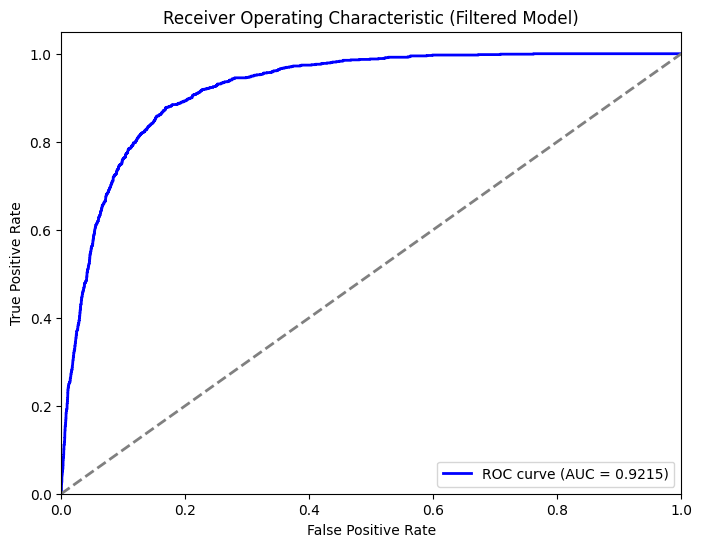

In [527]:
# get predicted probabilities for the filtered model
y_test_proba_filtered = cat_model_filtered.predict_proba(X_test_filtered)[:, 1]

# ROC AUC score
auc_score_filtered = roc_auc_score(y_test, y_test_proba_filtered)

# ROC curve
fpr_filtered, tpr_filtered, _ = roc_curve(y_test, y_test_proba_filtered)

# plot
plt.figure(figsize=(8, 6))
plt.plot(fpr_filtered, tpr_filtered, color='blue', lw=2, label=f'ROC curve (AUC = {auc_score_filtered:.4f})')
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (Filtered Model)')
plt.legend(loc="lower right")
plt.show()

Got worst as well!

### Confusion matrix:

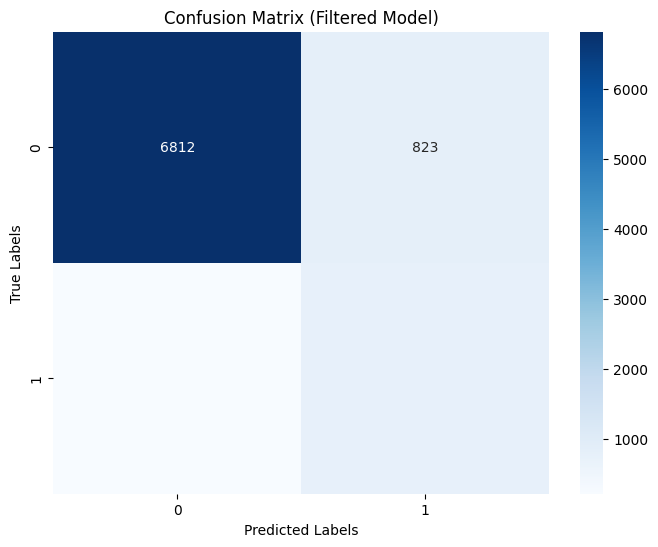

In [532]:
# make predictions
y_pred_filtered = cat_model_filtered.predict(X_test_filtered)

# confusion matrix (filtered)
cm_filtered = confusion_matrix(y_test, y_pred_filtered)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_filtered, annot=True, fmt='d', cmap='Blues', xticklabels=["0", "1"], yticklabels=["0", "1"])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (Filtered Model)')
plt.show()

# Summary of Results

After parameter tuning, our model achieves a better balance between the minority ("Yes") and majority ("No") classes. The **accuracy decreased slightly to 89%** from 91%, reflecting a small trade-off for improved handling of imbalanced classes. Precision for "Yes" is **51%**, meaning the model's predictions for subscribers include some false positives. However, recall for "Yes" improved significantly to **82%**, showing the model captures more true subscribers—critical for identifying valuable leads. For non-subscribers ("No"), the model maintains high precision (**97%**) and recall (**90%**). The AUC score of **0.94** confirms the model's strong overall ability to separate the classes.

Unfortunately, feature selection did not improve the model's performance. As a result, we consider the hyperparameter-tuned model without feature selection as our final model for comparison.